In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
# import geopandas as gpd
from datetime import datetime
import json
import re
import nltk
import spacy
from spacy.lang.en.stop_words import STOP_WORDS as en_stop
from langdetect import detect
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from gensim import corpora, models, similarities, downloader
from nltk.tokenize import RegexpTokenizer
from wordcloud import WordCloud
import warnings
from PIL import Image
from sklearn.cluster import KMeans
warnings.filterwarnings('ignore')

In [6]:
list(en_stop)

['eight',
 'twelve',
 'whither',
 'same',
 'seem',
 'yourself',
 'part',
 'amount',
 'our',
 'beyond',
 'regarding',
 'has',
 'everyone',
 'show',
 'front',
 'meanwhile',
 'behind',
 'you',
 'must',
 'at',
 'very',
 'such',
 'whenever',
 'anyhow',
 'wherein',
 'under',
 'few',
 'however',
 'as',
 'otherwise',
 'whether',
 'among',
 'its',
 'although',
 'thru',
 'we',
 'if',
 'on',
 'anyway',
 'also',
 'once',
 'six',
 'get',
 'some',
 'thence',
 'i',
 'nowhere',
 'whose',
 'would',
 'becoming',
 'about',
 'latter',
 'they',
 'did',
 'elsewhere',
 'quite',
 'yours',
 '’re',
 'off',
 're',
 'whoever',
 'since',
 'hereupon',
 'several',
 'herein',
 'all',
 'twenty',
 'ca',
 'one',
 'he',
 'across',
 'take',
 'due',
 'mine',
 'then',
 'least',
 'should',
 'when',
 'ours',
 'whereupon',
 'being',
 'moreover',
 'always',
 'towards',
 'much',
 'the',
 'down',
 'another',
 'be',
 'himself',
 'itself',
 'without',
 'for',
 'someone',
 "'m",
 'forty',
 'might',
 'not',
 '‘ll',
 'throughout',
 's

# Functions

In [7]:
def tokenize(df):
    """Tokenize the text."""
    tokenizer = RegexpTokenizer(r'[^\s,\.\-\?!:;\(\)\"\"\#\$\%\&\*\/0-9]+')
    tokenized = [" ".join(tokenizer.tokenize(
                df['title'].values[i].lower()))
                for i in range(df.shape[0])]
    df['tokenized_text'] = tokenized
    return df


def remove_stopwords(df):
    """Remove stop words from the tokenized text."""
    stop_words = stopwords.words('english') + list(en_stop)
    stop_words += ["what's", "there's", 'that\'s', 'i\'m', 'pm',
                   'we\'re', 'i\'ve', 'i\'ll', 'i\'d', 'etc', 'am', 'nn',
                   'would', 'also', 'act', 'fund', 'purpose', 'establish',
                   'therefor', 'amend', 'provide', 'appropriating', 
                   'otherwise', 'republic', 'philippine', 'know', 'create',
                   'institutionalize', 'section', 'institute', 'strengthen', 
                   'appropriate', 'office', 'authority', 'declare', 
                   'and', 'for', 'the', 'of', 'to', 'an', 'as', 'in',
                   'its', 'amended', 'known', 'from', 'on',
                   'would', 'also', 'act', 'fund', 'purpose', 'establish',
                   'therefor', 'provide', 'appropriating', 'amend',
                   'otherwise', 'philippine', 'know', 'create',
                   'institutionalize', 'section', 'institute',
                   'strengthen', 'appropriate', 'office', 'authority',
                   'declare', 'other', 'no', 'fund therefor',
                   'appropriating fund', 'for other', 'and for',
                   'an act', 'in the', 'other purpose', 'and appropriating',
                   'act establish', 'for the', 'of the', 'as the',
                   'act provide', 'province of', 'act no', 'municipality of',
                   'therfor and', 'provide for', 'otherwise known',
                   'therefor and', 'establish the', 'and provide', 'or',
                   'the purpose', 'the national', 'to be', 'act of',
                   'be know', 'amend for', 'provide for', 'act declare',
                   "as amended", 'known as']
    stopped = ([" ".join([text for text in
                         [word for word in
                          df['tokenized_text'].values[i].split()]
                          if text not in stop_words])
                for i in range(df.shape[0])])
    df['stopped_text'] = stopped
    return df


def lemmatize(df):
    """Lemmatize the texts without stop words."""
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    stemmed = ([" ".join([token.lemma_ for token in
                          nlp(df['stopped_text'].values[i])])
                for i in range(df.shape[0])])
    df['stemmed_text'] = stemmed
    return df


def tfidf_converter(text_array):
    """Return a tf-idf matrix from an array containing text data.

    Parameters
    ----------
    text_array : np.array
        A numpy array that represents the corpus, which would be converted
        to a tf-idf matrix.

    Returns
    -------
    tfidf : scipy.sparse.csr.csr_matrix
        A sparse matrix in compressed sparse row (CSR) format which serves as
        the tf-idf representation of the entire corpus.
    """
    corpus = [text_array[i] for i in range(text_array.shape[0])]
    vectorizer = TfidfVectorizer(lowercase=True,
                                   token_pattern=r'(?u)\b[a-z]{3,}-?\w*\b',
                                   ngram_range=(1, 3),
                                   min_df=0.001, max_df=0.8)
    tfidf = vectorizer.fit_transform(corpus)
    columns = vectorizer.get_feature_names()
    return tfidf, columns


def wordcloud_frame(tfidf, stopwords, columns):
    """Return the sum of the tfidf scores of all words in the corpus."""
    words_df = pd.DataFrame(tfidf.toarray().sum(axis=0)).T
    words_df.columns = columns
    words_df = words_df.drop(stopwords, axis=1)
    words_df = words_df.T
    words_df.columns = ['tfidf_score']
    return words_df


def wordcloud_plotting(tfidf_score, cmap, title, mask, c_color='white'):
    """Visualize a wordcloud from the tfidf matrix."""
    wordcloud = WordCloud(max_words=180, background_color='#235578',
                          relative_scaling=0.5, colormap=cmap, width=1600,
                          height=1600, mask=mask, contour_width=0.1,
                         contour_color=c_color)
    wordcloud.generate_from_frequencies(tfidf_score)
    fig = plt.figure(figsize=(10,10), dpi=300)
    fig = plt.axis('off')
    fig = plt.imshow(wordcloud)
    fig = plt.title(title, fontsize=14)
    fig = plt.show()
#     wordcloud.to_file(f'{title}.jpg')
    return fig

def transform_format(val):
    if val == True:
        return 255
    else:
        return val

# Load Data

In [8]:
hbs = pd.read_csv('hbs_old.csv').drop_duplicates(subset=['title'])
hbs

house_bill_number                                              title  \
0               HB00001  AN ACT INSTITUTIONALIZING A NATIONAL VALUES, E...   
1               HB00002  AN ACT CREATING THE DEPARTMENT OF OVERSEAS FIL...   
2               HB00003  AN ACT PROVIDING FOR A NATIONAL PROGRAM TO SUP...   
3               HB00004  AN ACT CREATING THE EMERGENCY RESPONSE DEPARTM...   
4               HB00005  AN ACT INSTITUTIONALIZING MICROFINANCE PROGRAM...   
...                 ...                                                ...   
10091           HB10105  AN ACT CRIMINALIZING THE USE OF FAKE VACCINATI...   
10092           HB10106  AN ACT DEFINING AND CRIMINALIZING VACCINE HOAR...   
10093           HB10107  AN ACT PROVIDING FOR THE PROMOTION AND DEVELOP...   
10094           HB10108  AN ACT ESTABLISHING A SPECIAL ECONOMIC ZONE IN...   
10095           HB10109  AN ACT ESTABLISHING A SPECIAL ECONOMIC ZONE IN...   

      significance  date_filed  \
0         NATIONAL  2019-07-01   
1         NATIONAL  2019-07-01   
2         NATIONAL  2019-07-01   
3         NATIONAL  2019-07-01   
4         NATIONAL  2019-07-01   
...            ...         ...   
10091     NATIONAL  2021-08-30   
10092     NATIONAL  2021-08-30   
10093     NATIONAL  2021-08-30   
10094        LOCAL  2021-08-30   
10095        LOCAL  2021-08-30   

                                       principal_authors   date_read  \
0      CAYETANO, ALAN PETER "COMPAÑERO" S.; MADRONA. ...  2019-07-23   
1      CAYETANO, ALAN PETER "COMPAÑERO" S.; CAYETANO,...  2019-07-23   
2                    CAYETANO, ALAN PETER "COMPAÑERO" S.  2019-07-23   
3      CAYETANO, ALAN PETER "COMPAÑERO" S.; DUTERTE, ...  2019-07-23   
4                    CAYETANO, ALAN PETER "COMPAÑERO" S.  2019-07-23   
...                                                  ...         ...   
10091                SY-ALVARADO, "KUYA" JOSE ANTONIO R.  2021-09-01   
10092                                     VARGAS, ALFRED  2021-09-01   
10093  YAP, VICTOR A.; COJUANGCO, CARLOS O.; DE VENEC...  2021-08-31   
10094  BARONDA, JULIENNE "JAM" L.; GARIN, SHARON S.; ...  2021-08-31   
10095  RAMIREZ-SATO, JOSEPHINE; GARIN, SHARON S.; TIA...  2021-08-31   

                                     primary_referral  \
0                         BASIC EDUCATION AND CULTURE   
1                           GOVERNMENT REORGANIZATION   
2                                 WELFARE OF CHILDREN   
3                           GOVERNMENT REORGANIZATION   
4      MICRO, SMALL AND MEDIUM ENTERPRISE DEVELOPMENT   
...                                               ...   
10091                                         JUSTICE   
10092                                         JUSTICE   
10093                                           RULES   
10094                                           RULES   
10095                                           RULES   

                                      mother_bill_status  \
0             Republic Act RA11476 enacted on 2020-06-25   
1      Approved by the House on 2020-03-11, transmitt...   
2                                                    NaN   
3      Approved by the House on 2020-09-22, transmitt...   
4                                                    NaN   
...                                                  ...   
10091                                                NaN   
10092                                                NaN   
10093                                                NaN   
10094                                                NaN   
10095                                                NaN   

                                                  status  
0                                 Substituted by HB05829  
1                                 Substituted by HB05832  
2      Transmitted to the Committee on Appropriations...  
3                                 Substituted by HB05989  
4      Pending with the Committee on MICRO, SMALL AND...  
...                                

# Preprocessing

Adding `passed` or `not passed` labels to bills.... (for clustering?)

In [9]:
def bill_labelling(df):
    prox = df.copy().fillna('0')
    prox
    conditions = [
        ((prox['mother_bill_status'].str.strip().str.startswith('Republic Act')) |
        (prox['status'].str.strip().str.startswith('Republic Act')))
    ]
    choices = ['passed']
    prox['pass_or_not'] = np.select(conditions, choices, default='not passed')

    prox[prox.mother_bill_status.str.startswith('Republic Act')]
    return prox['pass_or_not']

In [10]:
hbs['pass_or_not'] = bill_labelling(hbs)

In [11]:
hbs

house_bill_number                                              title  \
0               HB00001  AN ACT INSTITUTIONALIZING A NATIONAL VALUES, E...   
1               HB00002  AN ACT CREATING THE DEPARTMENT OF OVERSEAS FIL...   
2               HB00003  AN ACT PROVIDING FOR A NATIONAL PROGRAM TO SUP...   
3               HB00004  AN ACT CREATING THE EMERGENCY RESPONSE DEPARTM...   
4               HB00005  AN ACT INSTITUTIONALIZING MICROFINANCE PROGRAM...   
...                 ...                                                ...   
10091           HB10105  AN ACT CRIMINALIZING THE USE OF FAKE VACCINATI...   
10092           HB10106  AN ACT DEFINING AND CRIMINALIZING VACCINE HOAR...   
10093           HB10107  AN ACT PROVIDING FOR THE PROMOTION AND DEVELOP...   
10094           HB10108  AN ACT ESTABLISHING A SPECIAL ECONOMIC ZONE IN...   
10095           HB10109  AN ACT ESTABLISHING A SPECIAL ECONOMIC ZONE IN...   

      significance  date_filed  \
0         NATIONAL  2019-07-01   
1         NATIONAL  2019-07-01   
2         NATIONAL  2019-07-01   
3         NATIONAL  2019-07-01   
4         NATIONAL  2019-07-01   
...            ...         ...   
10091     NATIONAL  2021-08-30   
10092     NATIONAL  2021-08-30   
10093     NATIONAL  2021-08-30   
10094        LOCAL  2021-08-30   
10095        LOCAL  2021-08-30   

                                       principal_authors   date_read  \
0      CAYETANO, ALAN PETER "COMPAÑERO" S.; MADRONA. ...  2019-07-23   
1      CAYETANO, ALAN PETER "COMPAÑERO" S.; CAYETANO,...  2019-07-23   
2                    CAYETANO, ALAN PETER "COMPAÑERO" S.  2019-07-23   
3      CAYETANO, ALAN PETER "COMPAÑERO" S.; DUTERTE, ...  2019-07-23   
4                    CAYETANO, ALAN PETER "COMPAÑERO" S.  2019-07-23   
...                                                  ...         ...   
10091                SY-ALVARADO, "KUYA" JOSE ANTONIO R.  2021-09-01   
10092                                     VARGAS, ALFRED  2021-09-01   
10093  YAP, VICTOR A.; COJUANGCO, CARLOS O.; DE VENEC...  2021-08-31   
10094  BARONDA, JULIENNE "JAM" L.; GARIN, SHARON S.; ...  2021-08-31   
10095  RAMIREZ-SATO, JOSEPHINE; GARIN, SHARON S.; TIA...  2021-08-31   

                                     primary_referral  \
0                         BASIC EDUCATION AND CULTURE   
1                           GOVERNMENT REORGANIZATION   
2                                 WELFARE OF CHILDREN   
3                           GOVERNMENT REORGANIZATION   
4      MICRO, SMALL AND MEDIUM ENTERPRISE DEVELOPMENT   
...                                               ...   
10091                                         JUSTICE   
10092                                         JUSTICE   
10093                                           RULES   
10094                                           RULES   
10095                                           RULES   

                                      mother_bill_status  \
0             Republic Act RA11476 enacted on 2020-06-25   
1      Approved by the House on 2020-03-11, transmitt...   
2                                                    NaN   
3      Approved by the House on 2020-09-22, transmitt...   
4                                                    NaN   
...                                                  ...   
10091                                                NaN   
10092                                                NaN   
10093                                                NaN   
10094                                                NaN   
10095                                                NaN   

                                                  status pass_or_not  
0                                 Substituted by HB05829      passed  
1                                 Substituted by HB05832  not passed  
2      Transmitted to the Committee on Appropriations...  not passed  
3                                 Substituted by HB05989  not passed  
4      Pending with the Committee 

In [12]:
df_not_passed = hbs[hbs.pass_or_not == 'not passed']
df_not_passed.head()

house_bill_number                                              title  \
1           HB00002  AN ACT CREATING THE DEPARTMENT OF OVERSEAS FIL...   
2           HB00003  AN ACT PROVIDING FOR A NATIONAL PROGRAM TO SUP...   
3           HB00004  AN ACT CREATING THE EMERGENCY RESPONSE DEPARTM...   
4           HB00005  AN ACT INSTITUTIONALIZING MICROFINANCE PROGRAM...   
6           HB00007  AN ACT CREATING A DEPARTMENT OF FISHERIES AND ...   

  significance  date_filed                                  principal_authors  \
1     NATIONAL  2019-07-01  CAYETANO, ALAN PETER "COMPAÑERO" S.; CAYETANO,...   
2     NATIONAL  2019-07-01                CAYETANO, ALAN PETER "COMPAÑERO" S.   
3     NATIONAL  2019-07-01  CAYETANO, ALAN PETER "COMPAÑERO" S.; DUTERTE, ...   
4     NATIONAL  2019-07-01                CAYETANO, ALAN PETER "COMPAÑERO" S.   
6     NATIONAL  2019-07-01                CAYETANO, ALAN PETER "COMPAÑERO" S.   

    date_read                                primary_referral  \
1  2019-07-23                       GOVERNMENT REORGANIZATION   
2  2019-07-23                             WELFARE OF CHILDREN   
3  2019-07-23                       GOVERNMENT REORGANIZATION   
4  2019-07-23  MICRO, SMALL AND MEDIUM ENTERPRISE DEVELOPMENT   
6  2019-07-23                       GOVERNMENT REORGANIZATION   

                                  mother_bill_status  \
1  Approved by the House on 2020-03-11, transmitt...   
2                                                NaN   
3  Approved by the House on 2020-09-22, transmitt...   
4                                                NaN   
6                                                NaN   

                                              status pass_or_not  
1                             Substituted by HB05832  not passed  
2  Transmitted to the Committee on Appropriations...  not passed  
3                             Substituted by HB05989  not passed  
4  Pending with the Committee on MICRO, SMALL AND...  not passed  
6  Pending with the Committee on GOVERNMENT REORG...  not passed

# Passed Bills Analysis

In [13]:
df_passed = hbs[hbs.pass_or_not == 'passed']
df_passed.head()

house_bill_number                                              title  \
0             HB00001  AN ACT INSTITUTIONALIZING A NATIONAL VALUES, E...   
5             HB00006  AN ACT PROVIDING FOR ADDITIONAL SUPPORT AND CO...   
9             HB00010  AN ACT DECLARING THE COCONUT LEVY ASSETS AS A ...   
46            HB00047  AN ACT POSTPONING THE MAY 2020 BARANGAY AND SA...   
165           HB00166  AN ACT ESTABLISHING THE COCONUT FARMERS AND IN...   

    significance  date_filed  \
0       NATIONAL  2019-07-01   
5       NATIONAL  2019-07-01   
9       NATIONAL  2019-07-01   
46      NATIONAL  2019-07-01   
165     NATIONAL  2019-07-01   

                                     principal_authors   date_read  \
0    CAYETANO, ALAN PETER "COMPAÑERO" S.; MADRONA. ...  2019-07-23   
5                  CAYETANO, ALAN PETER "COMPAÑERO" S.  2019-07-23   
9                  CAYETANO, ALAN PETER "COMPAÑERO" S.  2019-07-23   
46                            DY, FAUSTINO "INNO" V A.  2019-07-23   
165                    TAN, ANGELINA "HELEN" D.L. M.D.  2019-07-23   

                   primary_referral  \
0       BASIC EDUCATION AND CULTURE   
5                    APPROPRIATIONS   
9              AGRICULTURE AND FOOD   
46   SUFFRAGE AND ELECTORAL REFORMS   
165            AGRICULTURE AND FOOD   

                             mother_bill_status                     status  \
0    Republic Act RA11476 enacted on 2020-06-25     Substituted by HB05829   
5    Republic Act RA11466 enacted on 2020-01-08  Consolidated into HB05712   
9    Republic Act RA11524 enacted on 2021-02-26     Substituted by HB08136   
46   Republic Act RA11462 enacted on 2019-12-03     Substituted by HB04933   
165  Republic Act RA11524 enacted on 2021-02-26     Substituted by HB08136   

    pass_or_not  
0        passed  
5        passed  
9        passed  
46       passed  
165      passed

In [14]:
df = df_passed[['title']]
df

title
0     AN ACT INSTITUTIONALIZING A NATIONAL VALUES, E...
5     AN ACT PROVIDING FOR ADDITIONAL SUPPORT AND CO...
9     AN ACT DECLARING THE COCONUT LEVY ASSETS AS A ...
46    AN ACT POSTPONING THE MAY 2020 BARANGAY AND SA...
165   AN ACT ESTABLISHING THE COCONUT FARMERS AND IN...
...                                                 ...
8712  AN ACT GRANTING THE HIGHLAND BROADCASTING NETW...
8847  AN ACT\r\nGRANTING HIGHLAND BROADCASTING NETWO...
8915  AN ACT\r\nESTABLISHING THE PHILIPPINE ENERGY R...
9298  AN ACT REMOVING THE EXPIRATION PERIOD OF THE J...
9473  AN ACT \r\nENHANCING THE POWERS AND FUNCTIONS ...

[422 rows x 1 columns]

## Cleaning of Bill Titles 

(tokenizing, removing stop words, lemmatizing)

In [15]:
def cleaned_titles(df):
    df_tokenized_p = tokenize(df)
    df_tokenized_p

    df_stopped_p = remove_stopwords(df_tokenized_p)
    df_stopped_p

    df_stemmed_p = lemmatize(df_stopped_p)

    return df_stemmed_p

In [16]:
cleaned_titles_p = cleaned_titles(df)[['stemmed_text']]
cleaned_titles_p

stemmed_text
0     institutionalize national value etiquette mora...
5     provide additional support compensation educat...
9     declare coconut levy asset trust provide manag...
46    postpone barangay sangguniang kabataan electio...
165   establish coconut farmer industry development ...
...                                                 ...
8712  grant highland broadcasting network corp franc...
8847  grant highland broadcasting network corp franc...
8915  establish energy research policy define object...
9298  remove expiration period joint congressional e...
9473  enhance power function joint congressional ene...

[422 rows x 1 columns]

In [17]:
bow_cong_p, cols_p = tfidf_converter(cleaned_titles_p['stemmed_text'].values)

# tfidf_vectorizer = TfidfVectorizer(lowercase=True, stop_words=stopwords_list,
#                                    token_pattern=r'(?u)\b[a-z]{3,}-?\w*\b',
#                                    ngram_range=(1, 3),
#                                    min_df=0.001, max_df=0.8)
# bow_cong = tfidf_vectorizer.fit_transform(cleaned_titles_p)

In [18]:
bow_cong_p.todense().shape


cols_p

['abra',
 'abra fund',
 'abra state',
 'abra state sciences',
 'abra state university',
 'academic',
 'academic calendar',
 'academic calendar june',
 'academic calendar level',
 'academy',
 'academy establish',
 'academy establish medical',
 'academy sport',
 'academy sport development',
 'academy sport fund',
 'academy sport provide',
 'academy sport system',
 'accelerate',
 'accelerate recovery',
 'accelerate recovery bolster',
 'access',
 'access medical',
 'access medical financial',
 'accredit',
 'accredit public',
 'accredit public hospital',
 'act',
 'act nubered',
 'act nubered purpose',
 'act number',
 'act number purpose',
 'act provide',
 'act provide fund',
 'activity',
 'actꞌ',
 'actꞌ require',
 'actꞌ require philhealth',
 'add',
 'add new',
 'add new section',
 'add section',
 'add section national',
 'add section new',
 'addite',
 'addite section',
 'addite section chapter',
 'additional',
 'additional benefit',
 'additional benefit purpose',
 'additional compensation',

## LSA

In [ ]:


def plot_var_explained(X, thresh):
    from sklearn.decomposition import TruncatedSVD
    svd_test = TruncatedSVD(n_components=X.shape[1]-1)
    tfidf_new_test = svd_test.fit_transform(X)
    optimal_svs = np.where(svd_test.explained_variance_ratio_.cumsum()>=thresh)[0][0] + 1
    plt.figure(figsize=(13,8))
    plt.plot(svd_test.explained_variance_ratio_.cumsum())
    plt.axhline(thresh, color='teal', ls='--')
    plt.axvline(optimal_svs, color='teal', ls='--')
    plt.annotate(f'n = {optimal_svs}', xy=(optimal_svs+0.5, 0.9),
            weight='bold', size=10);
#     print(f'Optimal number of svs is:{optimal_svs}')
    

In [ ]:

plot_var_explained(bow_cong_p.todense(), 0.9)

In [ ]:
from sklearn.decomposition import TruncatedSVD
tsvd_test_p = TruncatedSVD(n_components=208)
X_cong_p_new = tsvd_test_p.fit_transform(bow_cong_p.todense())
X_cong_p_new

In [ ]:
X_cong_p_new.shape

In [ ]:

def plot_svd(X_new, features, p, x_axis, y_axis):
    """
    Plot transformed data and features on to the first two singular vectors
    (add more)
    
    Parameters
    ----------
    X_new : array
        Transformed data
    featurs : sequence of str
        Feature names
    p : array
        P matrix
    """
#     fig, ax = plt.subplots(1, 2, subplot_kw=dict(aspect='equal'), 
#                            gridspec_kw=dict(wspace=0.4), dpi=150)
    fig, ax = plt.subplots(1, 2, 
                           gridspec_kw=dict(wspace=0.4), dpi=150)
    ax[0].scatter(X_new[:,x_axis], X_new[:,y_axis])
    ax[0].set_xlabel(f'SV{x_axis + 1}')
    ax[0].set_ylabel(f'SV{y_axis + 1}')
    for feature, vec in zip(features, p):
        ax[1].arrow(0, 0, vec[x_axis], vec[y_axis], width=0.01, ec='none', fc='r')
        ax[1].text(vec[x_axis], vec[y_axis], feature, ha='center', color='r', fontsize=5)
    ax[1].set_xlim(-1, 1)
    ax[1].set_ylim(-1, 1)
    ax[1].set_xlabel(f'SV{x_axis + 1}')
    ax[1].set_ylabel(f'SV{y_axis + 1}')

In [ ]:


plot_svd(X_cong_p_new, cols_p, tsvd_test_p.components_.T, 4, 5)

In [ ]:


def plot_LSA(cols, p, top_words=10, top_svs=10):
    fig, ax = plt.subplots(5,2, figsize=(20,30))
    ax = ax.ravel()
    
    for i in range(top_svs):
        
        order = np.argsort(np.abs(p[:, i]))[-top_words:]
        ax[i].barh([cols[o] for o in order], p[order, i], color='#22577A')
        ax[i].set_title(f'SV{i+1}', size=20)
#     plt.subplots_adjust(wspace=1, hspace=0.4)
    plt.tight_layout()
    plt.show()
    

In [ ]:

plot_LSA(cols_p, tsvd_test_p.components_.T, 10)

# K-means

In [ ]:

def gap_statistic(X, y, centroids, dist, b, clusterer, random_state=None):
    """Compute the gap statistic
    
    Parameters
    ----------
    X : array
        Design matrix with each row corresponding to a point
    y : array
        Class label of each point
    centroids : array
        Cluster centroids
    dist : callable
        Distance between two points. It should accept two arrays, each 
        corresponding to the coordinates of each point
    b : int
        Number of realizations for the reference distribution
    clusterer : KMeans
        Clusterer object that will be used for clustering the reference 
        realizations
    random_state : int, default=None
        Determines random number generation for realizations
        
    Returns
    -------
    gs : float
        Gap statistic
    gs_std : float
        Standard deviation of gap statistic
    """
    rng = np.random.default_rng(random_state)
    w_k = pooled_within_ssd(X, y, centroids, dist)
    gap_list = []

    for i in range(b):
        X_fit = rng.uniform(X.min(axis=0), X.max(axis=0), size = X.shape)
        y_fit = clusterer.fit_predict(X_fit)
        centroids_fit = clusterer.cluster_centers_
        w_k_i = pooled_within_ssd(X_fit, y_fit, centroids_fit, dist)

        gap_list.append(np.log(w_k_i) - np.log(w_k))

    gs = np.mean(gap_list)
    gs_std = np.std(gap_list)
    
    return [gs,  gs_std]

def pooled_within_ssd(X, y, centroids, dist):
    """Compute pooled within-cluster sum of squares around the cluster mean
    
    Parameters
    ----------
    X : array
        Design matrix with each row corresponding to a point
    y : array
        Class label of each point
    centroids : array
        Cluster centroids
    dist : callable
        Distance between two points. It should accept two arrays, each 
        corresponding to the coordinates of each point
        
    Returns
    -------
    float
        Pooled within-cluster sum of squares around the cluster mean
    """
    n = np.bincount(y.astype(int))
    return sum(dist(x_i, centroids[y_i])**2 / (2*n[y_i])
              for x_i, y_i in zip(X, y.astype(int)))

In [ ]:


def cluster_range(X, clusterer, k_start, k_stop, actual=None):
    from sklearn.metrics import calinski_harabasz_score, silhouette_score
    from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score
    from sklearn.base import clone
    from scipy.spatial.distance import euclidean, cityblock
    ys = []
    centers = []
    inertias = []
    chs = []
    scs = []
    gss = []
    gssds = []
    ps = []
    amis = []
    ars = []
    for k in range(k_start, k_stop+1):
        clusterer_k = clone(clusterer)
        # YOUR CODE HERE
        clusterer_k.set_params(n_clusters=k)
        clusterer_k.fit(X)
        y = clusterer_k.predict(X)
        ys.append(y)
        centers.append(clusterer_k.cluster_centers_)
        inertias.append(clusterer_k.inertia_)
        chs.append(calinski_harabasz_score(X, y))
        scs.append(silhouette_score(X, y))
        gs = gap_statistic(X, y, clusterer_k.cluster_centers_, 
                                 euclidean, 5, 
                                 clone(clusterer).set_params(n_clusters=k), 
                                 random_state=1337)
        gss.append(gs[0])
        gssds.append(gs[1])
        
        if actual is not None:
            ps.append(purity(actual, y))   
            amis.append(adjusted_mutual_info_score(actual, y))
            ars.append(adjusted_rand_score(actual, y))
    cluster_dict = {'ys': ys,
                    'centers': centers,
                    'inertias': inertias,
                    'chs': chs,
                    'scs': scs,
                    'gss': gss,
                    'gssds': gssds,
                    }
    if actual is not None:
        cluster_dict['ps'] = ps
        cluster_dict['amis'] = amis
        cluster_dict['ars'] = ars
        
    return cluster_dict

In [ ]:


res_cong_p = cluster_range(X_cong_p_new, KMeans(random_state=1337), 2, 12)

In [ ]:


def plot_kmeans_cluster_range(X, X_transformed, min_, max_, x_axis, y_axis):
    from sklearn.cluster import KMeans
    if (max_- min_) <= 5:
        n_rows = 1
        n_cols = max_ - min_
    else:
        n_cols = 5
        if (max_- min_) % n_cols == 0:
            n_rows = int((max_- min_) / n_cols)
        else:
            n_rows = ((max_- min_) // n_cols) + 1
    n_rows, n_cols
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(10,5))
    ax = ax.ravel()
    ax
    for i,k in enumerate(range(min_,max_)):
        kmeans_ = KMeans(n_clusters=k, random_state=1337)
        y_predict = kmeans_.fit_predict(X)
        ax[i].scatter(X_transformed[:,x_axis], X_transformed[:,y_axis], c=y_predict)
        ax[i].set_title(f'K = {k}')

    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    plt.show()



In [ ]:


# plot_kmeans_cluster_range(bow_cong_p, X_cong_new, 2, 9)

In [ ]:


plot_kmeans_cluster_range(X_cong_p_new, X_cong_p_new, 2, 12, 13, 50)

In [ ]:


fig, ax = plt.subplots(2,2, figsize=(15,8))
ax = ax.ravel()
# ax.plot(res_cong['inertias'])
# ax.plot(res_cong['chs'])
# plt.show()
ax[0].plot(np.arange(2, len(res_cong_p['inertias'])+2), res_cong_p['inertias'], marker='o')
ax[0].set_title('Inertias: lower the better')
# ax[0].set_xticklabels(np.arange(2, len(res_cong['inertias'])+2))
# ax[0].axvline()
ax[1].plot(np.arange(2, len(res_cong_p['chs'])+2), res_cong_p['chs'], marker='o')
ax[1].set_title('CHS: higher the better')
ax[2].plot(np.arange(2, len(res_cong_p['scs'])+2), res_cong_p['scs'], marker='o')
ax[2].set_title('Silhouette Score: higher the better')

ax[3].plot(np.arange(2, len(res_cong_p['gss'])+2), res_cong_p['gss'], marker='o')
ax[3].set_title('Gap Stat: higher the better')
plt.subplots_adjust(wspace=0.2, hspace=0.4)
plt.show()

# Agglomerative

## Agglomerative

In [35]:
def plot_dendrogram(X_transformed, p, method='ward', tr_mode='level', show=True, thresh=None):
    from scipy.cluster.hierarchy import linkage, dendrogram
    Z = linkage(X_transformed, method=method)
    dn = dendrogram(Z, truncate_mode=tr_mode, p=p)
    plt.close()
    
    d_t_values = []
    for i in range(len(dn['dcoord'])+1):
        if i != (len(dn['dcoord'])):
            d_t_values.append(dn['dcoord'][i][1] - dn['dcoord'][i][0])
        else: 
            break

    best_t = dn['dcoord'][d_t_values.index(max(d_t_values))][0]
    max_delta = (dn['dcoord'][d_t_values.index(max(d_t_values))][1]
           - dn['dcoord'][d_t_values.index(max(d_t_values))][0])
    mid = max_delta/2
    
    if thresh == None:
        thresh = best_t + mid # optimal cut
    
    fig, ax = plt.subplots(figsize=(12,4), dpi=300)
    ax.axhline(thresh, ls='--', color='black')
    
    
    
    dn = dendrogram(Z, truncate_mode=tr_mode, p=p, color_threshold=thresh, ax=ax)
    if show:
        plt.show()
    else:
        plt.close()
    return thresh

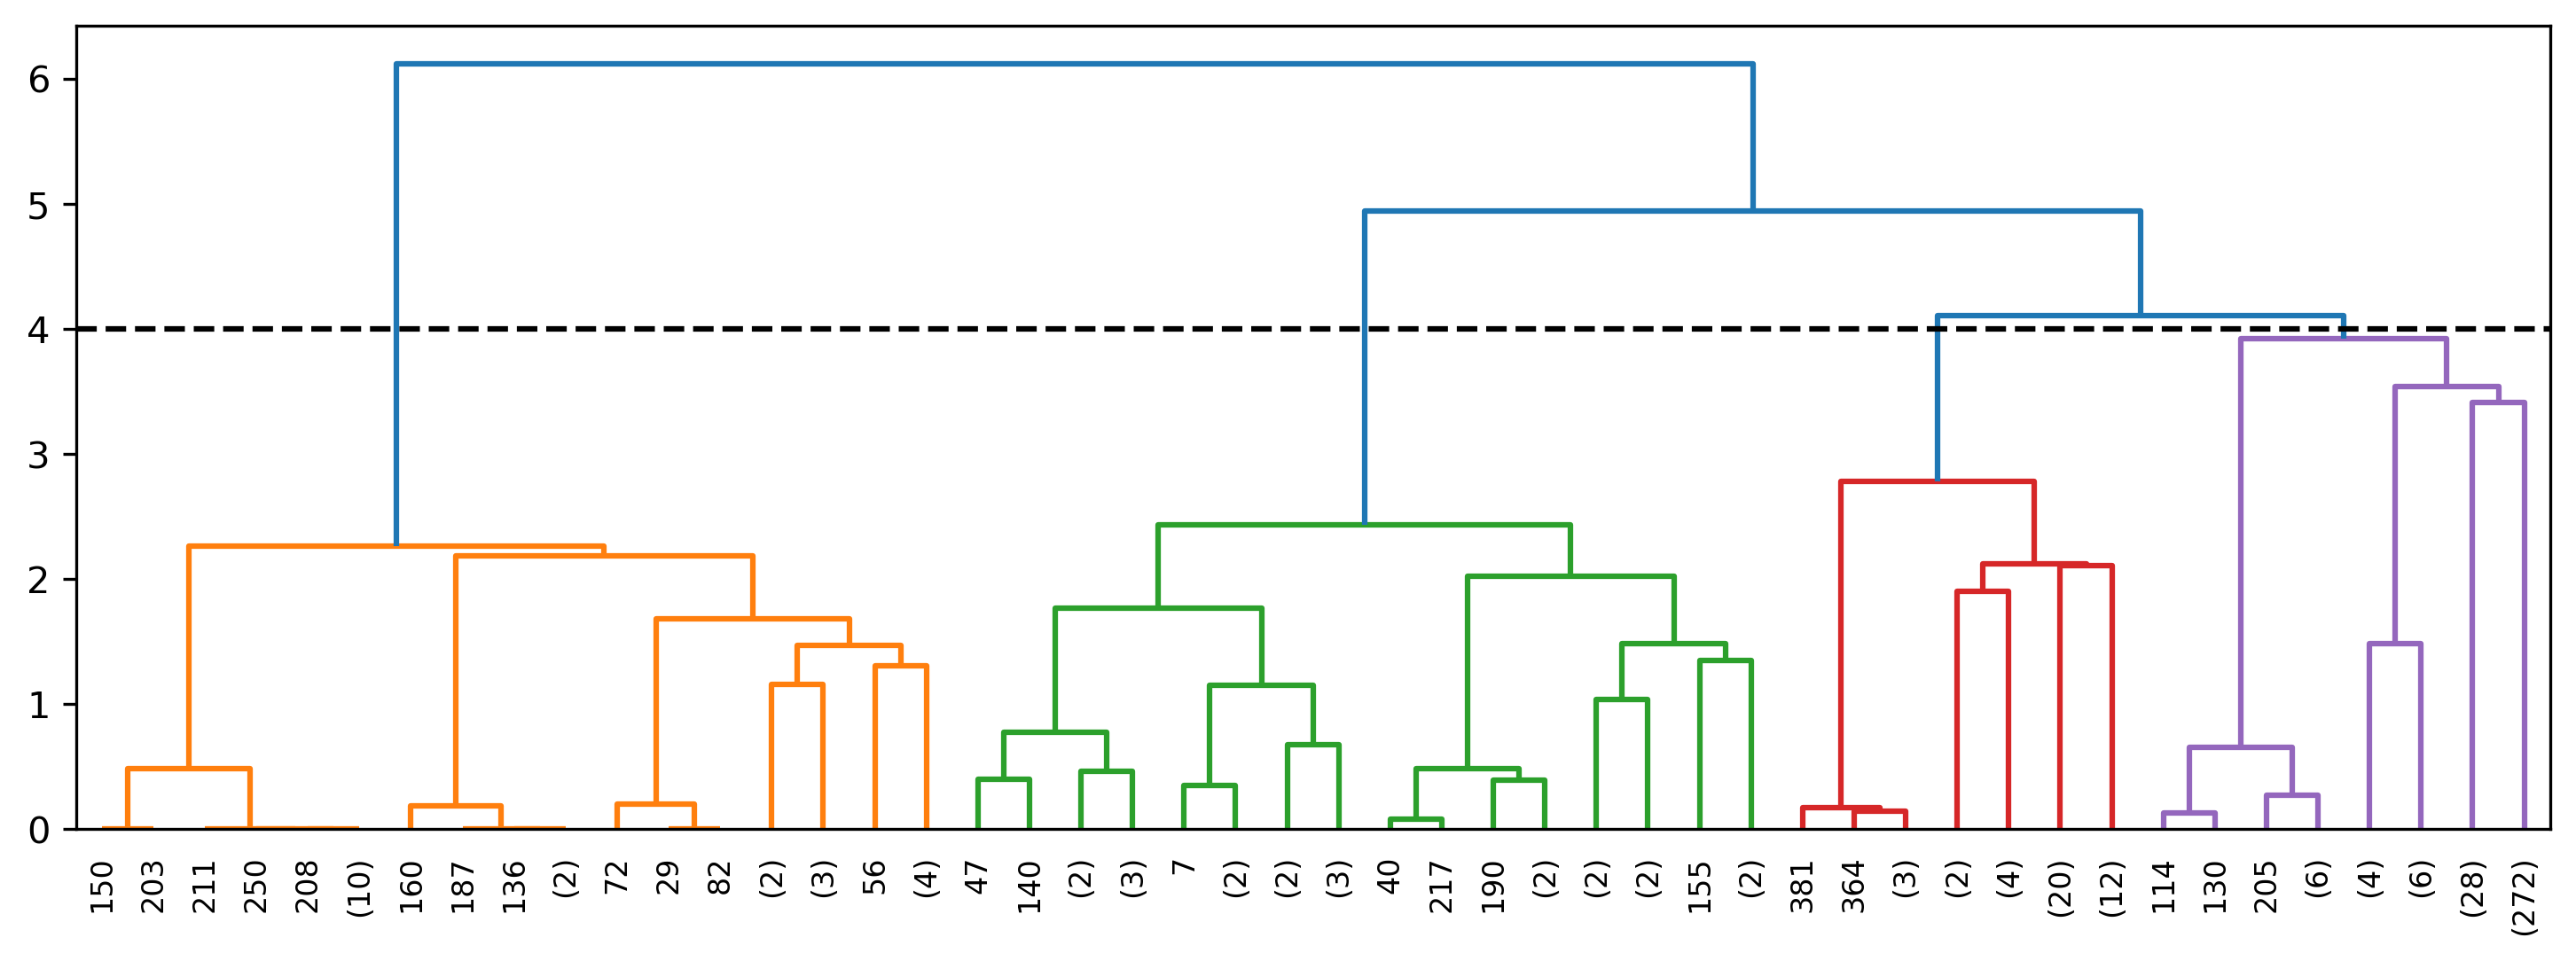

In [36]:


t = plot_dendrogram(X_cong_p_new, method='ward', p=5, thresh=4)

In [37]:




def plot_fcluster(X_transformed, thresh, x_axis, y_axis, title, method='ward', criterion='distance', show=True):
    from scipy.cluster.hierarchy import fcluster
    from scipy.cluster.hierarchy import linkage
    Z = linkage(X_transformed, method=method)
   

    y_predict_pass = fcluster(Z, t=thresh, criterion='distance')
    plt.scatter(X_transformed[:, x_axis], X_transformed[:, y_axis], c=y_predict_pass)
    plt.xlabel(f'SV{x_axis+1}')
    plt.ylabel(f'SV{y_axis+1}')
    plt.title(title)
    if show:
        plt.show()
    else:
        plt.close()
    return y_predict_pass

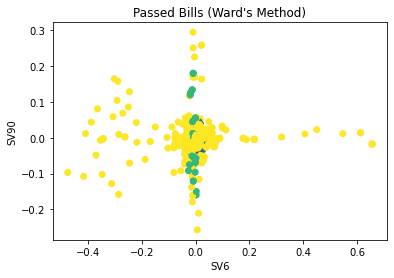

In [38]:


y_pred = plot_fcluster(X_cong_p_new, t, 5, 89, 'Passed Bills (Ward\'s Method)')

In [39]:


y_pred

array([4, 4, 4, 1, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 1, 4,
       2, 4, 4, 4, 4, 4, 4, 1, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4,
       4, 4, 4, 2, 1, 4, 4, 4, 4, 2, 4, 4, 1, 4, 4, 4, 1, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 2, 4, 1, 4, 2, 4, 4, 4, 2, 4, 4, 2, 1, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 2, 4, 4, 2, 4, 4, 1, 4, 4, 4, 1, 4,
       3, 4, 4, 1, 4, 3, 3, 1, 4, 4, 4, 4, 4, 1, 2, 4, 4, 1, 4, 4, 4, 4,
       4, 2, 4, 4, 1, 4, 4, 4, 2, 4, 1, 4, 4, 4, 2, 4, 1, 4, 1, 1, 4, 4,
       4, 2, 4, 3, 4, 4, 1, 2, 1, 4, 4, 4, 4, 1, 4, 4, 4, 1, 4, 4, 4, 4,
       1, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 2, 4, 4, 4, 4, 4, 4, 2,
       1, 2, 4, 4, 4, 1, 4, 4, 2, 2, 1, 4, 4, 1, 2, 3, 4, 4, 4, 2, 4, 3,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 3, 4, 4, 4, 4, 4, 4,
       3, 3, 3, 3, 4, 1, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 2, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,

Assigning each bill a cluster label...

In [40]:


df_passed['cluster_label'] = y_pred
df_passed

house_bill_number                                              title  \
0              HB00001  AN ACT INSTITUTIONALIZING A NATIONAL VALUES, E...   
5              HB00006  AN ACT PROVIDING FOR ADDITIONAL SUPPORT AND CO...   
9              HB00010  AN ACT DECLARING THE COCONUT LEVY ASSETS AS A ...   
46             HB00047  AN ACT POSTPONING THE MAY 2020 BARANGAY AND SA...   
165            HB00166  AN ACT ESTABLISHING THE COCONUT FARMERS AND IN...   
...                ...                                                ...   
8712           HB08725  AN ACT GRANTING THE HIGHLAND BROADCASTING NETW...   
8847           HB08860  AN ACT\r\nGRANTING HIGHLAND BROADCASTING NETWO...   
8915           HB08928  AN ACT\r\nESTABLISHING THE PHILIPPINE ENERGY R...   
9298           HB09312  AN ACT REMOVING THE EXPIRATION PERIOD OF THE J...   
9473           HB09487  AN ACT \r\nENHANCING THE POWERS AND FUNCTIONS ...   

     significance  date_filed  \
0        NATIONAL  2019-07-01   
5        NATIONAL  2019-07-01   
9        NATIONAL  2019-07-01   
46       NATIONAL  2019-07-01   
165      NATIONAL  2019-07-01   
...           ...         ...   
8712        LOCAL  2021-02-15   
8847        LOCAL  2021-03-02   
8915     NATIONAL  2021-03-08   
9298     NATIONAL  2021-05-09   
9473     NATIONAL  2021-05-26   

                                      principal_authors   date_read  \
0     CAYETANO, ALAN PETER "COMPAÑERO" S.; MADRONA. ...  2019-07-23   
5                   CAYETANO, ALAN PETER "COMPAÑERO" S.  2019-07-23   
9                   CAYETANO, ALAN PETER "COMPAÑERO" S.  2019-07-23   
46                             DY, FAUSTINO "INNO" V A.  2019-07-23   
165                     TAN, ANGELINA "HELEN" D.L. M.D.  2019-07-23   
...                                                 ...         ...   
8712    ZUBIRI, MANUEL F.; ACOSTA-ALBA, MARIA LOURDES;   2021-02-17   
8847  ZUBIRI, MANUEL F.; ACOSTA-ALBA, MARIA LOURDES;...  2021-03-02   
8915  VELASCO, LORD ALLAN JAY Q.; VIOLAGO, MICAELA S...  2021-03-08   
9298                      MACAPAGAL ARROYO, JUAN MIGUEL  2021-05-18   
9473  MACAPAGAL ARROYO, JUAN MIGUEL; DE JESUS, PRESL...  2021-05-26   

                    primary_referral  \
0        BASIC EDUCATION AND CULTURE   
5                     APPROPRIATIONS   
9               AGRICULTURE AND FOOD   
46    SUFFRAGE AND ELECTORAL REFORMS   
165             AGRICULTURE AND FOOD   
...                              ...   
8712          LEGISLATIVE FRANCHISES   
8847          LEGISLATIVE FRANCHISES   
8915                          ENERGY   
9298                          ENERGY   
9473                          ENERGY   

                              mother_bill_status  \
0     Republic Act RA11476 enacted on 2020-06-25   
5     Republic Act RA11466 enacted on 2020-01-08   
9     Republic Act RA11524 enacted on 2021-02-26   
46    Republic Act RA11462 enacted on 2019-12-03   
165   Republic Act RA11524 enacted on 2021-02-26   
...                                          ...   
8712  Republic Act RA11542 enacted on 2021-05-18   
8847                                         NaN   
8915                                         NaN   
9298  Republic Act RA11571 enacted on 2021-07-06   
9473                                         NaN   

                                          status pass_or_not  cluster_label  
0                         Substituted by HB05829      passed              4  
5                      Consolidated into HB05712      passed              4  
9                         Substituted by HB08136      passed              4  
46                        Substituted by HB04933      passed              1  
165                       Substituted by HB08136      passed              4  
...                                          ...         ...            ...  
8712                      Substituted by HB08860      passed              3  
8847  Republic Act RA11542 enacted on 2021-05-18      passed              3  
8915  Republic Act RA1

### Distribution of passed bills in each cluster

In [41]:


df_passed['cluster_label'].value_counts().sort_index()

1     33
2     27
3     43
4    319
Name: cluster_label, dtype: int64

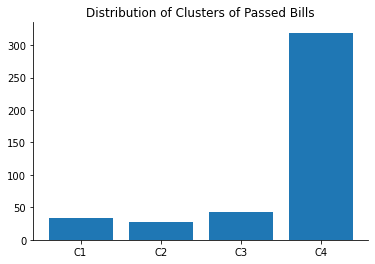

In [128]:
fig, ax = plt.subplots()
ax.bar(x=[f'C{i}' for i in df_passed['cluster_label'].value_counts().sort_index().index], height=df_passed['cluster_label'].value_counts().sort_index())
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title('Distribution of Clusters of Passed Bills')
plt.show()

### Cluster 1 analysis

In [43]:




idx_c1 = df_passed[df_passed.cluster_label == 1].index
idx_c1

Int64Index([  46,  395,  419,  622,  902, 1024, 1066, 1347, 1564, 2053, 2168,
            2269, 2379, 2476, 2524, 2601, 2720, 2867, 2881, 2883, 3029, 3092,
            3179, 3260, 3308, 3492, 3507, 3662, 3928, 3950, 4033, 4597, 4673],
           dtype='int64')

In [44]:


df_passed.loc[idx_c1,'title']

46      AN ACT POSTPONING THE MAY 2020 BARANGAY AND SA...
395     AN ACT POSTPONING THE MAY 2020 BARANGAY AND SA...
419     AN ACT POSTPONING THE MAY 2020 BARANGAY AND SA...
622     AN ACT POSTPONING THE MAY 2020 BARANGAY AND SA...
902     AN ACT POSTPONING THE MAY 2020 BARANGAY AND SA...
1024    AN ACT POSTPONING THE DATE OF THE BARANGAY AND...
1066    AN ACT POSTPONING THE MAY 2020 SYNCHRONIZED BA...
1347    AN ACT POSTPONING THE MAY 2020 BARANGAY AND SA...
1564    AN ACT POSTPONING THE MAY 2020 BARANGAY AND SA...
2053    AN ACT POSTPONING THE MAY 2020 BARANGAY AND SA...
2168    AN ACT POSTPONING THE MAY 2020 BARANGAY AND SA...
2269    AN ACT POSTPONING THE MAY 2020 BARANGAY AND SA...
2379    AN ACT POSTPONING THE MAY 2020 BARANGAY AND SA...
2476    AN ACT PROVIDING FOR THE POSTPONMENT OF THE MA...
2524    AN ACT POSTPONING THE MAY 2020 BARANGAY AND SA...
2601    AN ACT POSTPONING THE MAY 2020 BARANGAY AND SA...
2720    AN ACT POSTPONING THE MAY 2020 BARANGAY AND SA...
2867    AN ACT

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

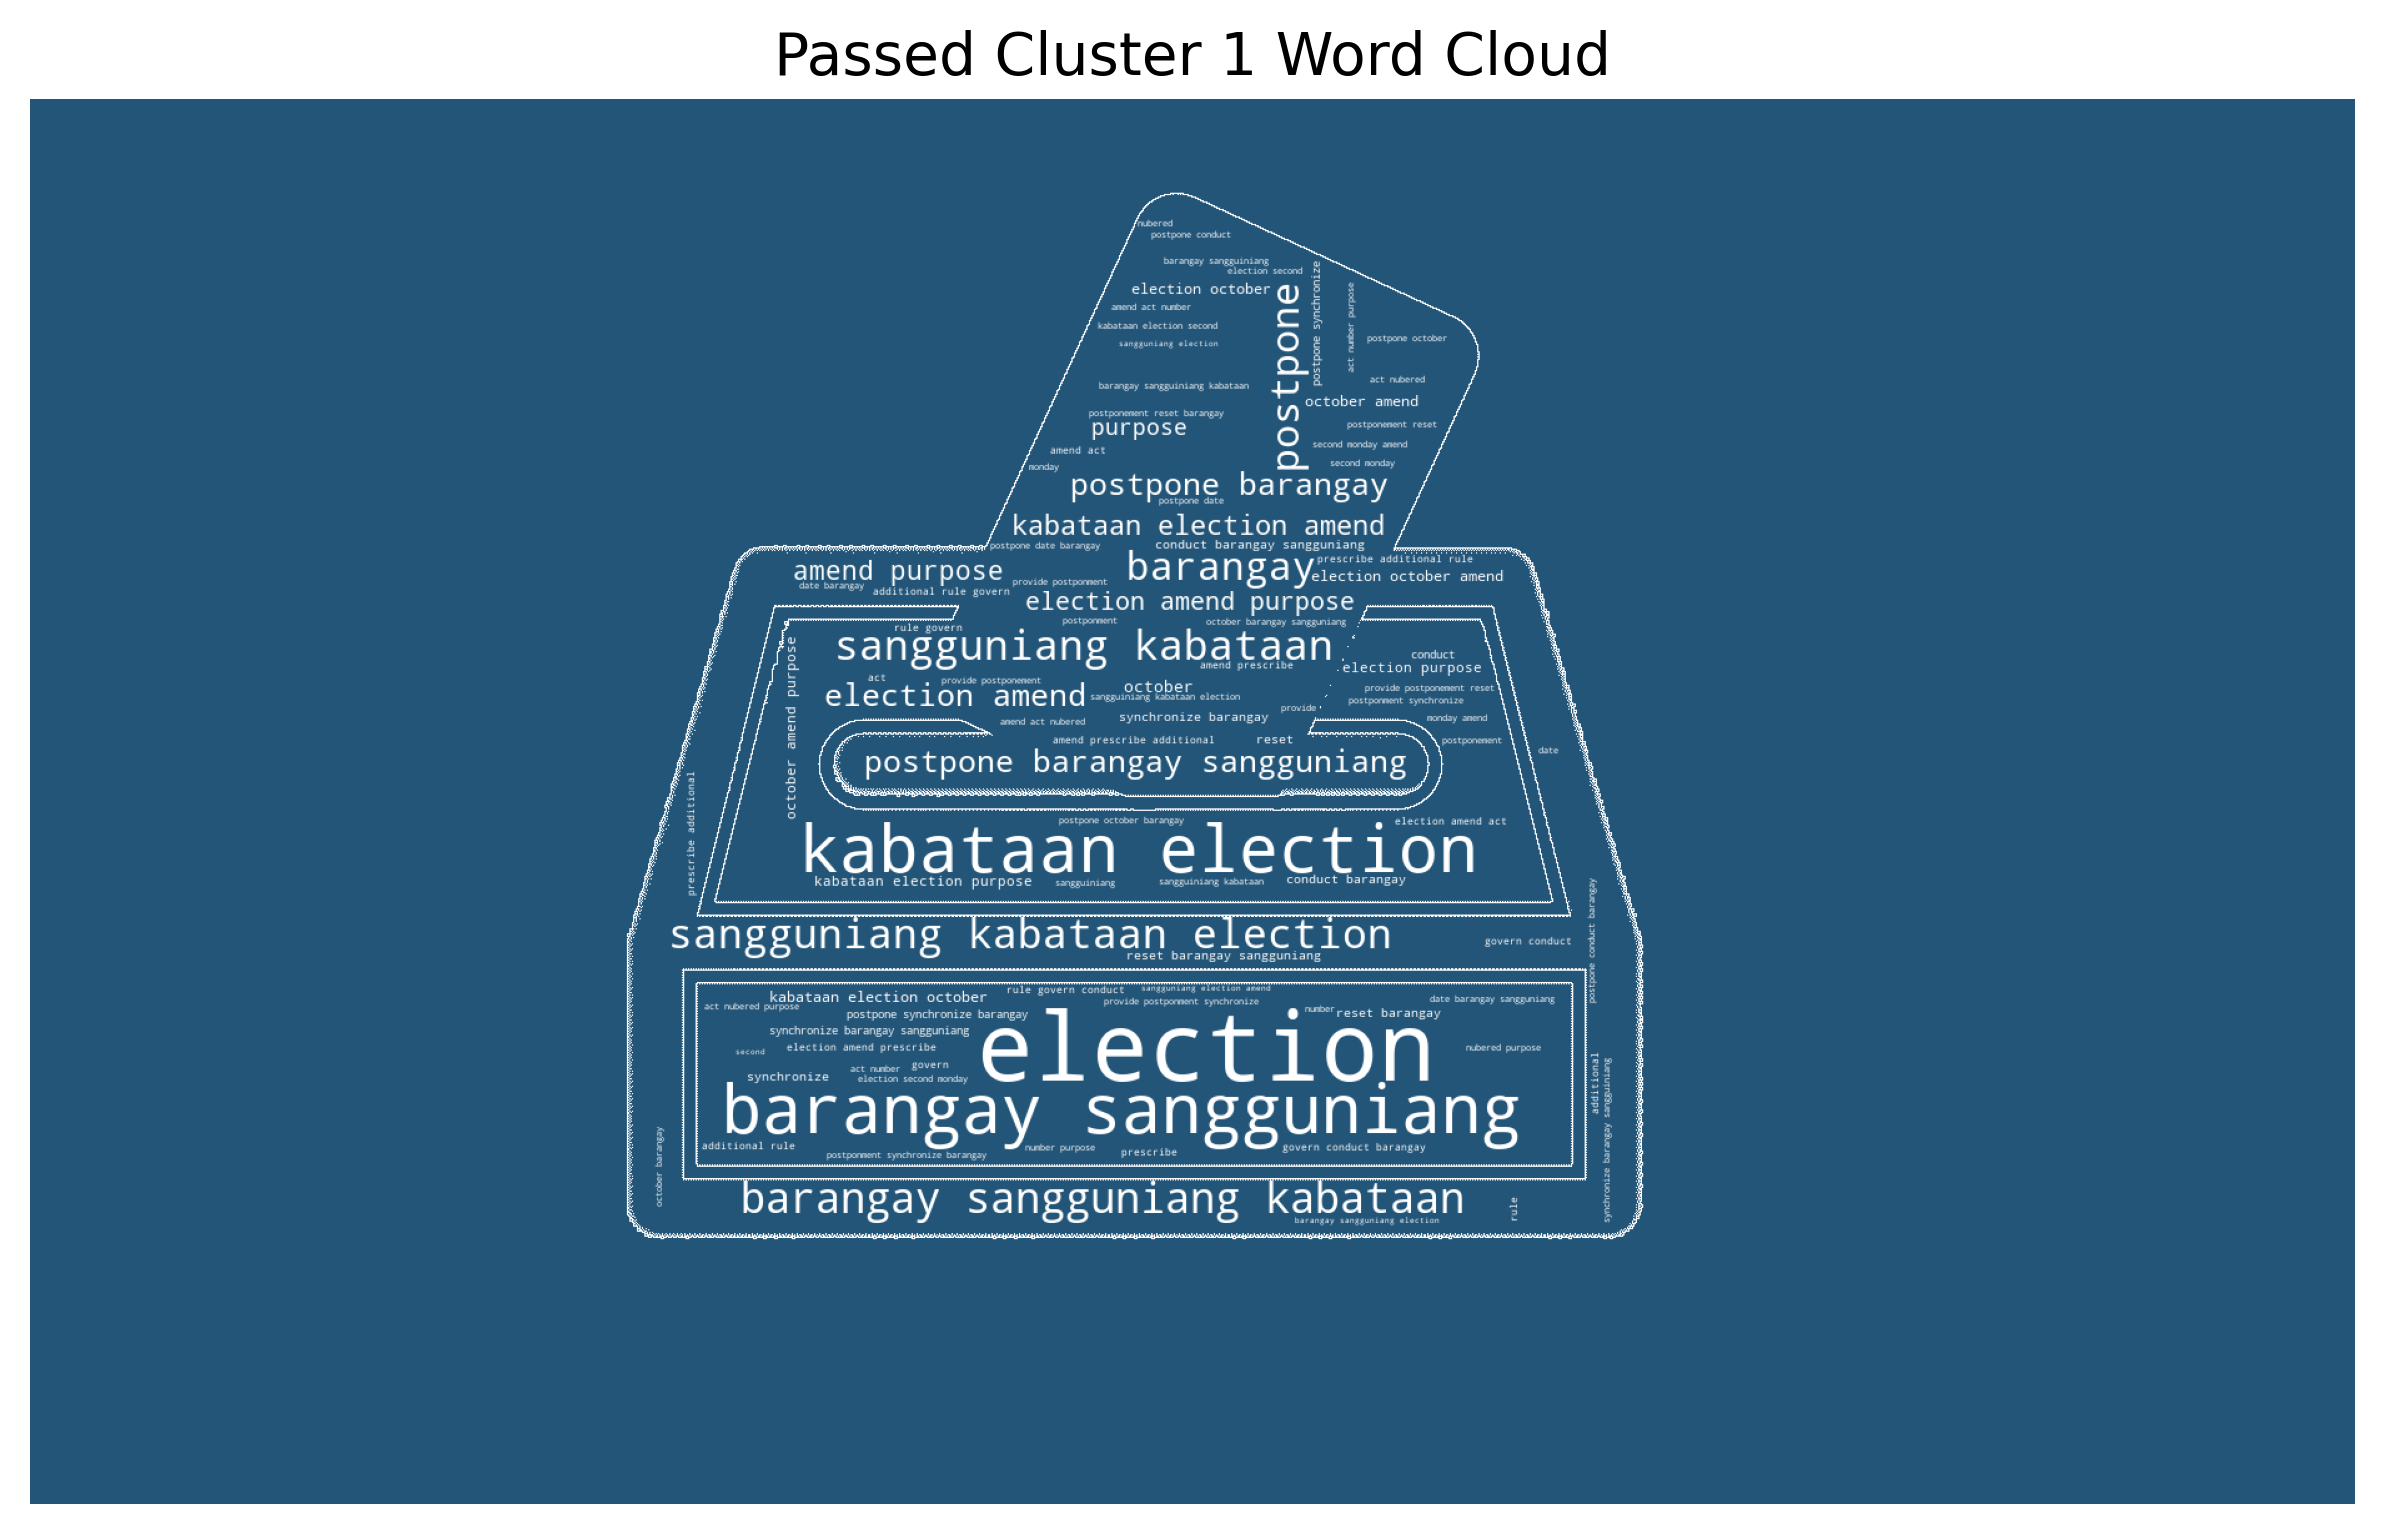

In [45]:


drop_c1 = ['amend', 'sangguniang', 'kabataan']
ser_c1 = (pd.DataFrame(bow_cong_p.todense(),
                       columns=cols_p,
                       index=df_passed.index)
          .loc[idx_c1,:]
          .sum(axis=0).sort_values(ascending=False).drop(drop_c1, axis=0))

mask_elec = Image.open('election.png')
mask_elec = np.array(mask_elec.convert('1'))
transformed_mask = np.ndarray((mask_elec.shape[0], mask_elec.shape[1]),
                              np.int32)
display(mask_elec)
for i in range(len(mask_elec)):
    transformed_mask[i] = list(map(transform_format, mask_elec[i]))
wordcloud_plotting(ser_c1, 
                   ListedColormap(['white']), 
                   'Passed Cluster 1 Word Cloud', mask=transformed_mask)

In [46]:

# temp=Image.open('THIS.bmp') 
# temp=temp.convert('1')      # Convert to black&white 
# A = array(temp)             # Creates an array, white pixels==True and black pixels==False 
# new_A=empty((A.shape[0],A.shape[1]),None)    #New array with same size as A 
 
# for i in range(len(A)): 
#     for j in range(len(A[i])): 
#         if A[i][j]==True: 
#             new_A[i][j]=0 
#         else: 
#             new_A[i][j]=1 

In [47]:


cleaned_titles_p.loc[idx_c1,:]['stemmed_text'].tolist()

['postpone barangay sangguniang kabataan election amend purpose',
 'postpone barangay sangguniang kabataan election amend purpose',
 'postpone barangay sangguniang kabataan election amend purpose',
 'postpone barangay sangguniang kabataan election amend prescribe additional rule govern conduct barangay sangguniang kabataan election purpose',
 'postpone barangay sangguniang kabataan election october amend purpose',
 'postpone date barangay sangguniang kabataan election second monday amend',
 'postpone synchronize barangay sangguniang kabataan election amend',
 'postpone barangay sangguniang election amend prescribe additional rule govern conduct barangay sangguniang kabataan election purpose',
 'postpone barangay sangguniang kabataan election amend prescribe additional rule govern conduct barangay sangguniang kabataan election purpose',
 'postpone barangay sangguniang kabataan election amend purpose',
 'postpone barangay sangguniang kabataan election amend purpose',
 'postpone barangay 

### Cluster 2 Analysis

In [48]:


idx_c2 = df_passed[df_passed.cluster_label == 2].index
idx_c2

Int64Index([ 195,  495,  640,  751,  884,  956, 1289, 1403, 1493, 1552, 1888,
            1935, 2021, 2502, 2574, 2696, 2847, 2986, 3088, 3531, 3647, 3668,
            3946, 3947, 4040, 4140, 5490],
           dtype='int64')

In [49]:


df_passed.loc[idx_c2, 'title'].values

array(['AN ACT UPGRADING THE MINIMUM MONTHLY SALARY OF PUBLIC SCHOOL TEACHERS AND NON-TEACHING PERSONNEL FROM SALARY GRADE 11 TO SALARY GRADE 20, AND FROM SALARY GRADE 1 TO SALARY GRADE 8, RESPECTIVELY, AND APPROPRIATING FUNDS THEREFOR',
       'AN ACT INCREASING THE SALARY GRADE OF PUBLIC SCHOOL TEACHERS FROM SALARY GRADE 11 TO 20 AND PROVIDING FUNDS THEREOF',
       'AN ACT UPGRADING THE MINIMUM SALARY GRADE OF PUBLIC SCHOOL TEACHERS FROM SALARY GRADE 11 TO SALARY GRADE 15',
       'AN ACT UPGRADING THE MINIMUM SALARY GRADE LEVEL OF TEACHERS FROM SALARY GRADE 11 TO SALARY GRADE 19',
       'AN ACT INCREASING THE MINIMUM SALARY GRADE OF PUBLIC SCHOOL TEACHERS FROM SALARY GRADE 11 TO 20 AND PROVIDING FUNDS THEREFOR',
       'AN ACT INCREASING THE MINIMUM SALARY OF PUBLIC SCHOOL TEACHERS FROM SALARY GRADE 11 TO SALARY GRADE 15',
       'AN ACT UPGRADING THE MINIMUM SALARY GRADE OF GOVERNMENT DOCTORS FROM SALARY GRADE 16 TO 24',
       'AN ACT UPGRADING THE MINIMUM SALARY GRADE LEVEL OF 

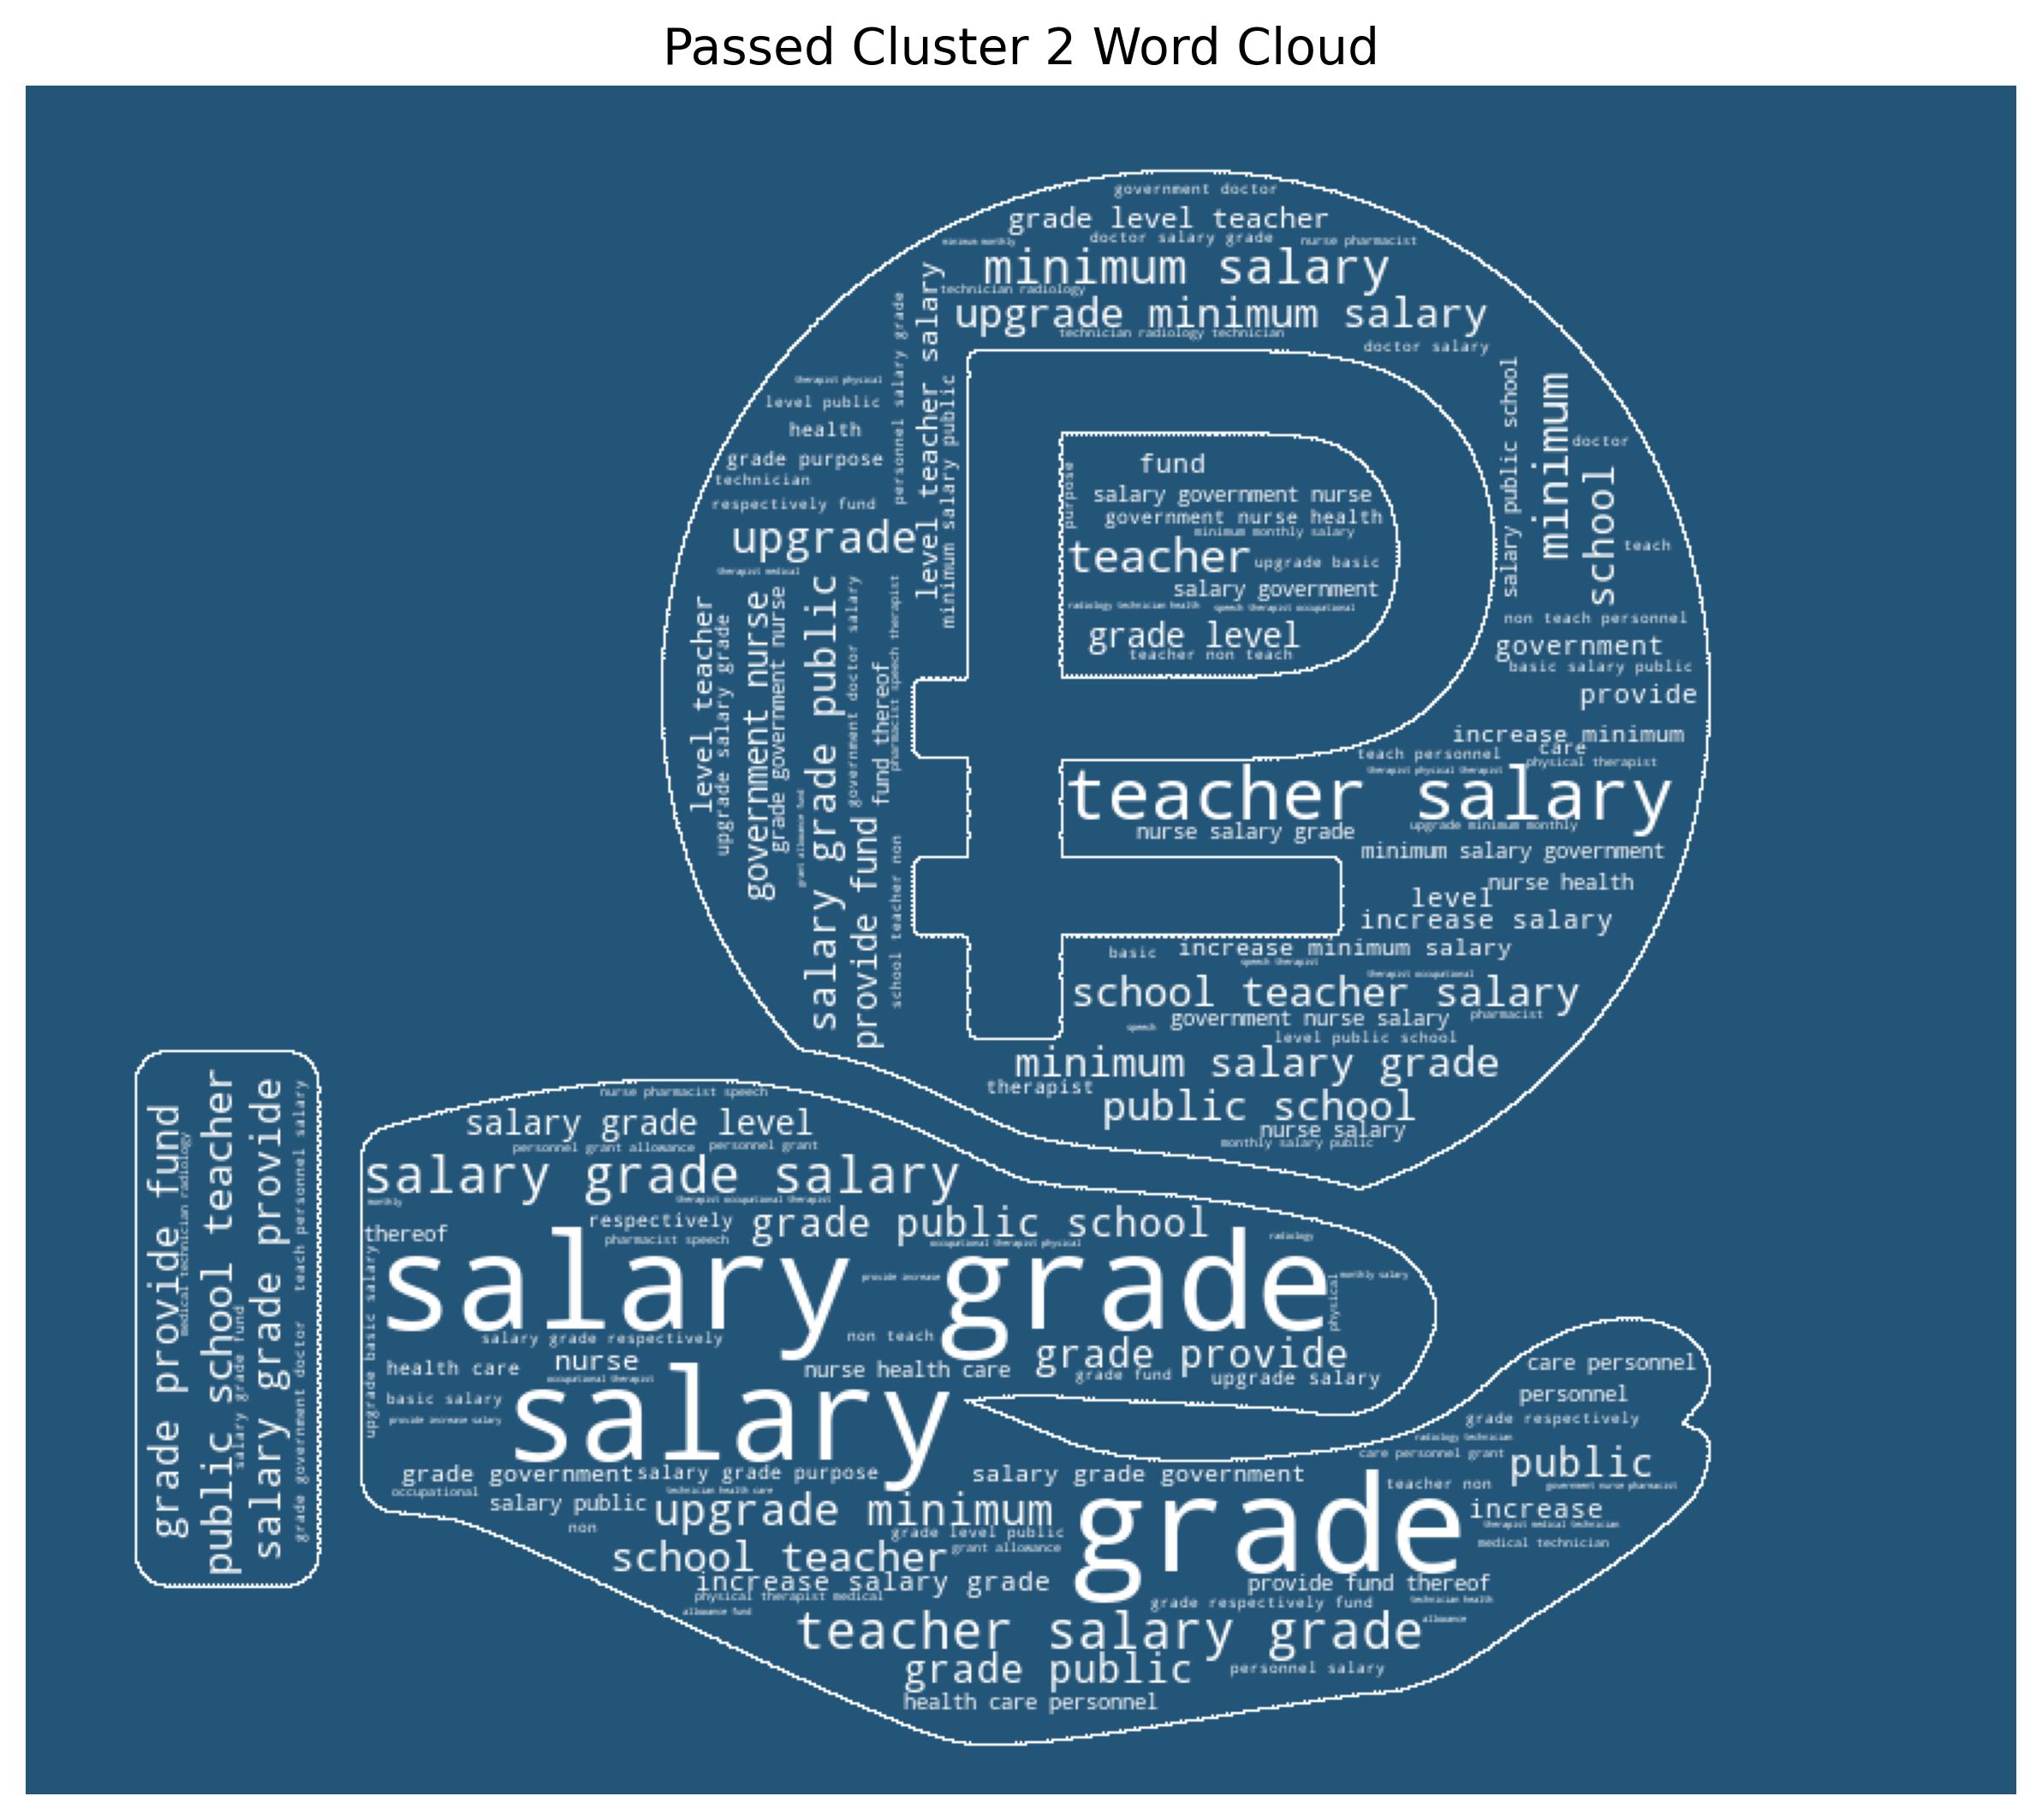

In [50]:


drop_c2 = ['grade salary', 'grade salary grade']
ser_c2 = (pd.DataFrame(bow_cong_p.todense(),
                       columns=cols_p,
                       index=df_passed.index)
          .loc[idx_c2,:]
          .sum(axis=0).sort_values(ascending=False).drop(drop_c2, axis=0))

mask_salary = Image.open('salary.jpg')
mask_salary = np.array(mask_salary.convert('1'))
transformed_mask = np.ndarray((mask_salary.shape[0], mask_salary.shape[1]),
                              np.int32)


for i in range(len(mask_salary)):
    transformed_mask[i] = list(map(transform_format, mask_salary[i]))

wordcloud_plotting(ser_c2, 
                   ListedColormap(['white']), 
                   'Passed Cluster 2 Word Cloud', mask=transformed_mask)

In [51]:
cleaned_titles_p.loc[idx_c2,:]['stemmed_text'].tolist()

['upgrade minimum monthly salary public school teacher non teach personnel salary grade salary grade salary grade salary grade respectively fund',
 'increase salary grade public school teacher salary grade provide fund thereof',
 'upgrade minimum salary grade public school teacher salary grade salary grade',
 'upgrade minimum salary grade level teacher salary grade salary grade',
 'increase minimum salary grade public school teacher salary grade provide fund',
 'increase minimum salary public school teacher salary grade salary grade',
 'upgrade minimum salary grade government doctor salary grade',
 'upgrade minimum salary grade level teacher salary grade',
 'upgrade salary grade public school teacher non teach personnel salary grade salary grade salary grade salary grade respectively fund',
 'upgrade minimum salary grade level teacher salary grade purpose',
 'increase salary grade public school teacher salary grade salary grade provide fund thereof',
 'upgrade minimum salary government

### Cluster 3 Analysis

In [52]:
idx_c3 = df_passed[df_passed.cluster_label == 3].index
idx_c3

Int64Index([2220, 2317, 2354, 2997, 3392, 4046, 4153, 4393, 4454, 4572, 4573,
            4574, 4575, 5480, 6240, 6245, 6336, 6340, 6668, 6737, 6906, 6907,
            7043, 7087, 7164, 7321, 7403, 7474, 7475, 7483, 7514, 7518, 7602,
            7603, 7604, 7605, 8538, 8539, 8540, 8541, 8543, 8712, 8847],
           dtype='int64')

In [53]:
df_passed.loc[idx_c3, 'title'].values

array(['AN ACT RENEWING THE FRANCHISE GRANTED TO CRUSADERS BROADCASTING SYSTEM, INC. UNDER REPUBLIC ACT NO. 8091',
       'AN ACT RENEWING THE FRANCHISE GRANTED TO BICOL BROADCASTING SYSTEMS, INC. (UNDER REPUBLIC ACT         NO. 8092 ENTITLED ꞌAN ACT GRANTING THE BICOL BROADCASTING SYSTEMS, INC. (BBSI) A FRANCHISE TO ESTABLISH, OPERATE AND MAINTAIN COMMERCIAL RADIO AND TELEVISION BROADCASTING STATIONS IN REGION Vꞌ) − FOR ANOTHER TWENTY-FIVE (25) YEARS FROM THE EFFECTIVITY OF THIS ACT',
       'AN ACT RENEWING THE FRANCHISE GRANTED TO GOLD LABEL BROADCASTING SYSTEM, INC. UNDER REPUBLIC ACT NO. 8087 ENTITLED ꞌAN ACT GRANTING TO THE GOLD LABEL BROADCASTING SYSTEM, INC. A FRANCHISE TO ESTABLISH, MAINTAIN AND OPERATE RADIO AND TELEVISION BROADCASTING STATIONS IN DUMAGUETE AND OTHER AREAS IN THE VISAYAS AND MINDANAO WHERE FREQUENCIES AND/OR CHANNELS ARE STILL AVAILABLE FOR RADIO AND TELEVISION BROADCASTING FOR ANOTHER TWENTY-FIVE (25) YEARS FROM THE EFFECTIVITY OF THIS ACTꞌ',
       'AN ACT 

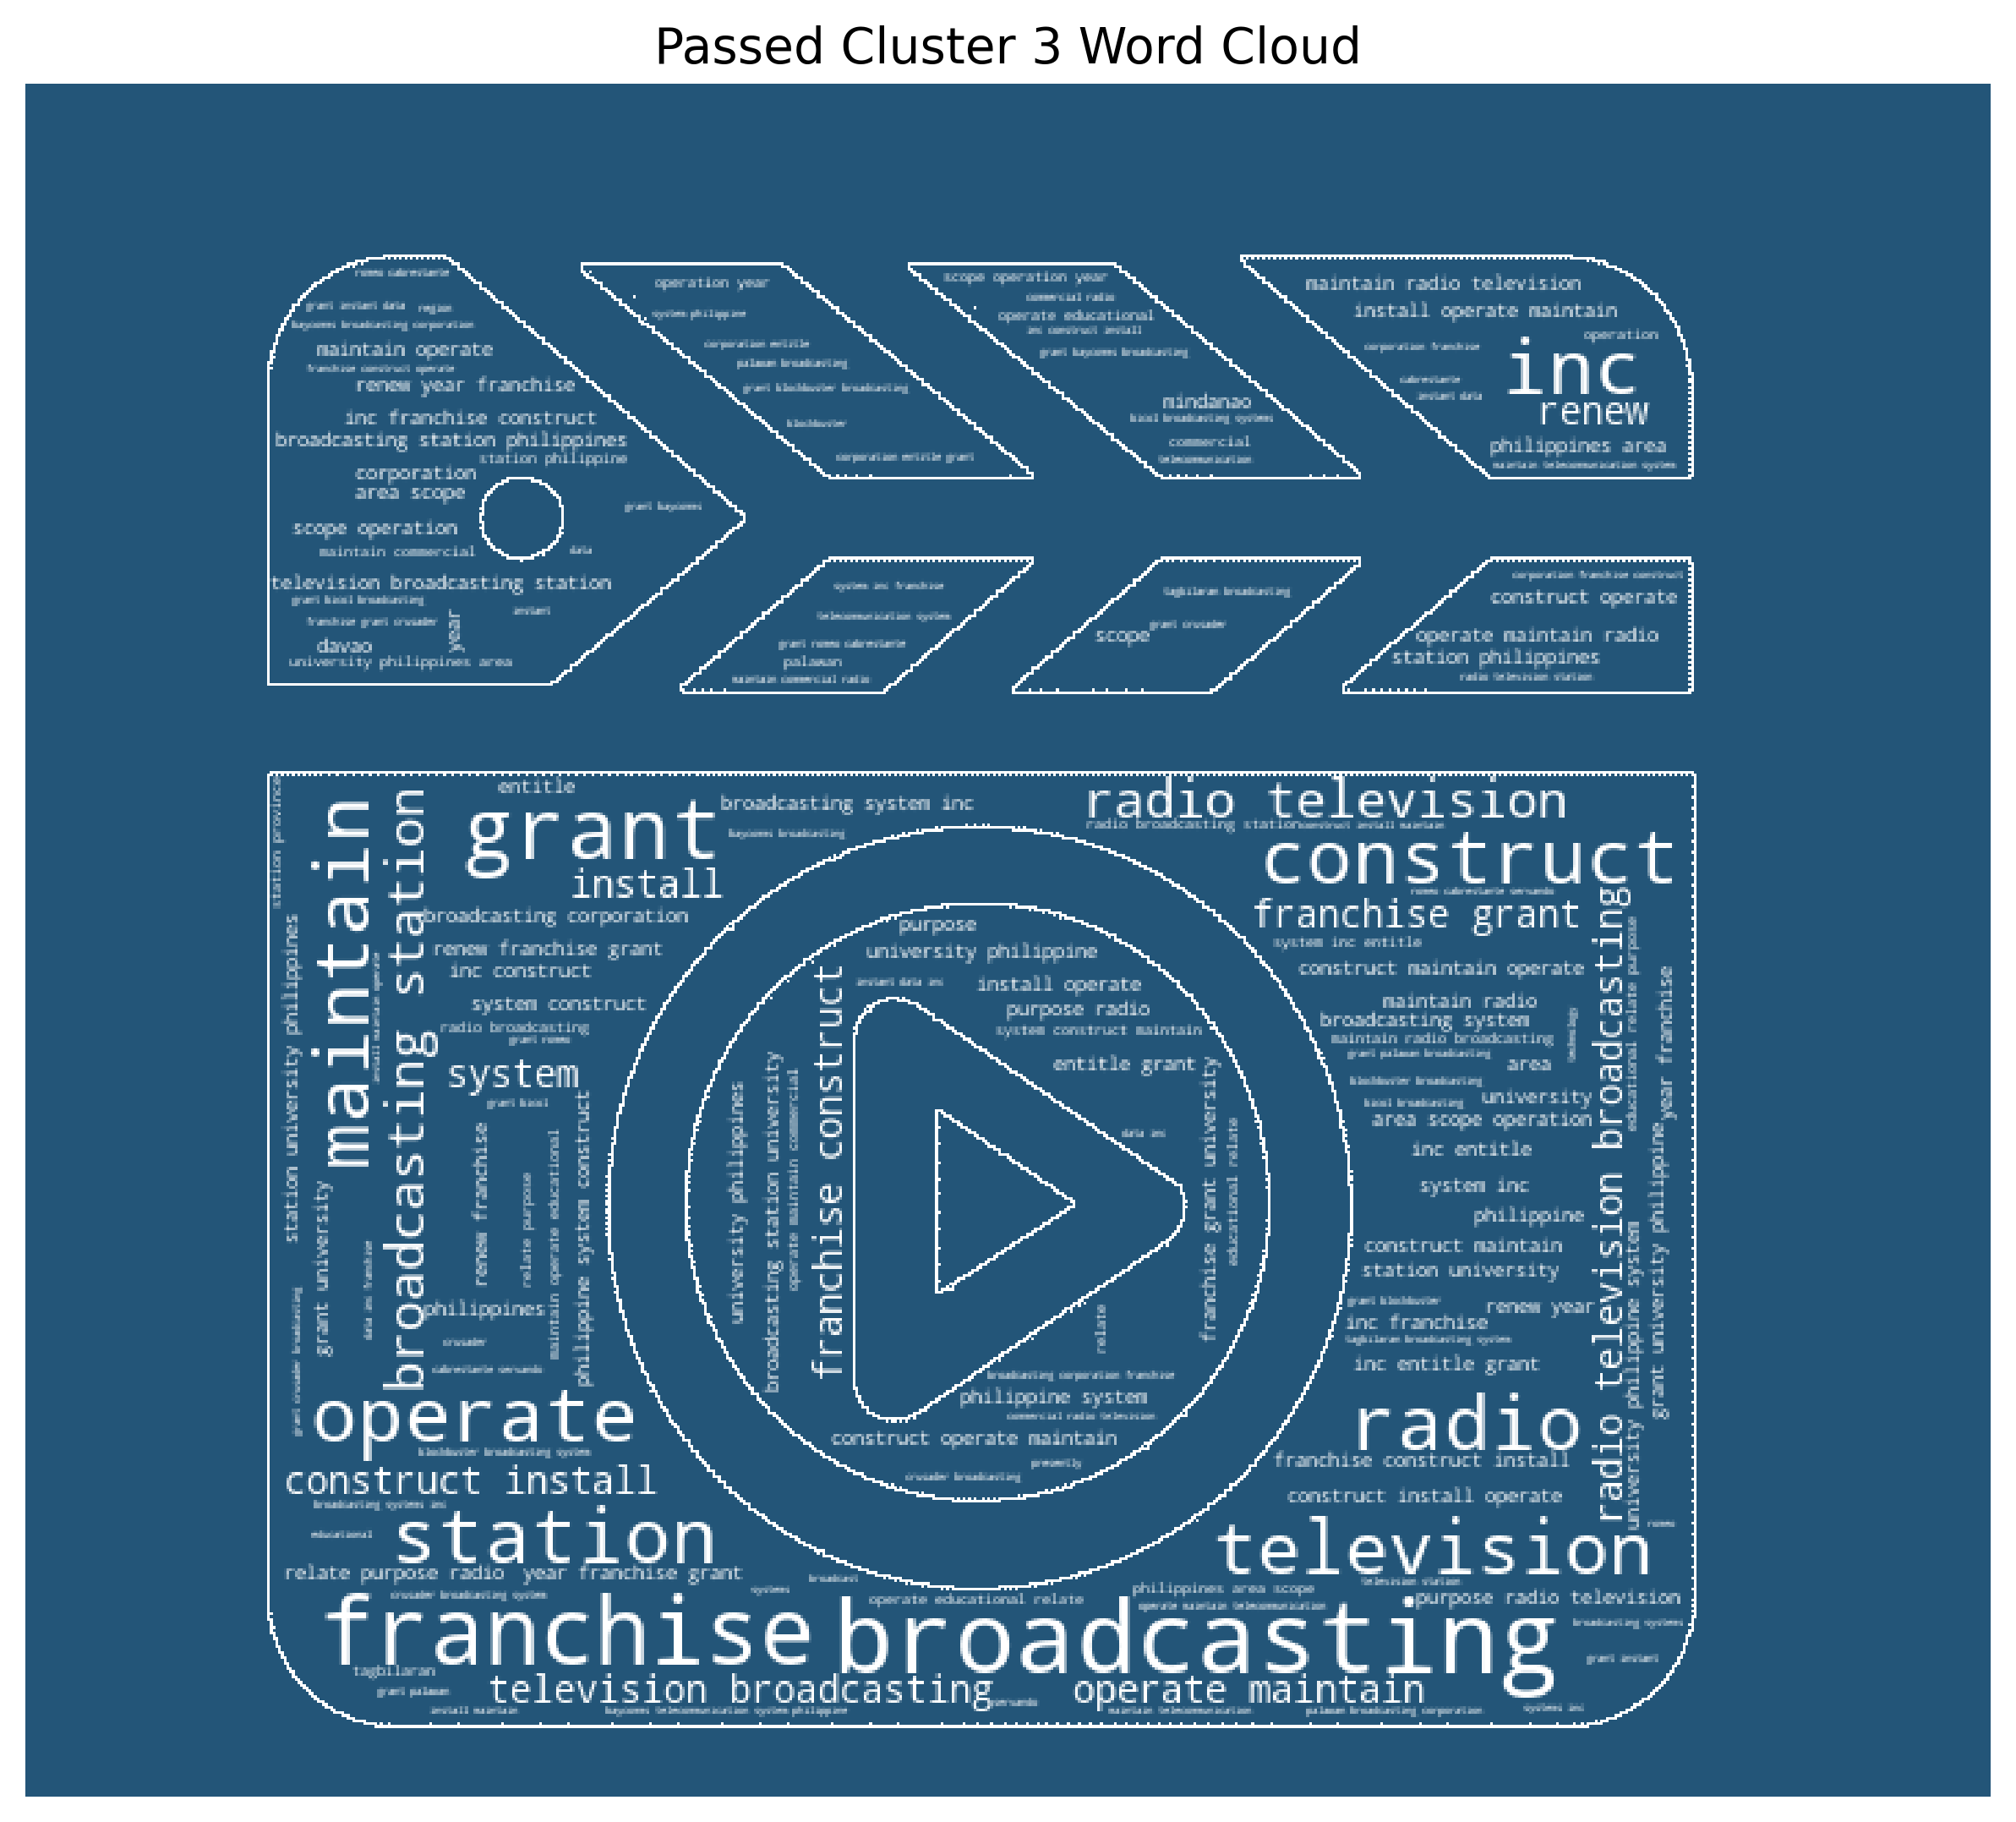

In [54]:
drop_c3 = ['high']
ser_c3 = (pd.DataFrame(bow_cong_p.todense(),
                       columns=cols_p,
                       index=df_passed.index)
          .loc[idx_c3,:]
          .sum(axis=0).sort_values(ascending=False).drop(drop_c3, axis=0))

mask_broad = Image.open('broadcast.jpg')
mask_broad = np.array(mask_broad.convert('1'))
transformed_mask = np.ndarray((mask_broad.shape[0], mask_broad.shape[1]),
                              np.int32)

for i in range(len(mask_broad)):
    transformed_mask[i] = list(map(transform_format, mask_broad[i]))

wordcloud_plotting(ser_c3, 
                   ListedColormap(['white']), 
                   'Passed Cluster 3 Word Cloud', mask=transformed_mask)

In [55]:
cleaned_titles_p.loc[idx_c3,:]['stemmed_text'].tolist()

['renew franchise grant crusader broadcasting system inc',
 'renew franchise grant bicol broadcasting systems inc entitle ꞌan grant bicol broadcasting systems inc bbsi franchise operate maintain commercial radio television broadcasting station region vꞌ − year effectivity',
 'renew franchise grant gold label broadcasting system inc entitle ꞌan grant gold label broadcasting system inc franchise maintain operate radio television broadcasting station dumaguete area visayas mindanao frequency channel available radio television broadcasting year effectivity actꞌ',
 'renew year franchise grant golden broadcast professional inc entitle franchise construct maintain operate station fm radio television broadcasting island mindanao purpose expand coverage entire philippine',
 'extend year franchise grant united broadcasting corporation fubc presently global satellite technology services inc amend number entitle grant united broadcasting corporation fubc franchise construct install operate maintai

### Cluster 4 Analysis

In [56]:
idx_c4 = df_passed[df_passed.cluster_label == 4].index
idx_c4

Int64Index([   0,    5,    9,  165,  175,  176,  198,  218,  246,  261,
            ...
            8304, 8373, 8409, 8618, 8619, 8635, 8636, 8915, 9298, 9473],
           dtype='int64', length=319)

In [57]:
df_passed.loc[idx_c4, 'title'].values

array(['AN ACT INSTITUTIONALIZING A NATIONAL VALUES, ETIQUETTE, AND MORAL UPRIGHTNESS PROGRAM',
       'AN ACT PROVIDING FOR ADDITIONAL SUPPORT AND COMPENSATION FOR EDUCATORS IN BASIC EDUCATION',
       'AN ACT DECLARING THE COCONUT LEVY ASSETS AS A TRUST FUND, PROVIDING FOR ITS MANAGEMENT AND UTILIZATION, AUTHORIZING THE PRIVATIZATION AND MANAGEMENT OFFICE TO DISPOSE THE COCONUT LEVY ASSETS, AND FOR OTHER PURPOSES',
       'AN ACT ESTABLISHING THE COCONUT FARMERS AND INDUSTRY DEVELOPMENT TRUST FUND AND PROVIDING FOR ITS MANAGEMENT AND UTILIZATION',
       'AN ACT AMENDING SECTIONS 4, 5, 20, 22, 27, 28, 34, 40, 50, 73, 112, 117, 204, 222, 237, 237-A, 255, 256, 257, 258, 260, 261, 262, 263, 264, 265, 266, 275, 288, 290 AND ADDING SECTIONS 6-A, 282-A, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 301-A, 301-B, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, AND 314 UNDER THE NATIONAL INTERNAL REVENUE CODE OF 1997, AS AMENDED, AND FOR OTHER PURPOSES',
       'AN ACT A

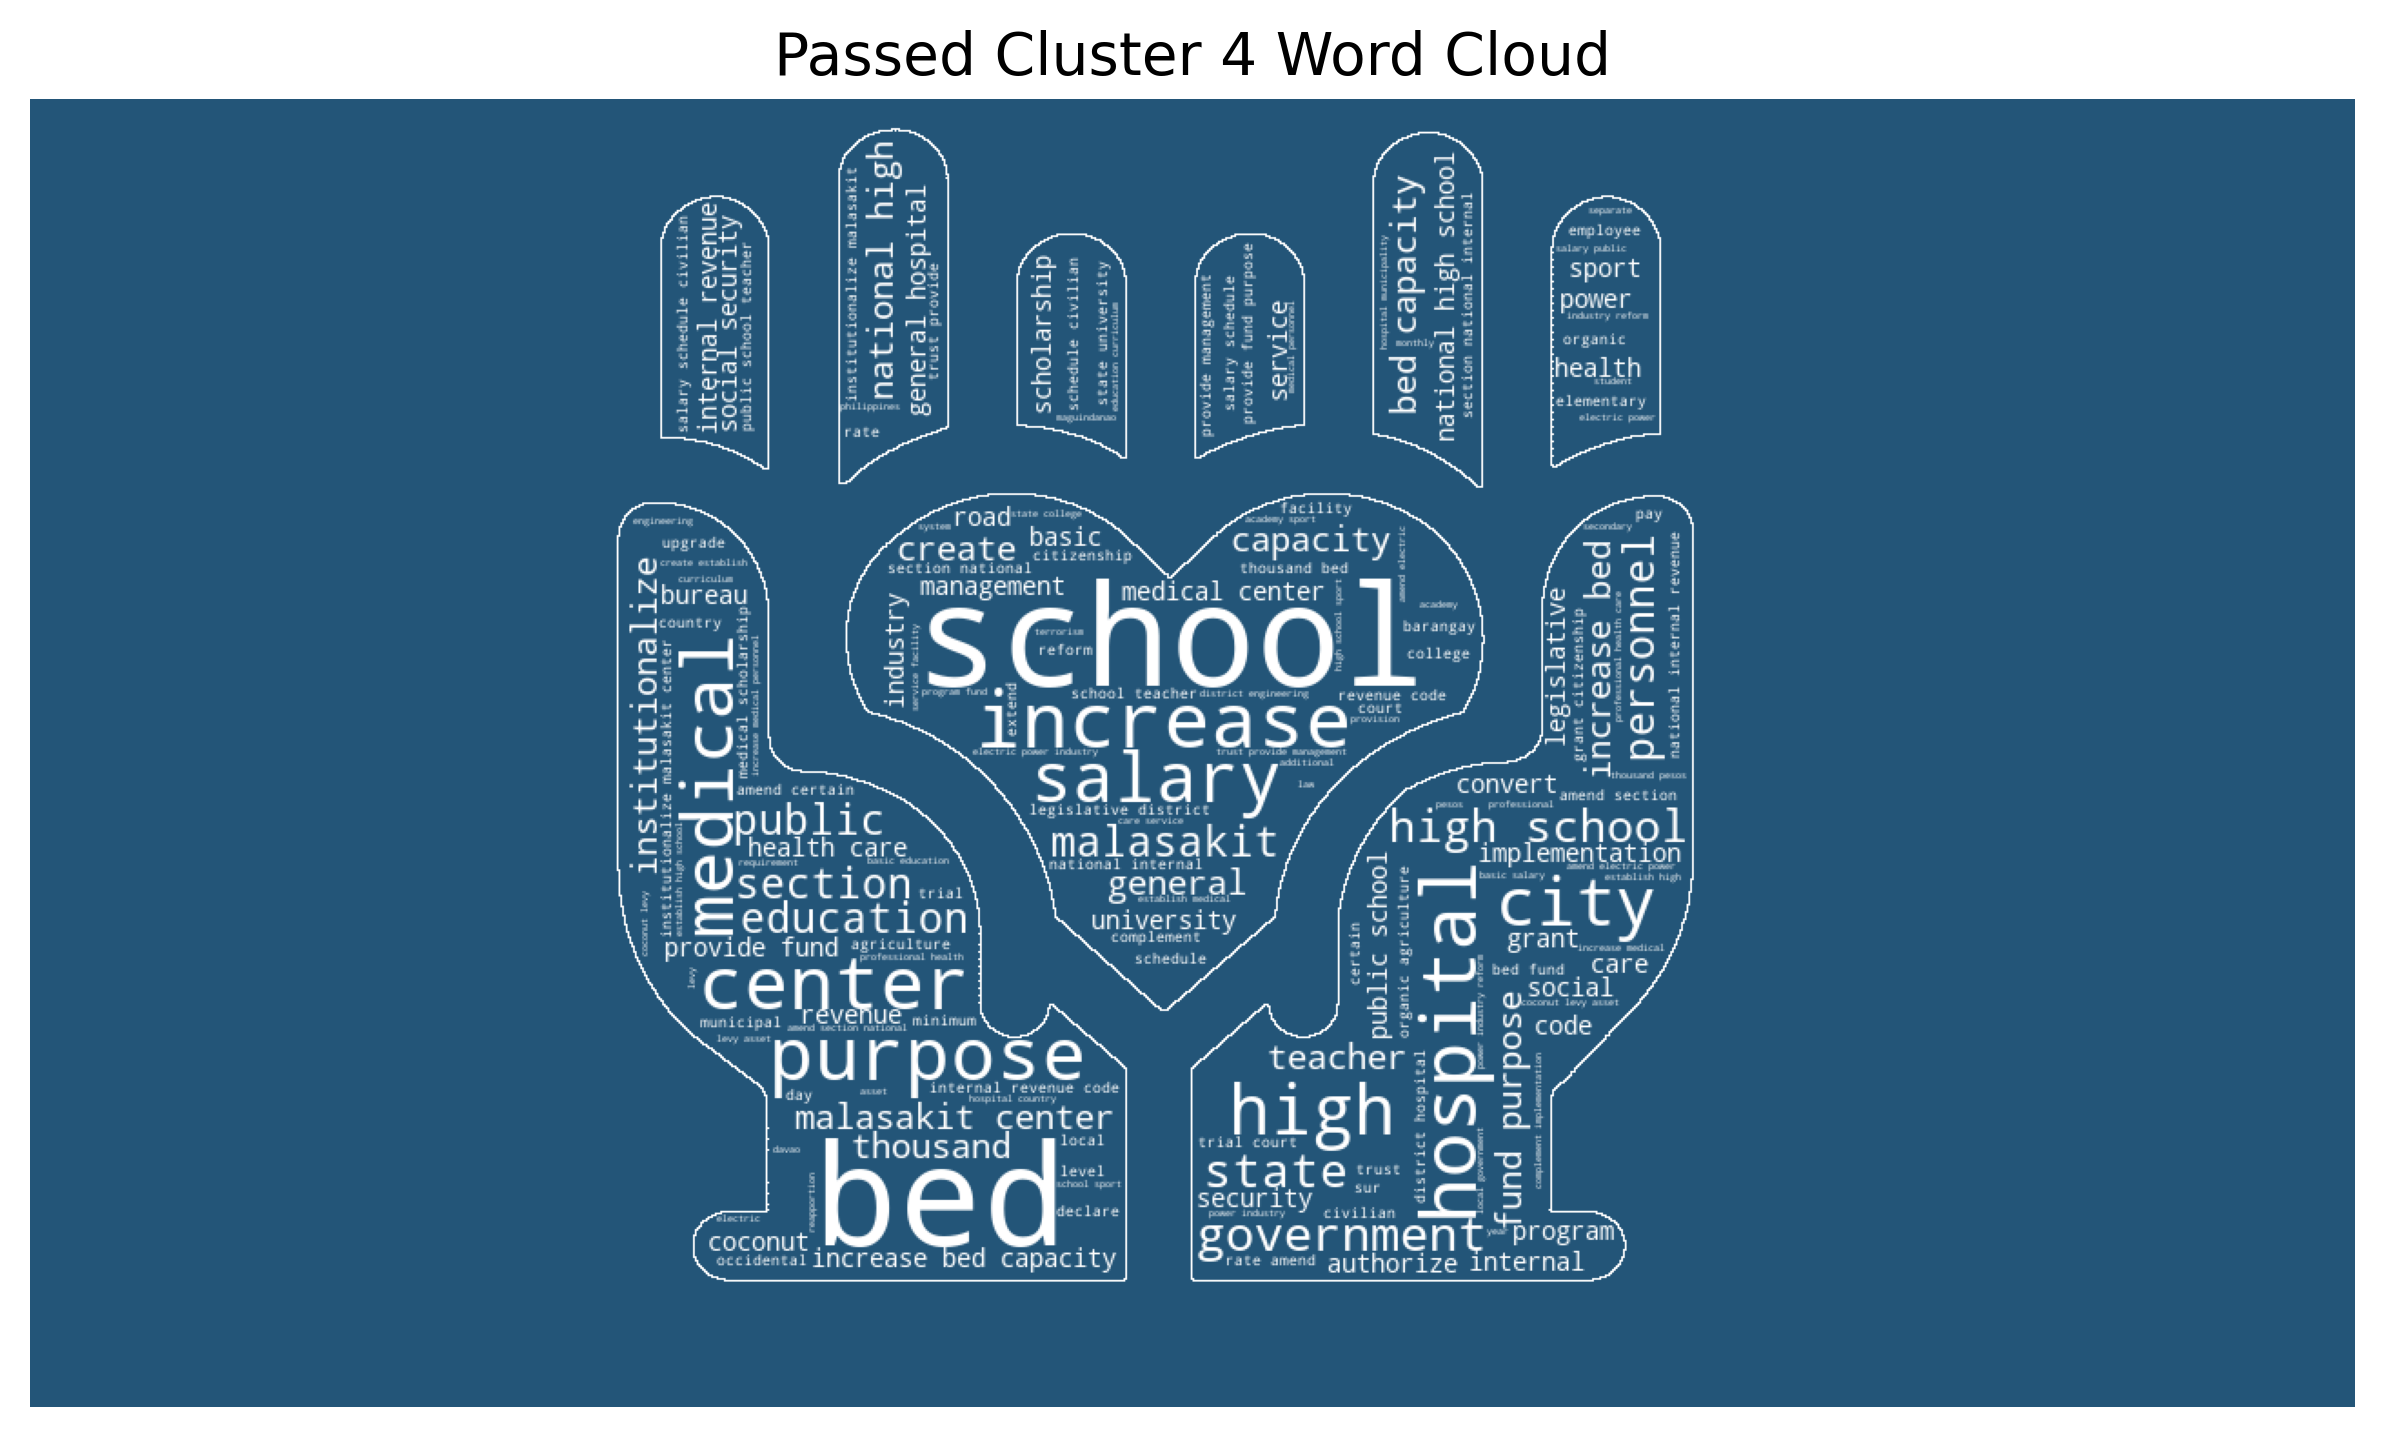

In [58]:
drop_c4 = ['amend', 'national', 'fund', 'establish', 'district', 'provide', 'province', 'municipality']
ser_c4 = (pd.DataFrame(bow_cong_p.todense(),
                       columns=cols_p,
                       index=df_passed.index)
          .loc[idx_c4,:]
          .sum(axis=0).sort_values(ascending=False).drop(drop_c4, axis=0))

mask_gen = Image.open('gen.png')
mask_gen = np.array(mask_gen.convert('1'))
transformed_mask = np.ndarray((mask_gen.shape[0], mask_gen.shape[1]),
                              np.int32)

for i in range(len(mask_gen)):
    transformed_mask[i] = list(map(transform_format, mask_gen[i]))

wordcloud_plotting(ser_c4, 
                   ListedColormap(['white']), 
                   'Passed Cluster 4 Word Cloud', mask=transformed_mask)

In [59]:
pd.DataFrame(bow_cong_p.todense(),
                       columns=cols_p,
                       index=df_passed.index).loc[idx_c4,:].sum(axis=0).sort_values(ascending=False).head(30)

fund                8.764348
national            6.810882
school              6.251087
bed                 6.021138
province            5.944950
provide             5.871371
increase            5.827699
amend               5.745159
hospital            5.579139
center              5.203392
establish           5.184140
purpose             5.168004
medical             4.947683
high                4.514940
salary              4.511230
district            4.361883
city                4.298449
government          4.233665
municipality        3.972196
state               3.947005
high school         3.742442
section             3.290460
malasakit           3.274447
public              3.267185
education           3.240264
personnel           3.178329
malasakit center    3.164501
create              3.090713
fund purpose        3.040717
national high       3.002242
dtype: float64

In [60]:
cleaned_titles_p.loc[idx_c4,:]['stemmed_text'].tolist()

['institutionalize national value etiquette moral uprightness program',
 'provide additional support compensation educator basic education',
 'declare coconut levy asset trust provide management utilization authorize privatization management dispose coconut levy asset purpose',
 'establish coconut farmer industry development trust provide management utilization',
 'amend section add section b national internal revenue code purpose',
 'amend section national internal revenue code',
 'provide reapportionment province bataan legislative district',
 'increase minimum salary public school teacher government employee augment personnel economic relief allowance',
 'establish national minimum monthly salary government provide fund',
 'convert occidental mindoro state college province occidental mindoro state university occidental mindoro state university omsu fund',
 "make position cooperative officer mandatory municipal city provincial level amend ' local government code '",
 'convert guimba 

# Non-Passed Bills Analysis

In [87]:
df_not_passed = hbs[hbs.pass_or_not == 'not passed']
df_not_passed.head()

house_bill_number                                              title  \
1           HB00002  AN ACT CREATING THE DEPARTMENT OF OVERSEAS FIL...   
2           HB00003  AN ACT PROVIDING FOR A NATIONAL PROGRAM TO SUP...   
3           HB00004  AN ACT CREATING THE EMERGENCY RESPONSE DEPARTM...   
4           HB00005  AN ACT INSTITUTIONALIZING MICROFINANCE PROGRAM...   
6           HB00007  AN ACT CREATING A DEPARTMENT OF FISHERIES AND ...   

  significance  date_filed                                  principal_authors  \
1     NATIONAL  2019-07-01  CAYETANO, ALAN PETER "COMPAÑERO" S.; CAYETANO,...   
2     NATIONAL  2019-07-01                CAYETANO, ALAN PETER "COMPAÑERO" S.   
3     NATIONAL  2019-07-01  CAYETANO, ALAN PETER "COMPAÑERO" S.; DUTERTE, ...   
4     NATIONAL  2019-07-01                CAYETANO, ALAN PETER "COMPAÑERO" S.   
6     NATIONAL  2019-07-01                CAYETANO, ALAN PETER "COMPAÑERO" S.   

    date_read                                primary_referral  \
1  2019-07-23                       GOVERNMENT REORGANIZATION   
2  2019-07-23                             WELFARE OF CHILDREN   
3  2019-07-23                       GOVERNMENT REORGANIZATION   
4  2019-07-23  MICRO, SMALL AND MEDIUM ENTERPRISE DEVELOPMENT   
6  2019-07-23                       GOVERNMENT REORGANIZATION   

                                  mother_bill_status  \
1  Approved by the House on 2020-03-11, transmitt...   
2                                                NaN   
3  Approved by the House on 2020-09-22, transmitt...   
4                                                NaN   
6                                                NaN   

                                              status pass_or_not  
1                             Substituted by HB05832  not passed  
2  Transmitted to the Committee on Appropriations...  not passed  
3                             Substituted by HB05989  not passed  
4  Pending with the Committee on MICRO, SMALL AND...  not passed  
6  Pending with the Committee on GOVERNMENT REORG...  not passed

In [88]:
df_np = df_not_passed[['title']]
df_np

title
1      AN ACT CREATING THE DEPARTMENT OF OVERSEAS FIL...
2      AN ACT PROVIDING FOR A NATIONAL PROGRAM TO SUP...
3      AN ACT CREATING THE EMERGENCY RESPONSE DEPARTM...
4      AN ACT INSTITUTIONALIZING MICROFINANCE PROGRAM...
6      AN ACT CREATING A DEPARTMENT OF FISHERIES AND ...
...                                                  ...
10091  AN ACT CRIMINALIZING THE USE OF FAKE VACCINATI...
10092  AN ACT DEFINING AND CRIMINALIZING VACCINE HOAR...
10093  AN ACT PROVIDING FOR THE PROMOTION AND DEVELOP...
10094  AN ACT ESTABLISHING A SPECIAL ECONOMIC ZONE IN...
10095  AN ACT ESTABLISHING A SPECIAL ECONOMIC ZONE IN...

[8652 rows x 1 columns]

In [89]:
cleaned_titles_np = cleaned_titles(df_np)[['stemmed_text']]
cleaned_titles_np

stemmed_text
1      create department overseas filipino worker ofw...
2      provide national program support care abandon ...
3      create emergency response department erd fund ...
4      institutionalize microfinance program access c...
6      create department fishery aquatic resource pro...
...                                                  ...
10091  criminalize use fake vaccination card provide ...
10092  define criminalize vaccine hoard unauthorized ...
10093  provide promotion development creative industr...
10094  establish special economic zone city iloilo pr...
10095  establish special economic zone municipality s...

[8652 rows x 1 columns]

## LSA

In [90]:
bow_cong_np, cols_np = tfidf_converter(cleaned_titles_np['stemmed_text'].values)
nonzeros = bow_cong_np.sum(axis=1).nonzero()[0]

bow_cong_np = bow_cong_np[nonzeros]
bow_cong_np

<8652x3675 sparse matrix of type '<class 'numpy.float64'>'
	with 146934 stored elements in Compressed Sparse Row format>

In [91]:
bow_cong_np.shape

(8652, 3675)

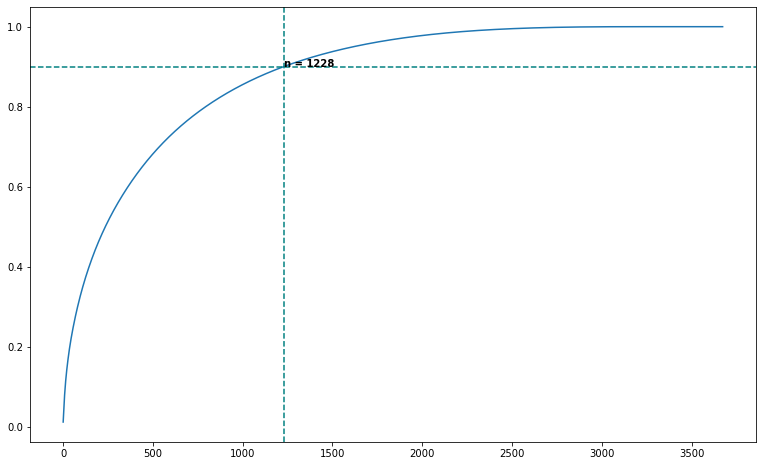

In [92]:
plot_var_explained(bow_cong_np.todense(), 0.9)

In [93]:
tsvd_test_np = TruncatedSVD(n_components=1228)
X_cong_np_new = tsvd_test_np.fit_transform(bow_cong_np.todense())
X_cong_np_new

array([[ 0.07437817, -0.18291121, -0.10688627, ...,  0.00117066,
        -0.00329568,  0.00582715],
       [ 0.0957979 , -0.12442717, -0.08591401, ...,  0.01390007,
        -0.00121915, -0.02167223],
       [ 0.12344908, -0.22532094, -0.08522757, ...,  0.01055869,
         0.00819855, -0.05178095],
       ...,
       [ 0.0859095 , -0.1491178 , -0.02031857, ...,  0.00830242,
        -0.00262986, -0.00614527],
       [ 0.07403126, -0.07812247,  0.05037066, ..., -0.00131044,
        -0.01140208,  0.01676203],
       [ 0.07792478, -0.06797507,  0.05631702, ..., -0.00171397,
        -0.00031846,  0.01359742]])

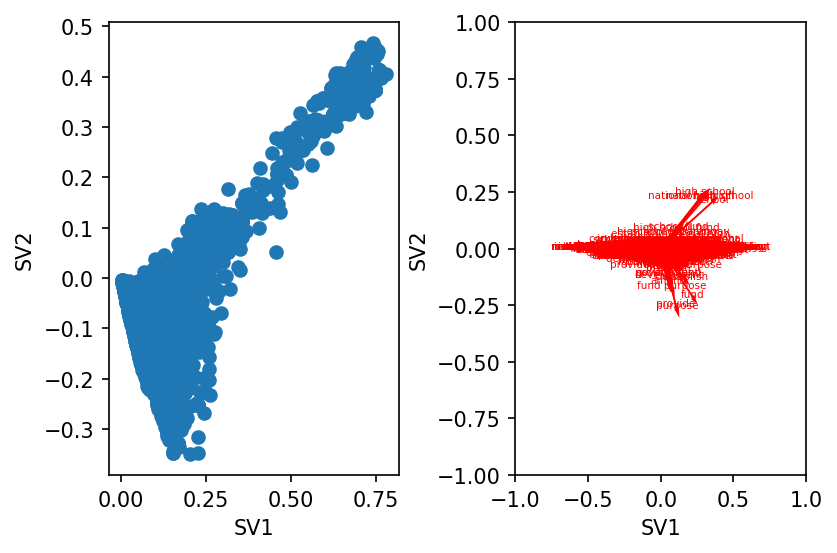

In [94]:
plot_svd(X_cong_np_new, cols_np, tsvd_test_np.components_.T, 0, 1)

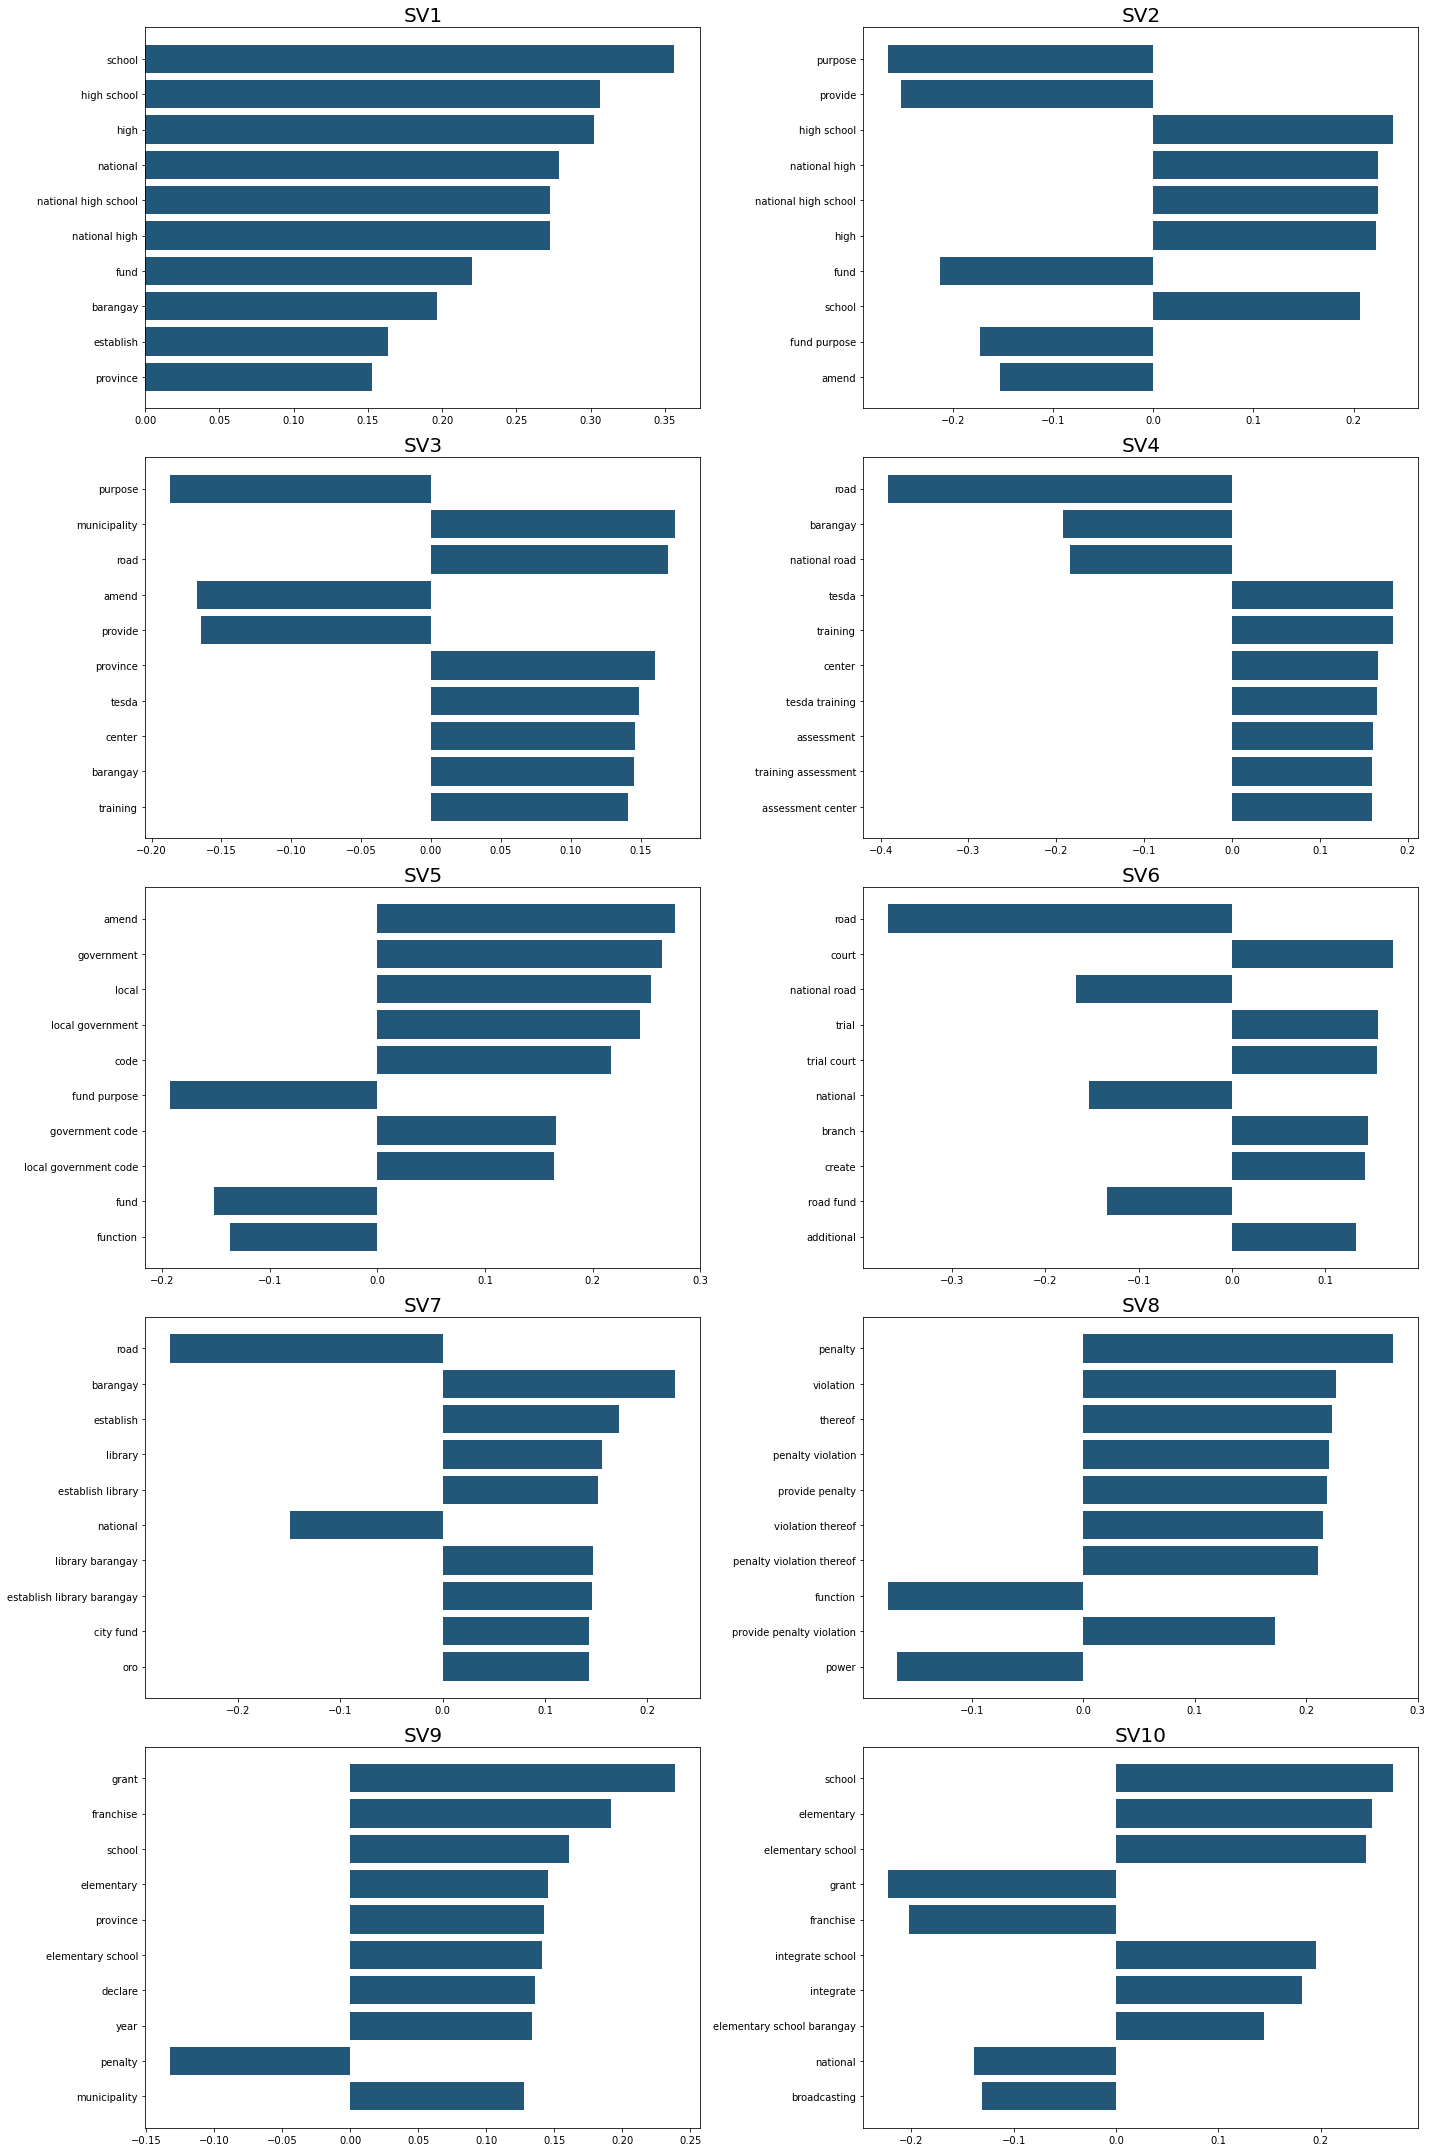

In [95]:
plot_LSA(cols_np, tsvd_test_np.components_.T, 10)

## Agglomerative

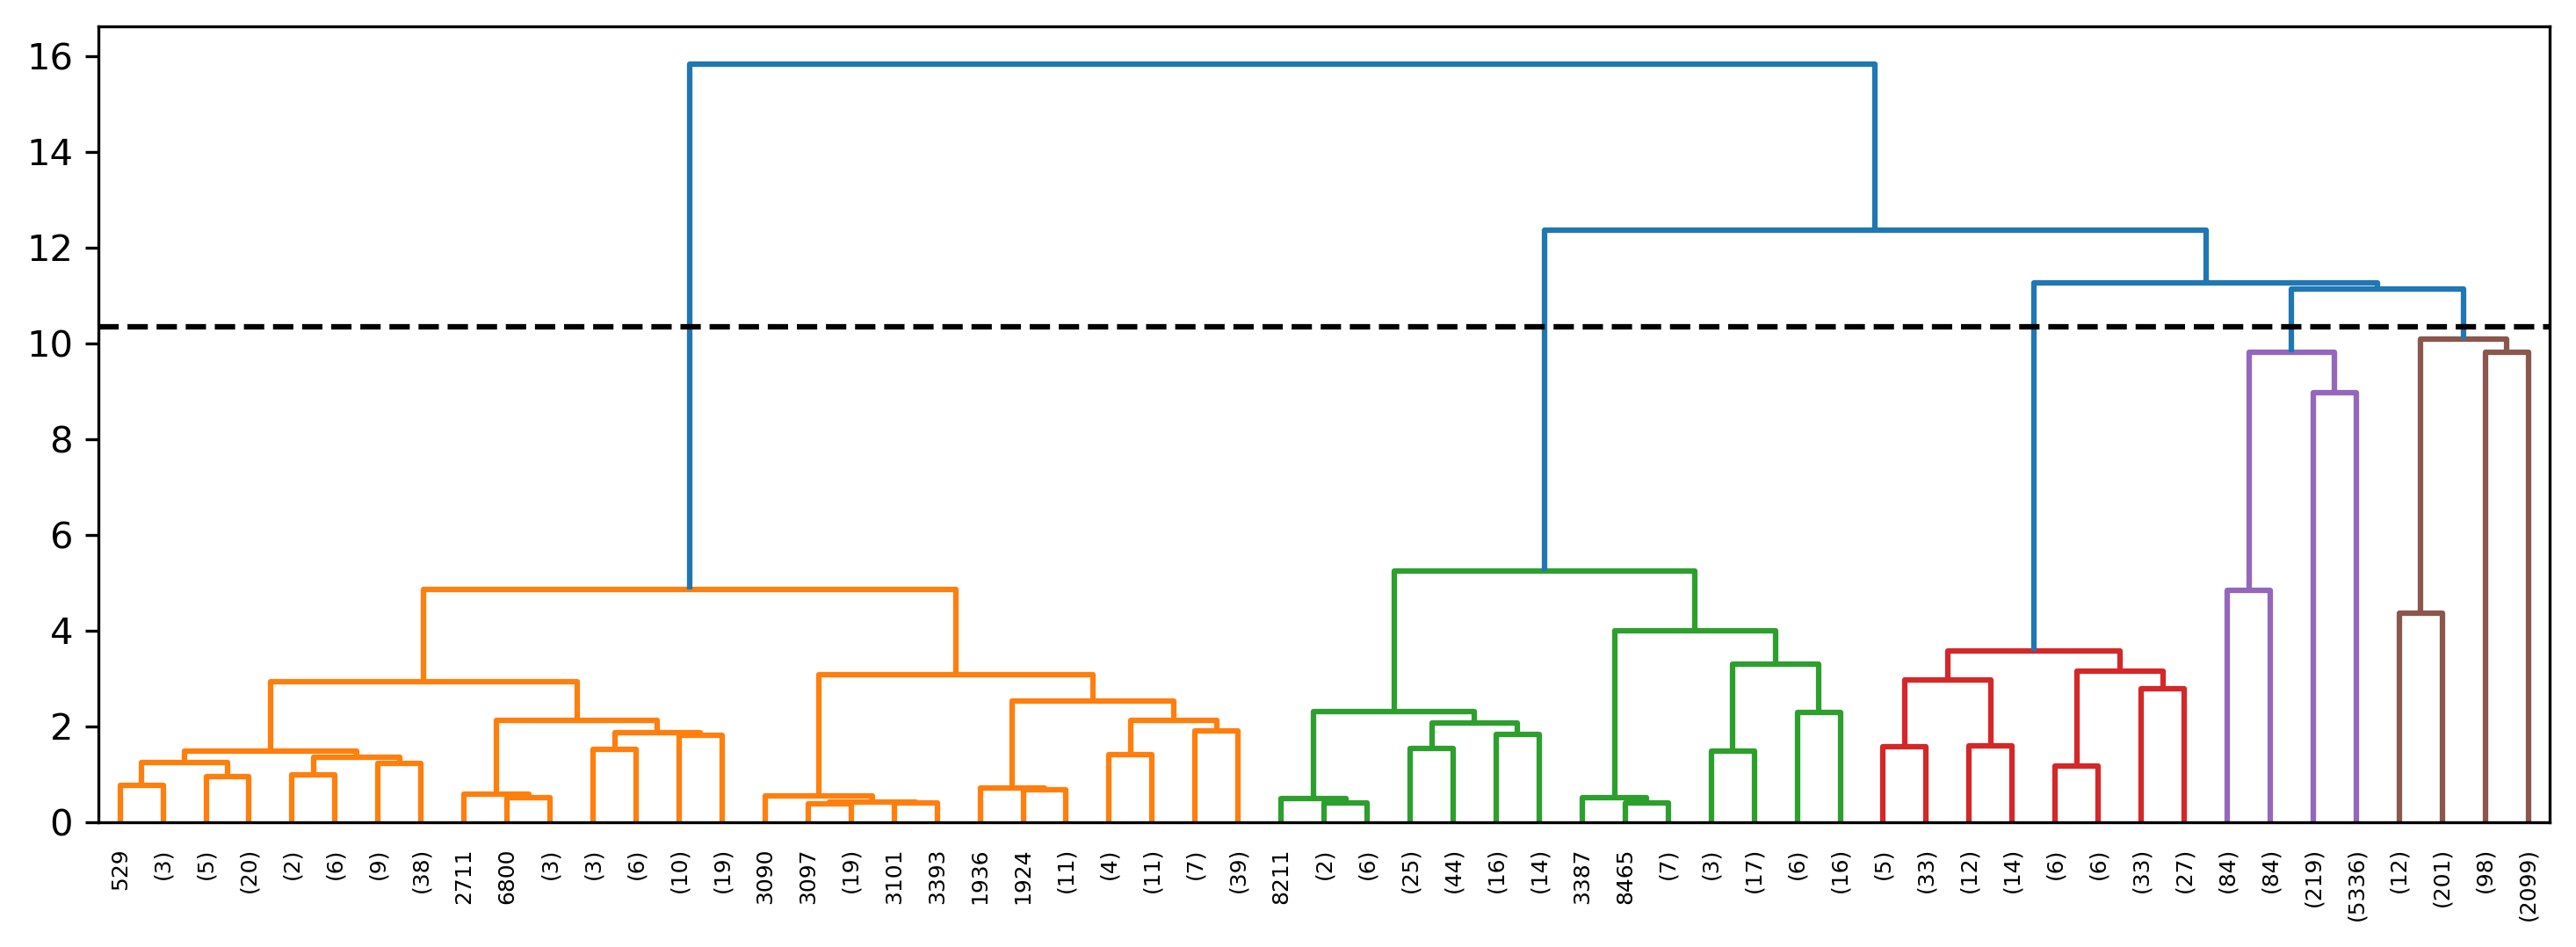

In [96]:
t2 = plot_dendrogram(X_cong_np_new, method='ward', p=5)

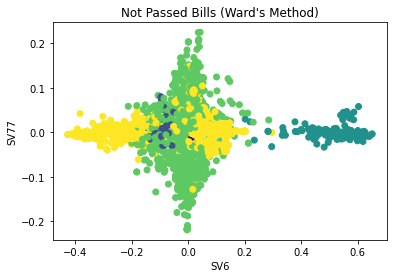

In [97]:
y_pred2 = plot_fcluster(X_cong_np_new, t2, 5, 76, 'Not Passed Bills (Ward\'s Method)')

In [98]:
set(y_pred2)

{1, 2, 3, 4, 5}

In [99]:
df_not_passed['cluster_label'] = y_pred2

### Distribution of Not Passed Clusters

In [100]:
df_not_passed.cluster_label.value_counts()

4    5723
5    2410
1     224
2     159
3     136
Name: cluster_label, dtype: int64

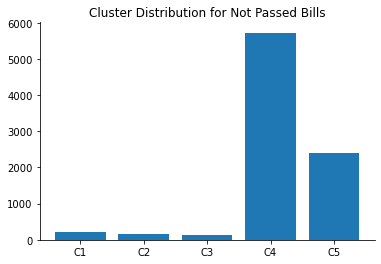

In [127]:

fig, ax = plt.subplots()
ax.bar(x=[f'C{i}' for i in df_not_passed['cluster_label'].value_counts().sort_index().index], height=df_not_passed['cluster_label'].value_counts().sort_index())
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title('Cluster Distribution for Not Passed Bills')
plt.show()

### Cluster 1 Analysis

In [101]:
idx_c1 = df_not_passed[df_not_passed.cluster_label == 1].index
idx_c1

Int64Index([  585,   675,   689,   711,   840,   841,   844,   944,   945,
              946,
            ...
             8071,  8225,  8402,  8434,  9145,  9282,  9557,  9644,  9796,
            10030],
           dtype='int64', length=224)

In [102]:
pd.DataFrame(bow_cong_np.todense(), columns=cols_np, index=df_not_passed.index).loc[idx_c1,:].sum(axis=0).sort_values(ascending=False).head(10)

national high school    71.564895
national high           71.564895
high school             70.295047
high                    66.446424
school                  58.906713
national                44.865111
high school fund        25.555557
school fund             23.575628
high school barangay    20.650552
school barangay         18.464997
dtype: float64

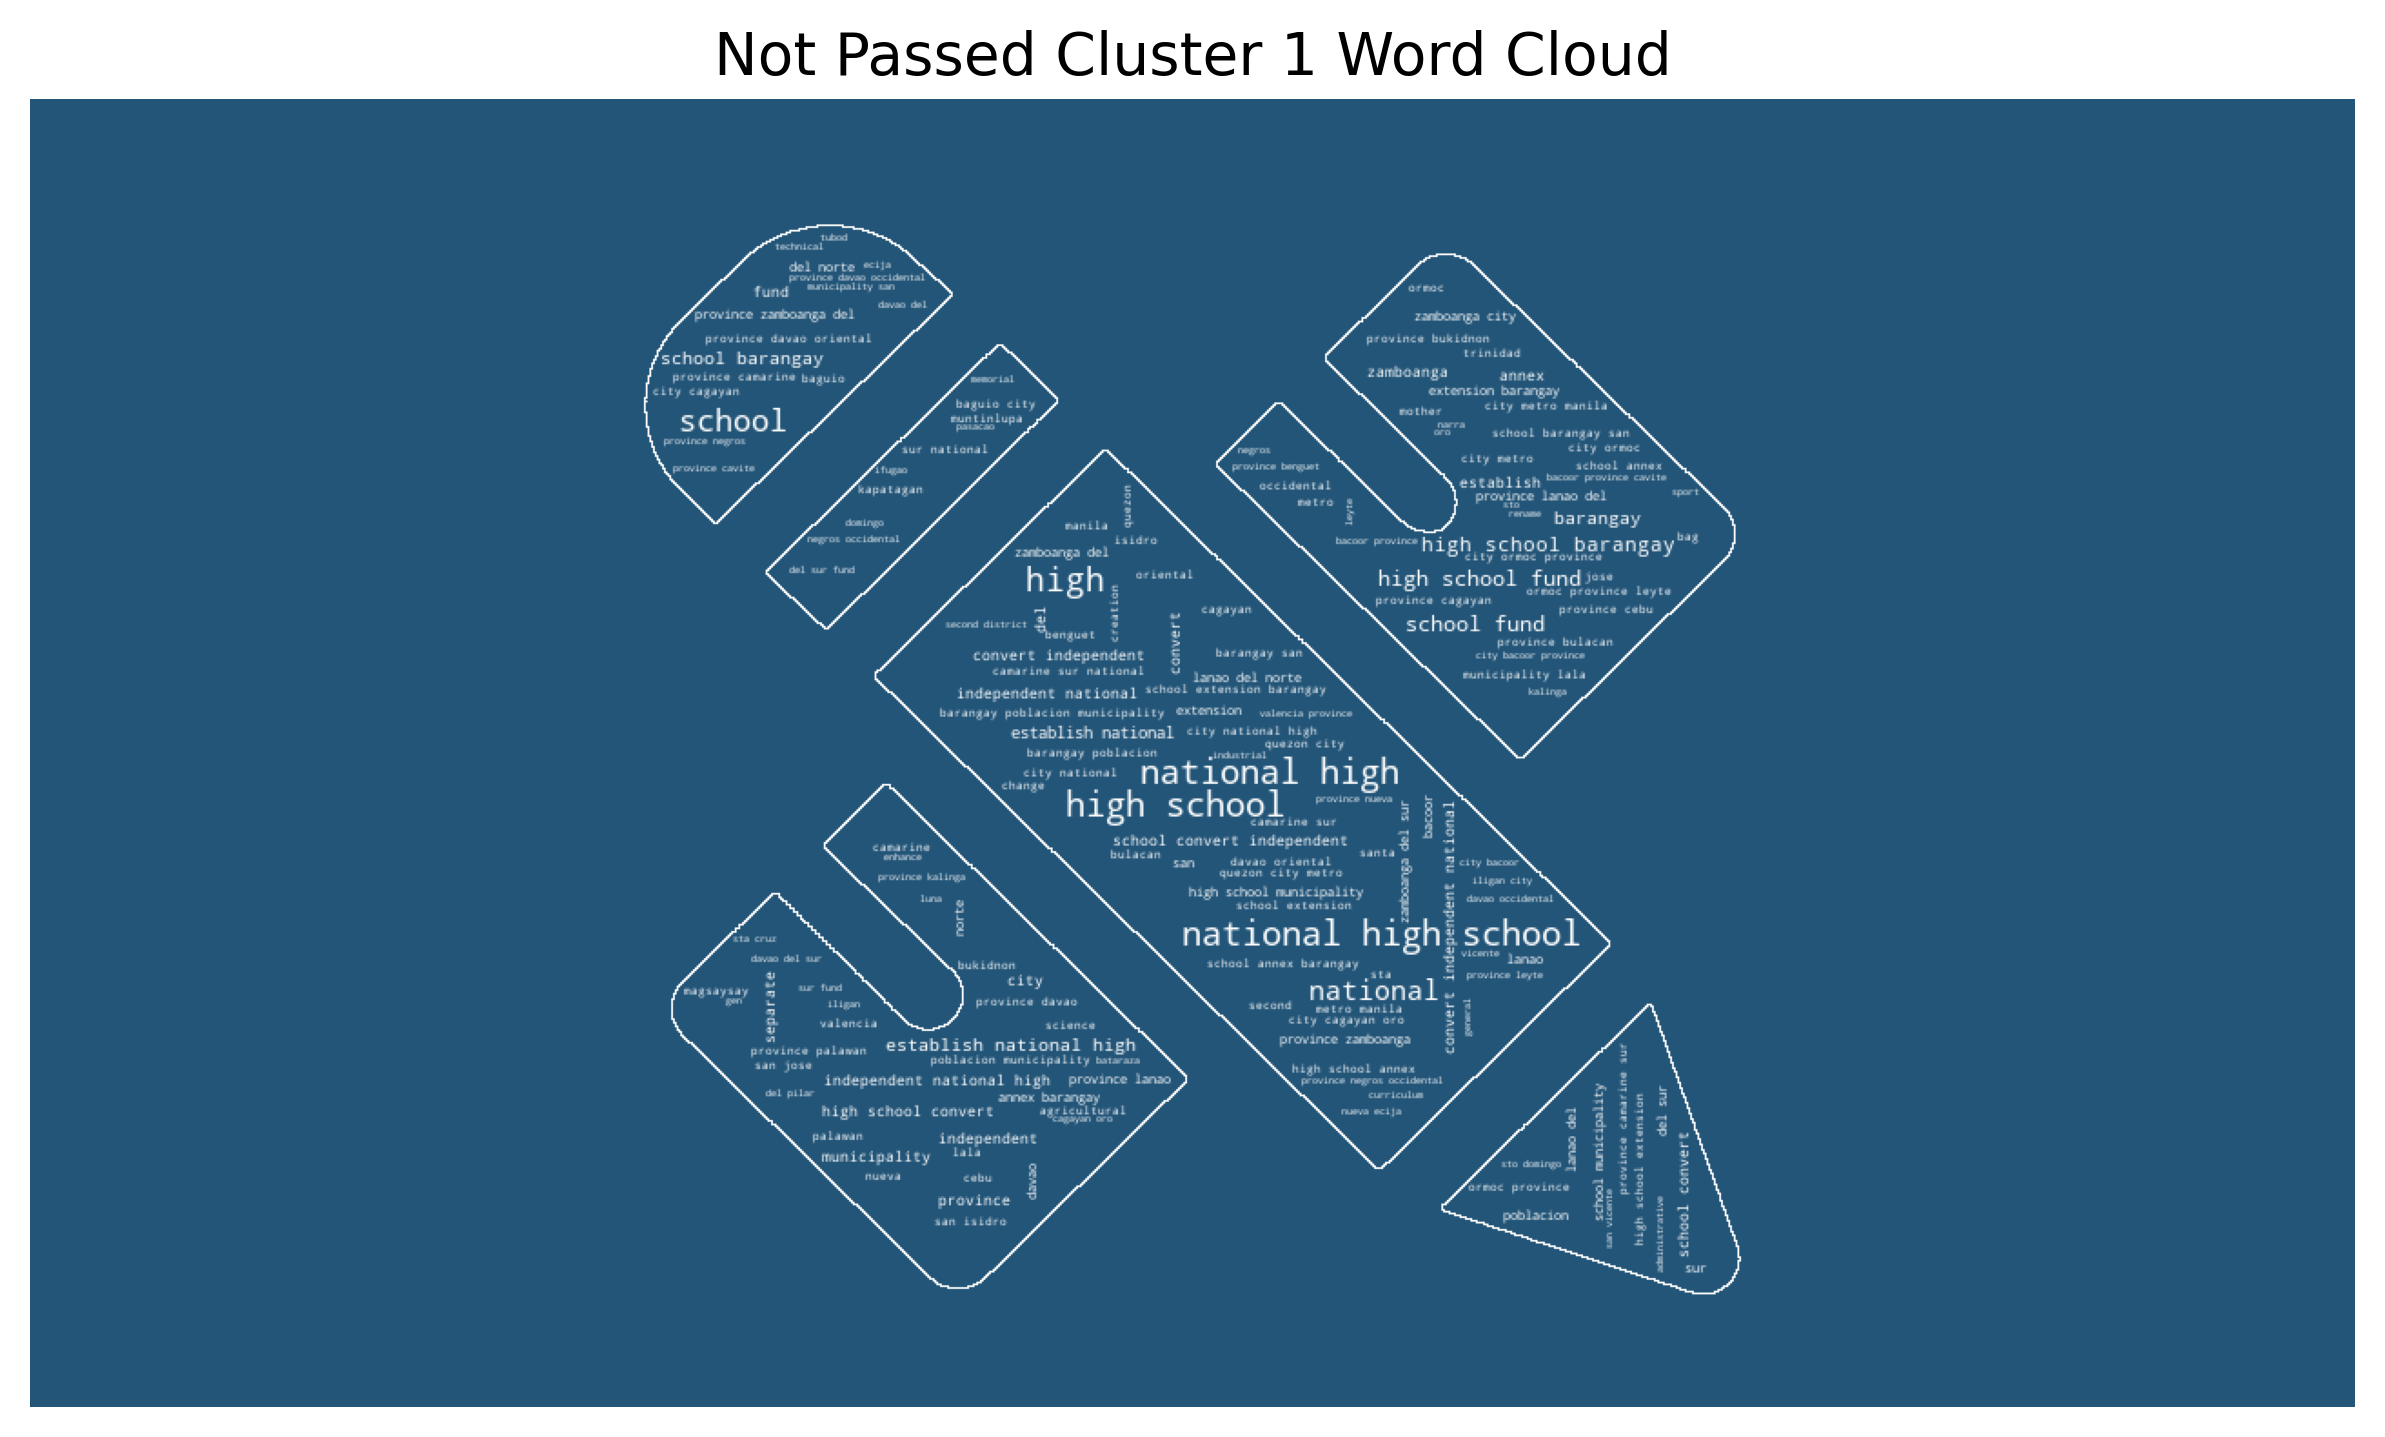

In [103]:
drop_c1 = ['high', 'school', 'national', 'national high',
           'high school know', 'national high school', 'high school barangay',
           'establish national', 'school barangay', 'high school fund',
           'establish national high', 'barangay', 'municipality', 'know',
           'province', 'school know', 'establish', 'del sur know']
drop_c1 = []
ser_c1 = (pd.DataFrame(bow_cong_np.todense(),
                       columns=cols_np,
                       index=df_not_passed.index)
          .loc[idx_c1,:]
          .sum(axis=0).sort_values(ascending=False).drop(drop_c1, axis=0))

mask_sec = Image.open('secondary.png')
mask_sec = np.array(mask_sec.convert('1'))
transformed_mask = np.ndarray((mask_sec.shape[0], mask_sec.shape[1]),
                              np.int32)

for i in range(len(mask_sec)):
    transformed_mask[i] = list(map(transform_format, mask_sec[i]))


wordcloud_plotting(ser_c1, 
                   ListedColormap(['white']), 
                   'Not Passed Cluster 1 Word Cloud', mask=transformed_mask)

In [104]:
ser_c1

national high school            71.564895
national high                   71.564895
high school                     70.295047
high                            66.446424
school                          58.906713
                                  ...    
filipino                         0.000000
filipino centenarian             0.000000
filipino centenarian purpose     0.000000
filipino citizenship             0.000000
zone provide penalty             0.000000
Length: 3675, dtype: float64

In [105]:
cleaned_titles_np.loc[idx_c1,:]['stemmed_text'].tolist()

['separate balbalan agricultural industrial school − balbalan proper extension barangay balbalan proper municipality balbalan province kalinga balbalan agricultural industrial school convert independent national high school eastern balbalan national high school fund',
 'rename constancio padilla national high school san jose city nueva ecija san jose city national high school',
 'establish national high school barangay tumana second district city marikina tumana national high school fund',
 'establish senior high school barangay talipapa quezon city metro manila talipapa national high school fund',
 'separate muntinlupa national high school nbp annex barangay poblacion city muntinlupa metro manila muntinlupa national high school convert independent national high school poblacion national high school fund',
 'establish national high school barangay tunasan city muntinlupa metro manila tunasan national high school fund purpose',
 'separate muntinlupa business high school – annex barangay

### Cluster 2 Analysis

In [106]:
idx_c2 = df_not_passed[df_not_passed.cluster_label == 2].index
idx_c2

Int64Index([  208,   422,   582,   620,   678,   773,   900,  1224,  1225,
             1589,
            ...
             9886,  9887,  9889,  9890,  9891,  9892,  9893,  9894,  9904,
            10048],
           dtype='int64', length=159)

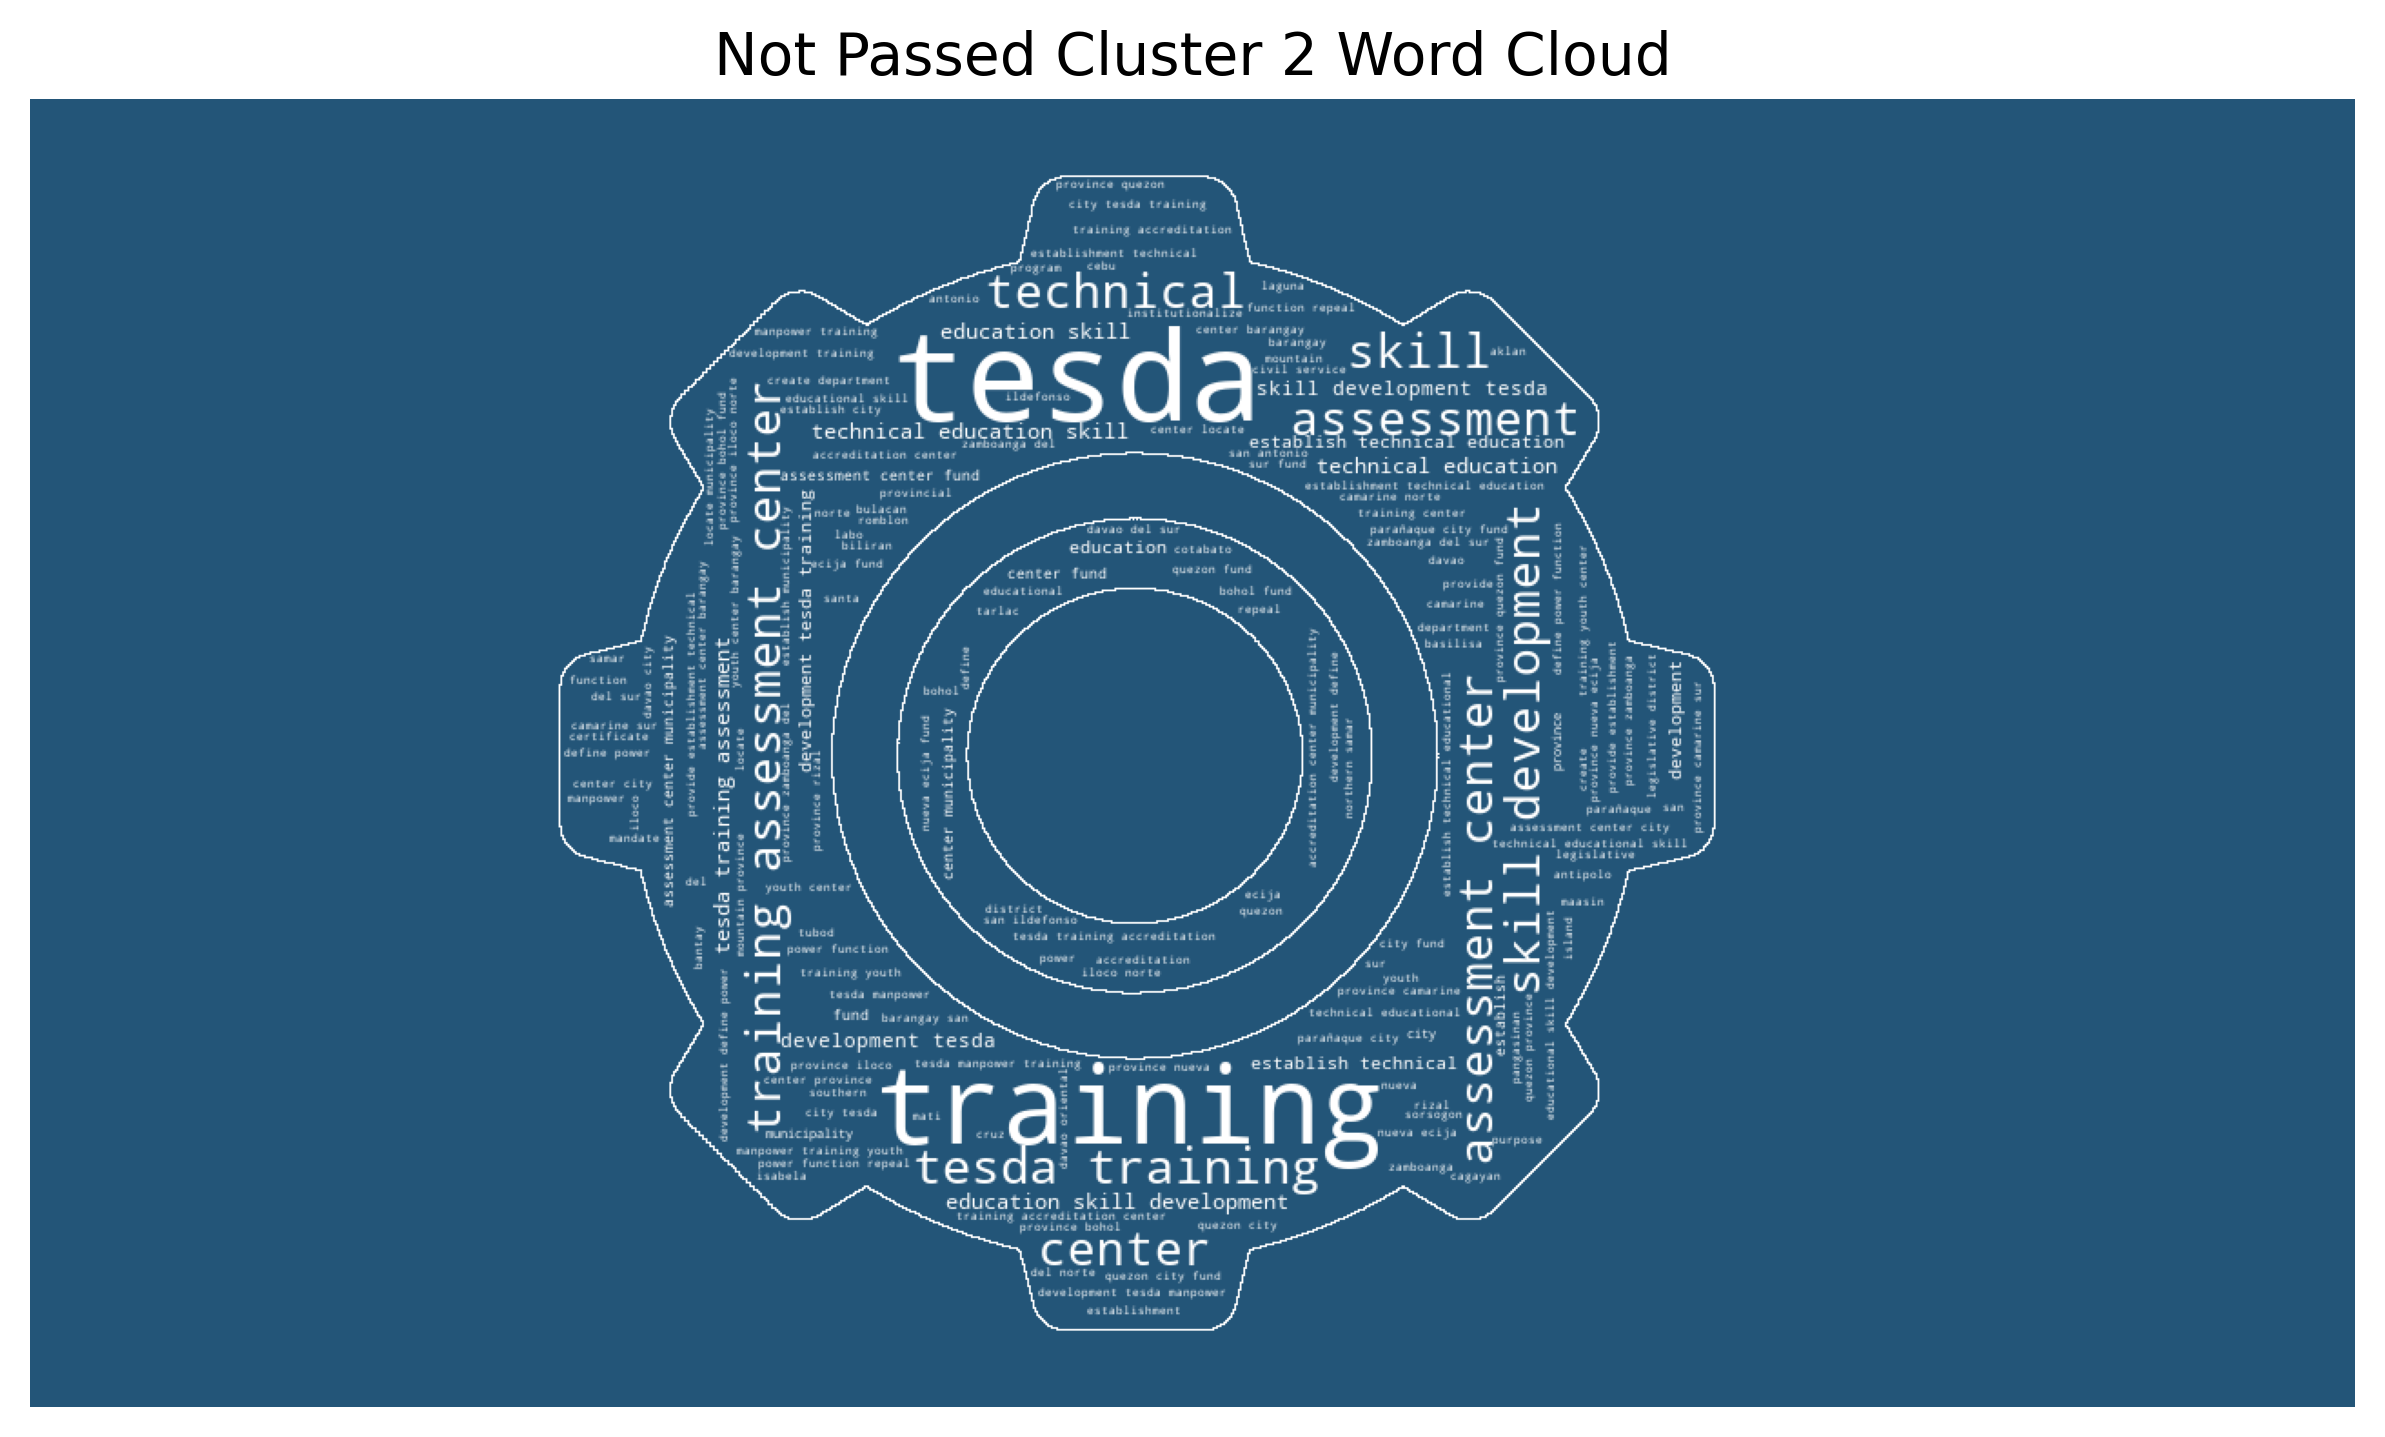

In [107]:
drop_c2 = ['training assessment']
ser_c2 = (pd.DataFrame(bow_cong_np.todense(),
                       columns=cols_np,
                       index=df_not_passed.index)
          .loc[idx_c2,:]
          .sum(axis=0).sort_values(ascending=False).drop(drop_c2, axis=0))

mask_tesda = Image.open('tesda.png')
mask_tesda = np.array(mask_tesda.convert('1'))
transformed_mask = np.ndarray((mask_tesda.shape[0], mask_tesda.shape[1]),
                              np.int32)

for i in range(len(mask_tesda)):
    transformed_mask[i] = list(map(transform_format, mask_tesda[i]))

wordcloud_plotting(ser_c2, 
                   ListedColormap(['white']), 
                   'Not Passed Cluster 2 Word Cloud', mask=transformed_mask)

In [108]:
pd.DataFrame(bow_cong_np.todense(), columns=cols_np, index=df_not_passed.index).loc[idx_c2,:].sum(axis=0).sort_values(ascending=False).head(10)

tesda                         30.675674
training                      27.474025
tesda training                25.972328
training assessment           24.382784
assessment center             24.238805
training assessment center    24.238805
assessment                    24.030338
skill development             23.207084
skill                         23.089160
center                        22.891361
dtype: float64

In [109]:
cleaned_titles_np.loc[idx_c2,:]['stemmed_text'].tolist()

['provide establishment technical education skill development tesda training accreditation center city antipolo province rizal antipolo city tesda training center accreditation center fund',
 'provide establishment technical education skill development tesda training accreditation center barangay camaman cagayan de oro city cagayan de oro city tesda training accreditation center fund',
 'institutionalize enhance skill certificate equivalency program scep civil service commission csc technical education skill development tesda purpose',
 'establish technical education skill development tesda training center municipality kalibo province aklan kalibo aklan tesda piña handloom weaving training assessment center fund',
 'provide establishment technical education skill development training accreditation center city san jose city science city muñoz municipality rizal second legislative district nueva ecija',
 'establish technical education skill development tesda training assessment center ta

### Cluster 3 Analysis

In [110]:
idx_c3 = df_not_passed[df_not_passed.cluster_label == 3].index
idx_c3

Int64Index([  375,   392,   571,   625,   721,   724,   839,  1043,  1151,
             1263,
            ...
            10054, 10055, 10056, 10057, 10058, 10059, 10060, 10061, 10062,
            10063],
           dtype='int64', length=136)

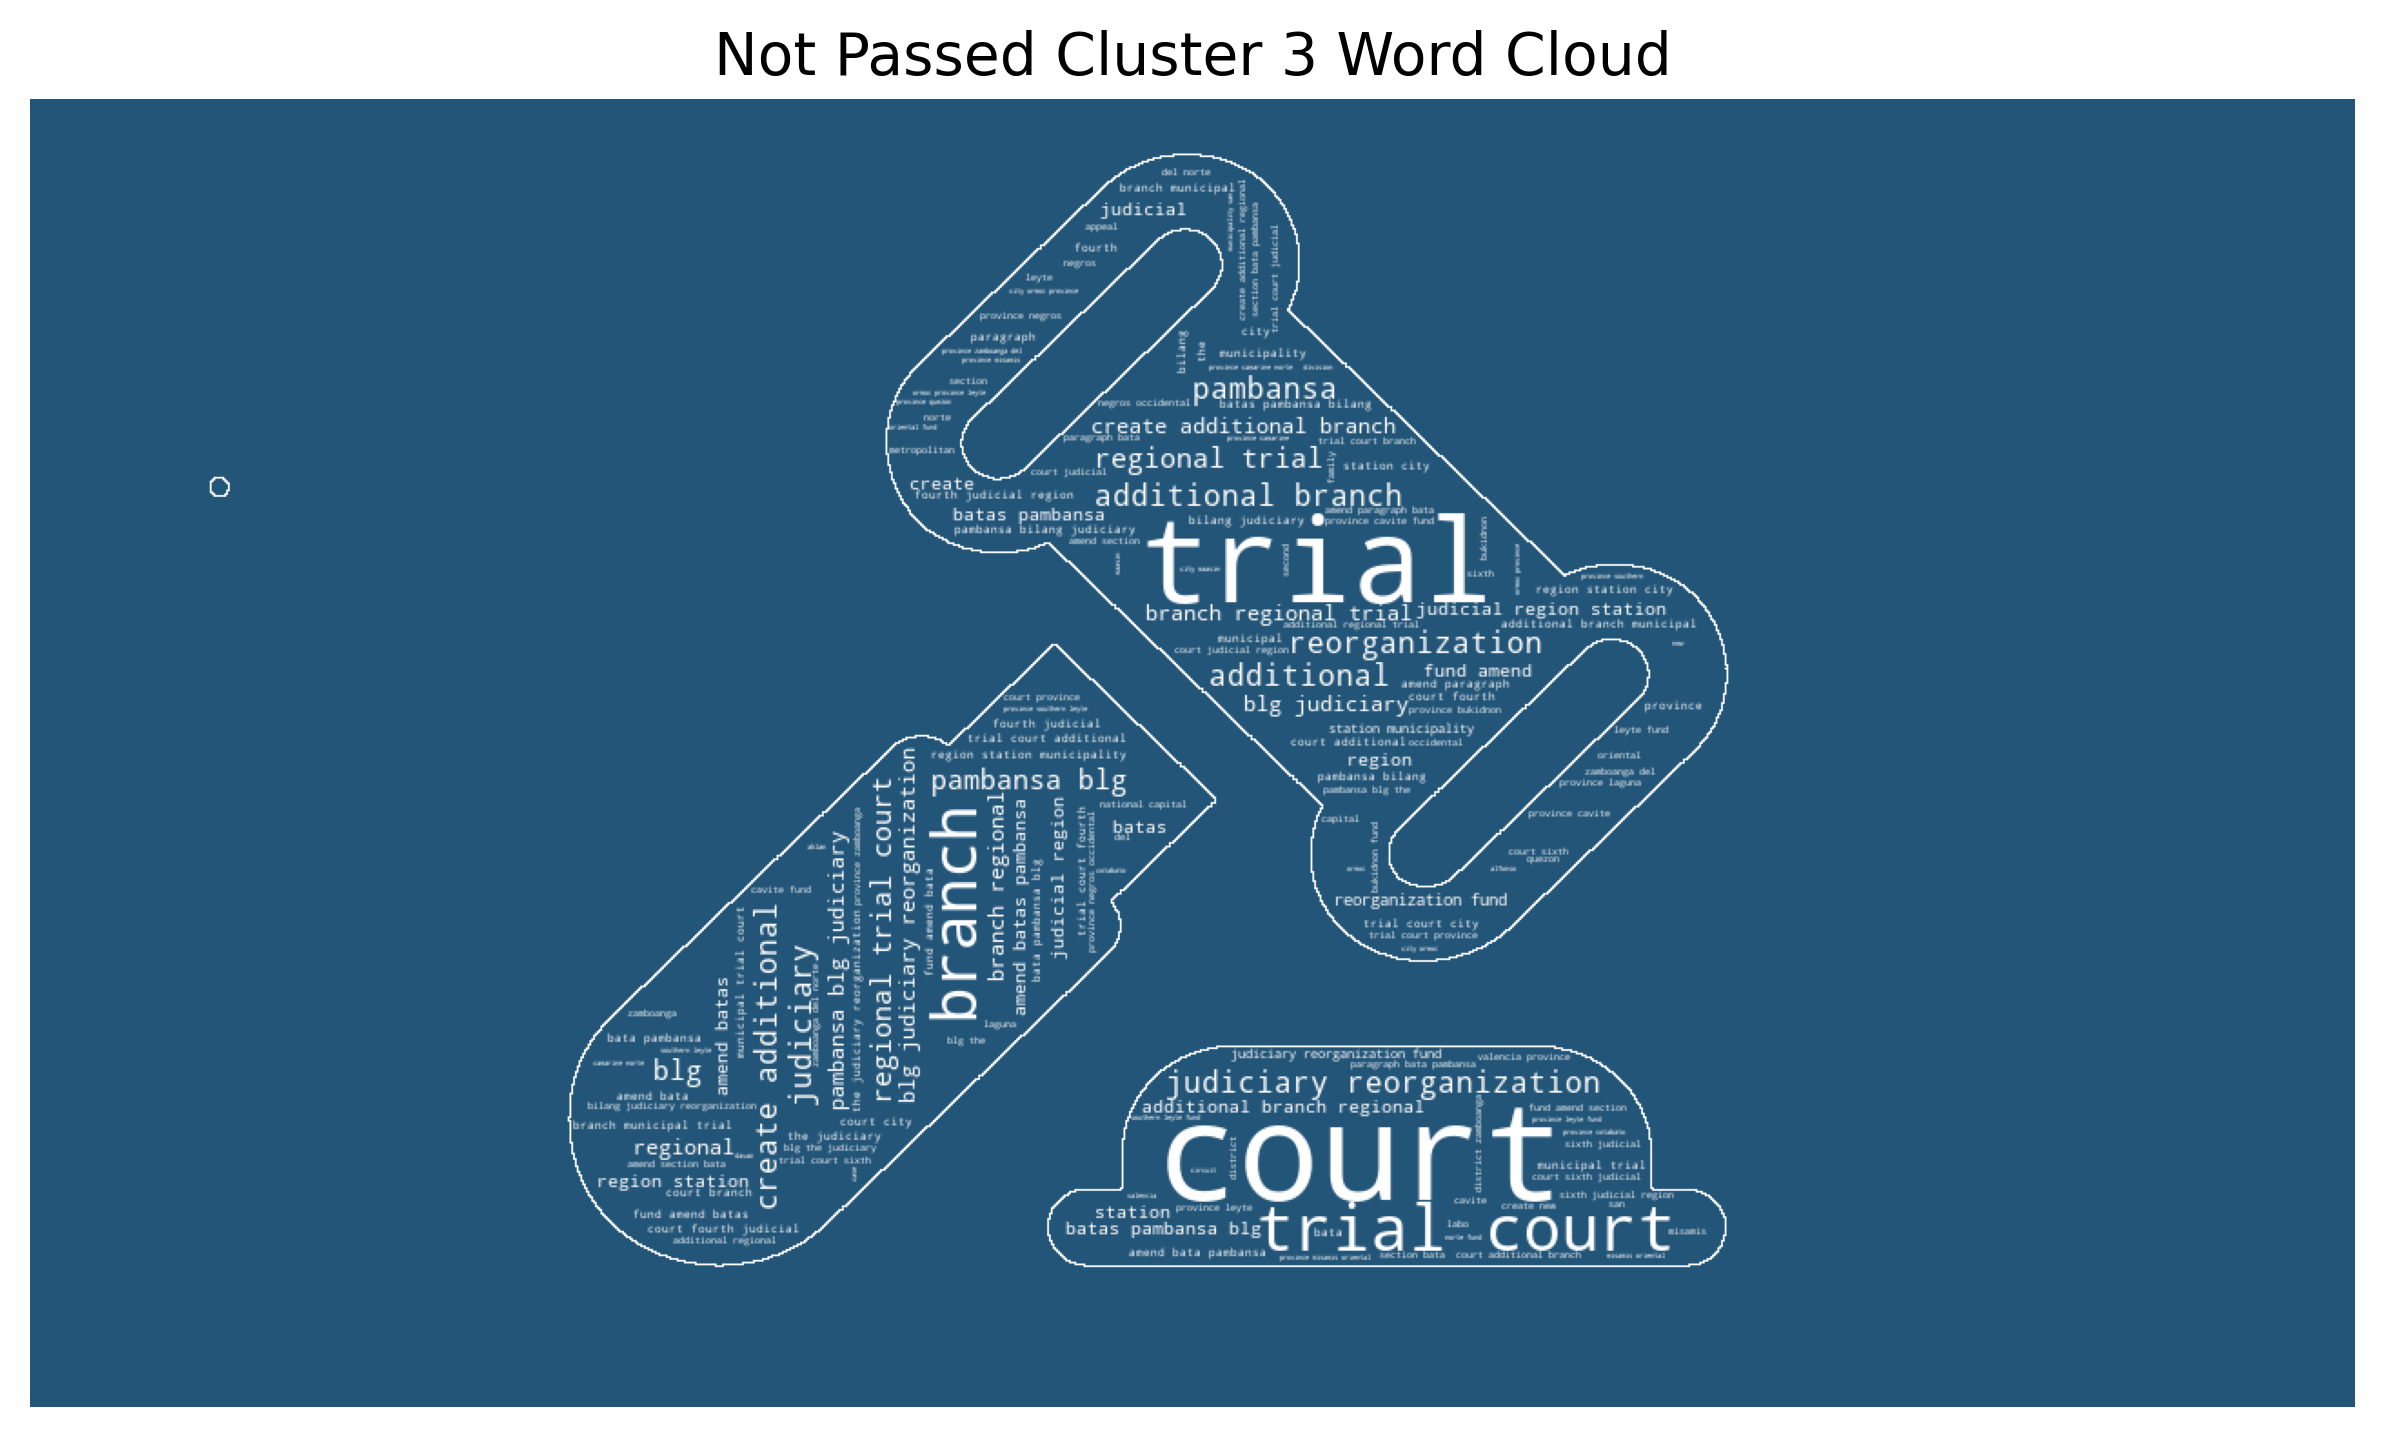

In [121]:
drop_c3 = ['amend', 'purpose', 'provide', 'national', 'fund', 'government', 'establish', 'program', 'fund', 'fund purpose']
ser_c3 = (pd.DataFrame(bow_cong_np.todense(),
                       columns=cols_np,
                       index=df_not_passed.index)
          .loc[idx_c3,:]
          .sum(axis=0).sort_values(ascending=False).drop(drop_c3, axis=0))

mask_gen = Image.open('judi.png')
mask_gen = np.array(mask_gen.convert('1'))
transformed_mask = np.ndarray((mask_gen.shape[0], mask_gen.shape[1]),
                              np.int32)

for i in range(len(mask_gen)):
    transformed_mask[i] = list(map(transform_format, mask_gen[i]))

wordcloud_plotting(ser_c3, 
                   ListedColormap(['white']), 
                   'Not Passed Cluster 3 Word Cloud', mask=transformed_mask)

In [112]:
pd.DataFrame(bow_cong_np.todense(),
                       columns=cols_np,
                       index=df_not_passed.index).loc[idx_c3,:].sum(axis=0).sort_values(ascending=False).head(10)

court                       22.400166
trial                       20.490117
trial court                 20.400790
branch                      18.737101
judiciary reorganization    16.756650
judiciary                   16.736016
additional branch           16.726237
reorganization              16.627549
additional                  16.498974
create additional           16.413997
dtype: float64

In [113]:
cleaned_titles_np.loc[idx_c3,:]['stemmed_text'].tolist()

['create additional metropolitan trial court branch city parañaque fund',
 'create additional branch regional trial court fourth judicial region station city general trias province cavite fund',
 'create additional branch municipal trial court citie city bacolod amend batas pambansa bilang judiciary reorganization fund',
 "create additional regional trial court additional municipal trial court citie city mati davao oriental amend batas pambansa blg ' judiciary reorganization ' fund",
 'create additional branch municipal trial court city mtcc city ormoc province leyte amend batas pambansa blg ꞌthe judiciary reorganization ꞌ fund',
 'create new court family court branch regional trial court st district zamboanga del norte amend batas pambansa blg ꞌthe judiciary reorganization ꞌ fund',
 "create additional branch regional trial court national capital judicial region station muntinlupa city metro manila amend batas pambansa blg ' the judiciary reorganization ' fund",
 'establish drug court 

### Cluster 4 Analysis

In [114]:
idx_c4 = df_not_passed[df_not_passed.cluster_label == 4].index
idx_c4

Int64Index([    1,     2,     3,     4,     6,     7,     8,    10,    11,
               12,
            ...
            10047, 10070, 10082, 10084, 10085, 10087, 10088, 10091, 10092,
            10093],
           dtype='int64', length=5723)

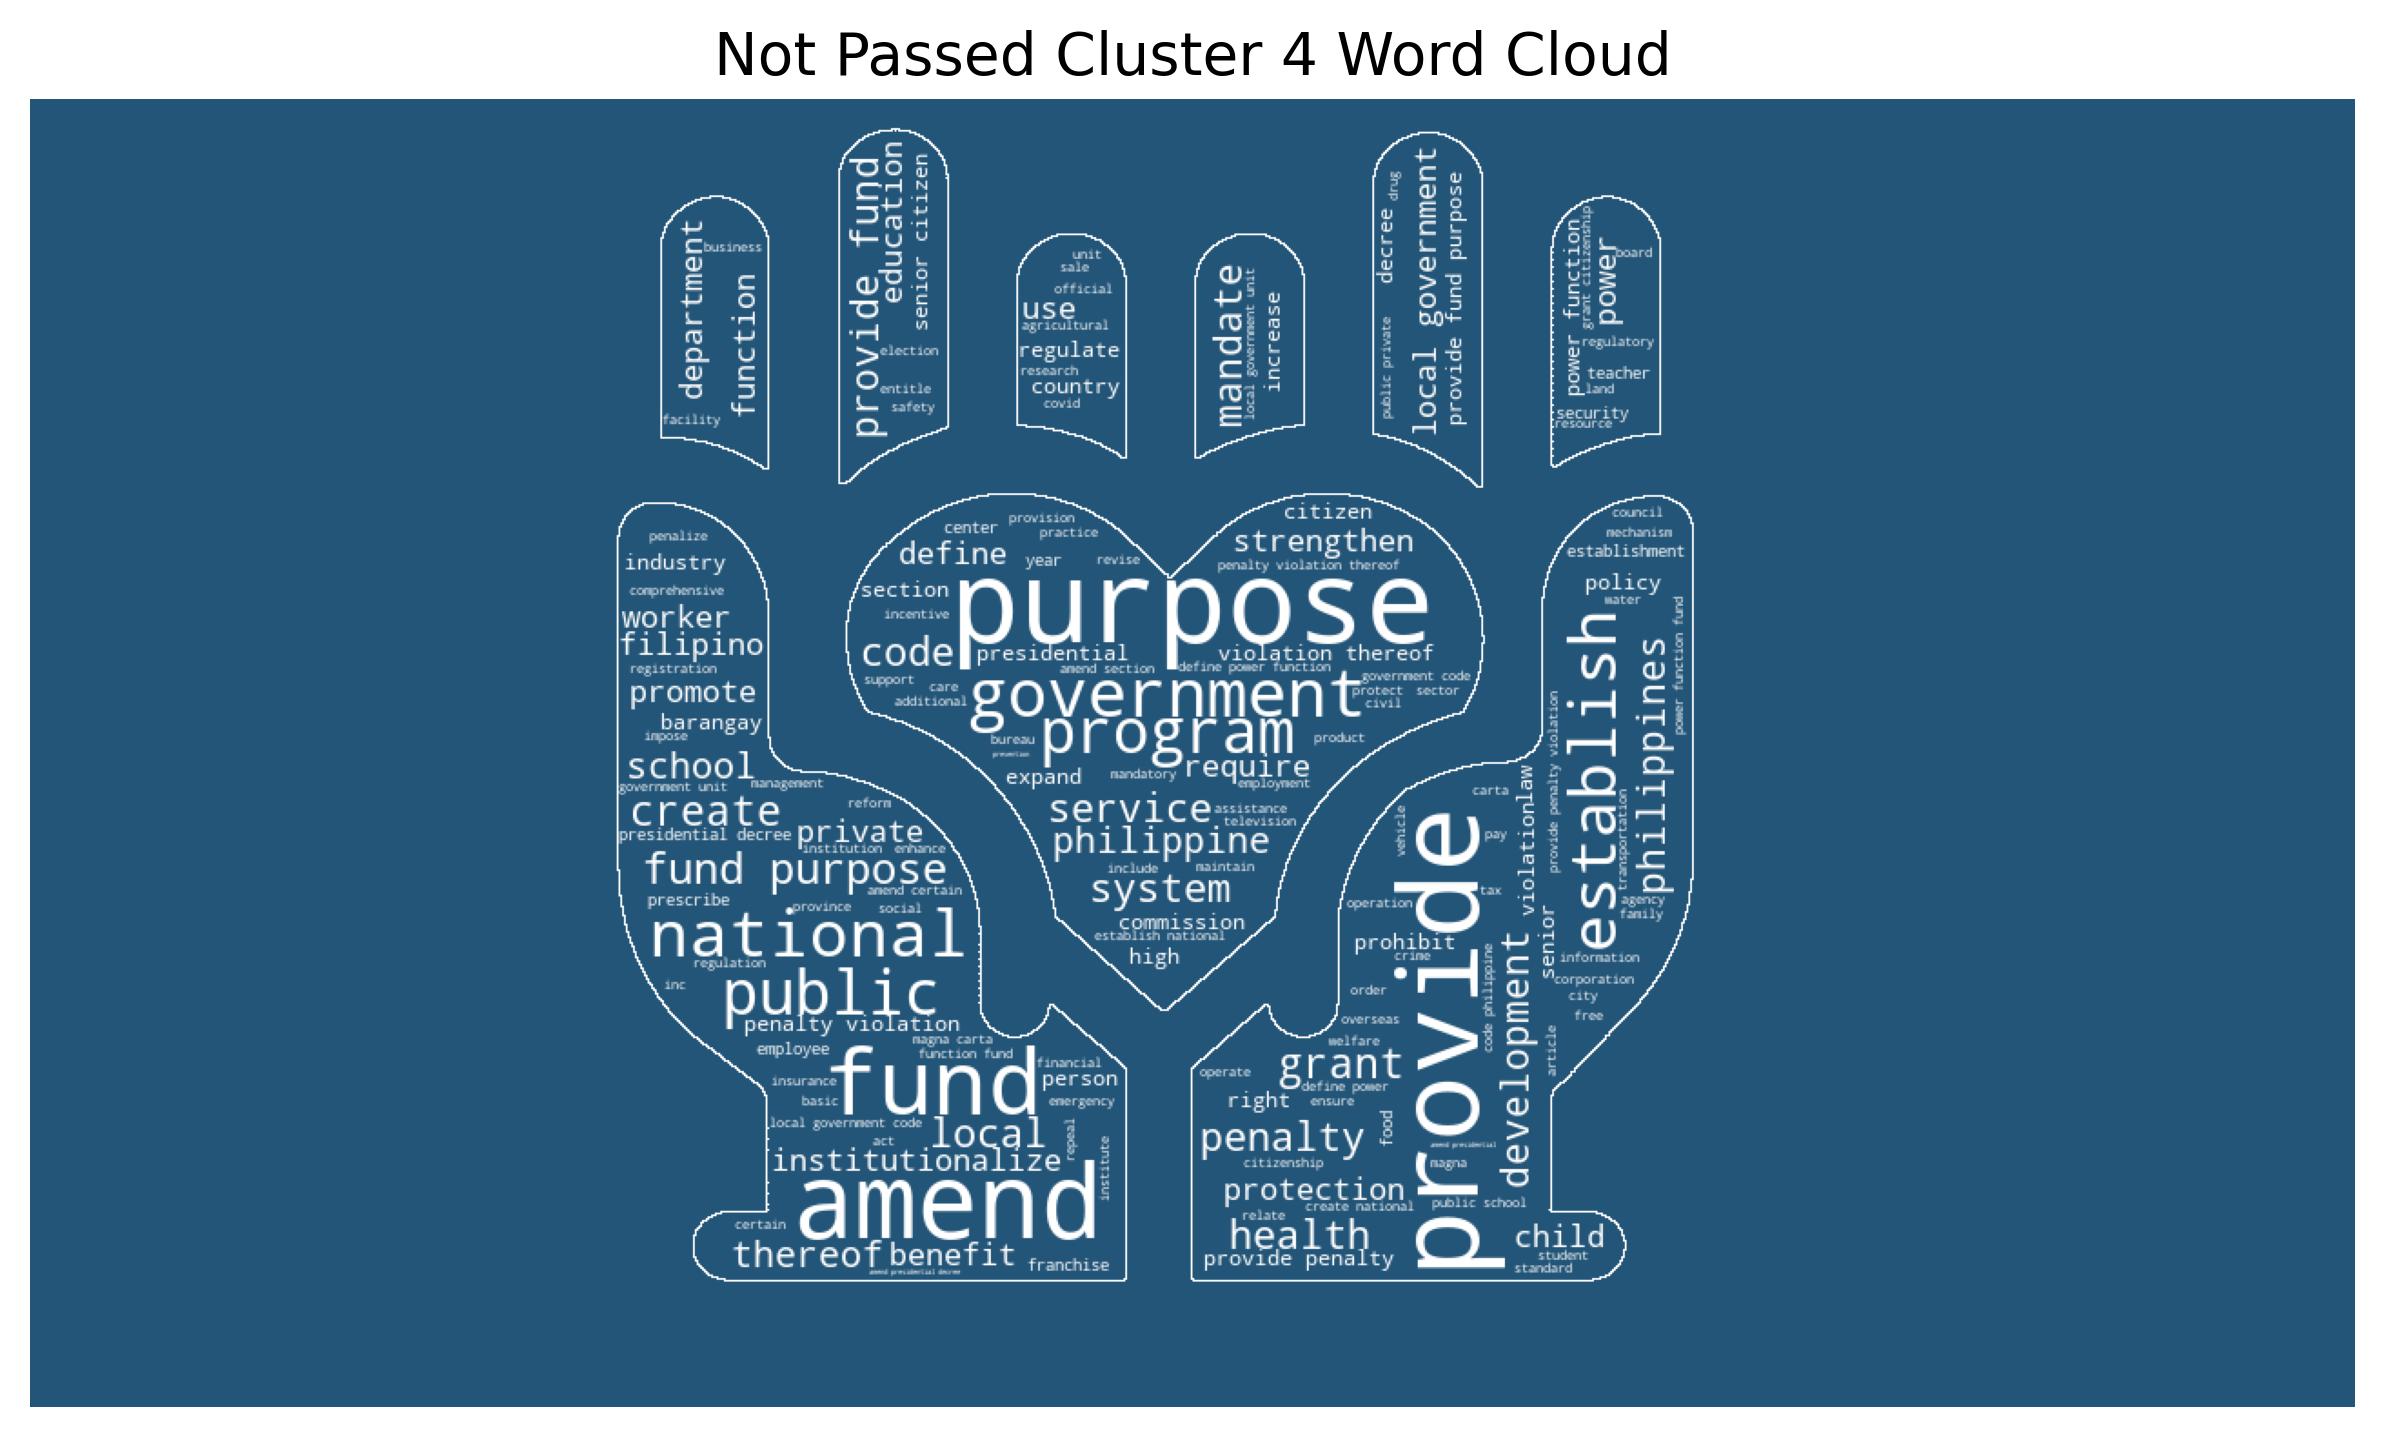

In [122]:
drop_c4 = ['trial', 'court']
ser_c4 = (pd.DataFrame(bow_cong_np.todense(),
                       columns=cols_np,
                       index=df_not_passed.index)
          .loc[idx_c4,:]
          .sum(axis=0).sort_values(ascending=False).drop(drop_c4, axis=0))

mask_judi = Image.open('gen.png')
mask_judi = np.array(mask_judi.convert('1'))
transformed_mask = np.ndarray((mask_judi.shape[0], mask_judi.shape[1]),
                              np.int32)

for i in range(len(mask_judi)):
    transformed_mask[i] = list(map(transform_format, mask_judi[i]))
    

wordcloud_plotting(ser_c4, 
                   ListedColormap(['white']), 
                   'Not Passed Cluster 4 Word Cloud', mask=transformed_mask)

In [116]:
pd.DataFrame(bow_cong_np.todense(), columns=cols_np, index=df_not_passed.index).loc[idx_c4,:].sum(axis=0).sort_values(ascending=False).head(10)

purpose         224.946576
provide         204.856596
amend           176.187819
fund            135.308211
government      112.925884
national        108.316855
establish       103.276084
public           99.585570
program          99.159461
fund purpose     99.093853
dtype: float64

In [117]:
cleaned_titles_np.loc[idx_c4,:]['stemmed_text'].tolist()

['create department overseas filipino worker ofw foreign employment define power function fund rationalize organization function government agency relate migration purpose',
 'provide national program support care abandon neglect voluntary commit child create special trust purpose',
 'create emergency response department erd fund purpose',
 'institutionalize microfinance program access capital support grow micro small medium enterprise msme allocate fund purpose',
 'create department fishery aquatic resource provide power function purpose',
 'establish national health passport system strengthen primary healthcare system fund',
 'establish national economic decentralization plan facilitate growth region philippines purpose',
 'create mega cebu development prescribing function duty provide fund',
 "strengthen people 's right information",
 'allow regulate use motorcycle public utility vehicle amend land transportation traffic code purpose',
 'provide light rail transport lrt system metro

### Cluster 5 Analysis

In [118]:
idx_c5 = df_not_passed[df_not_passed.cluster_label == 5].index
idx_c5

Int64Index([   16,    17,    18,    19,    35,    45,    48,    53,    63,
               71,
            ...
            10077, 10078, 10079, 10080, 10081, 10083, 10089, 10090, 10094,
            10095],
           dtype='int64', length=2410)

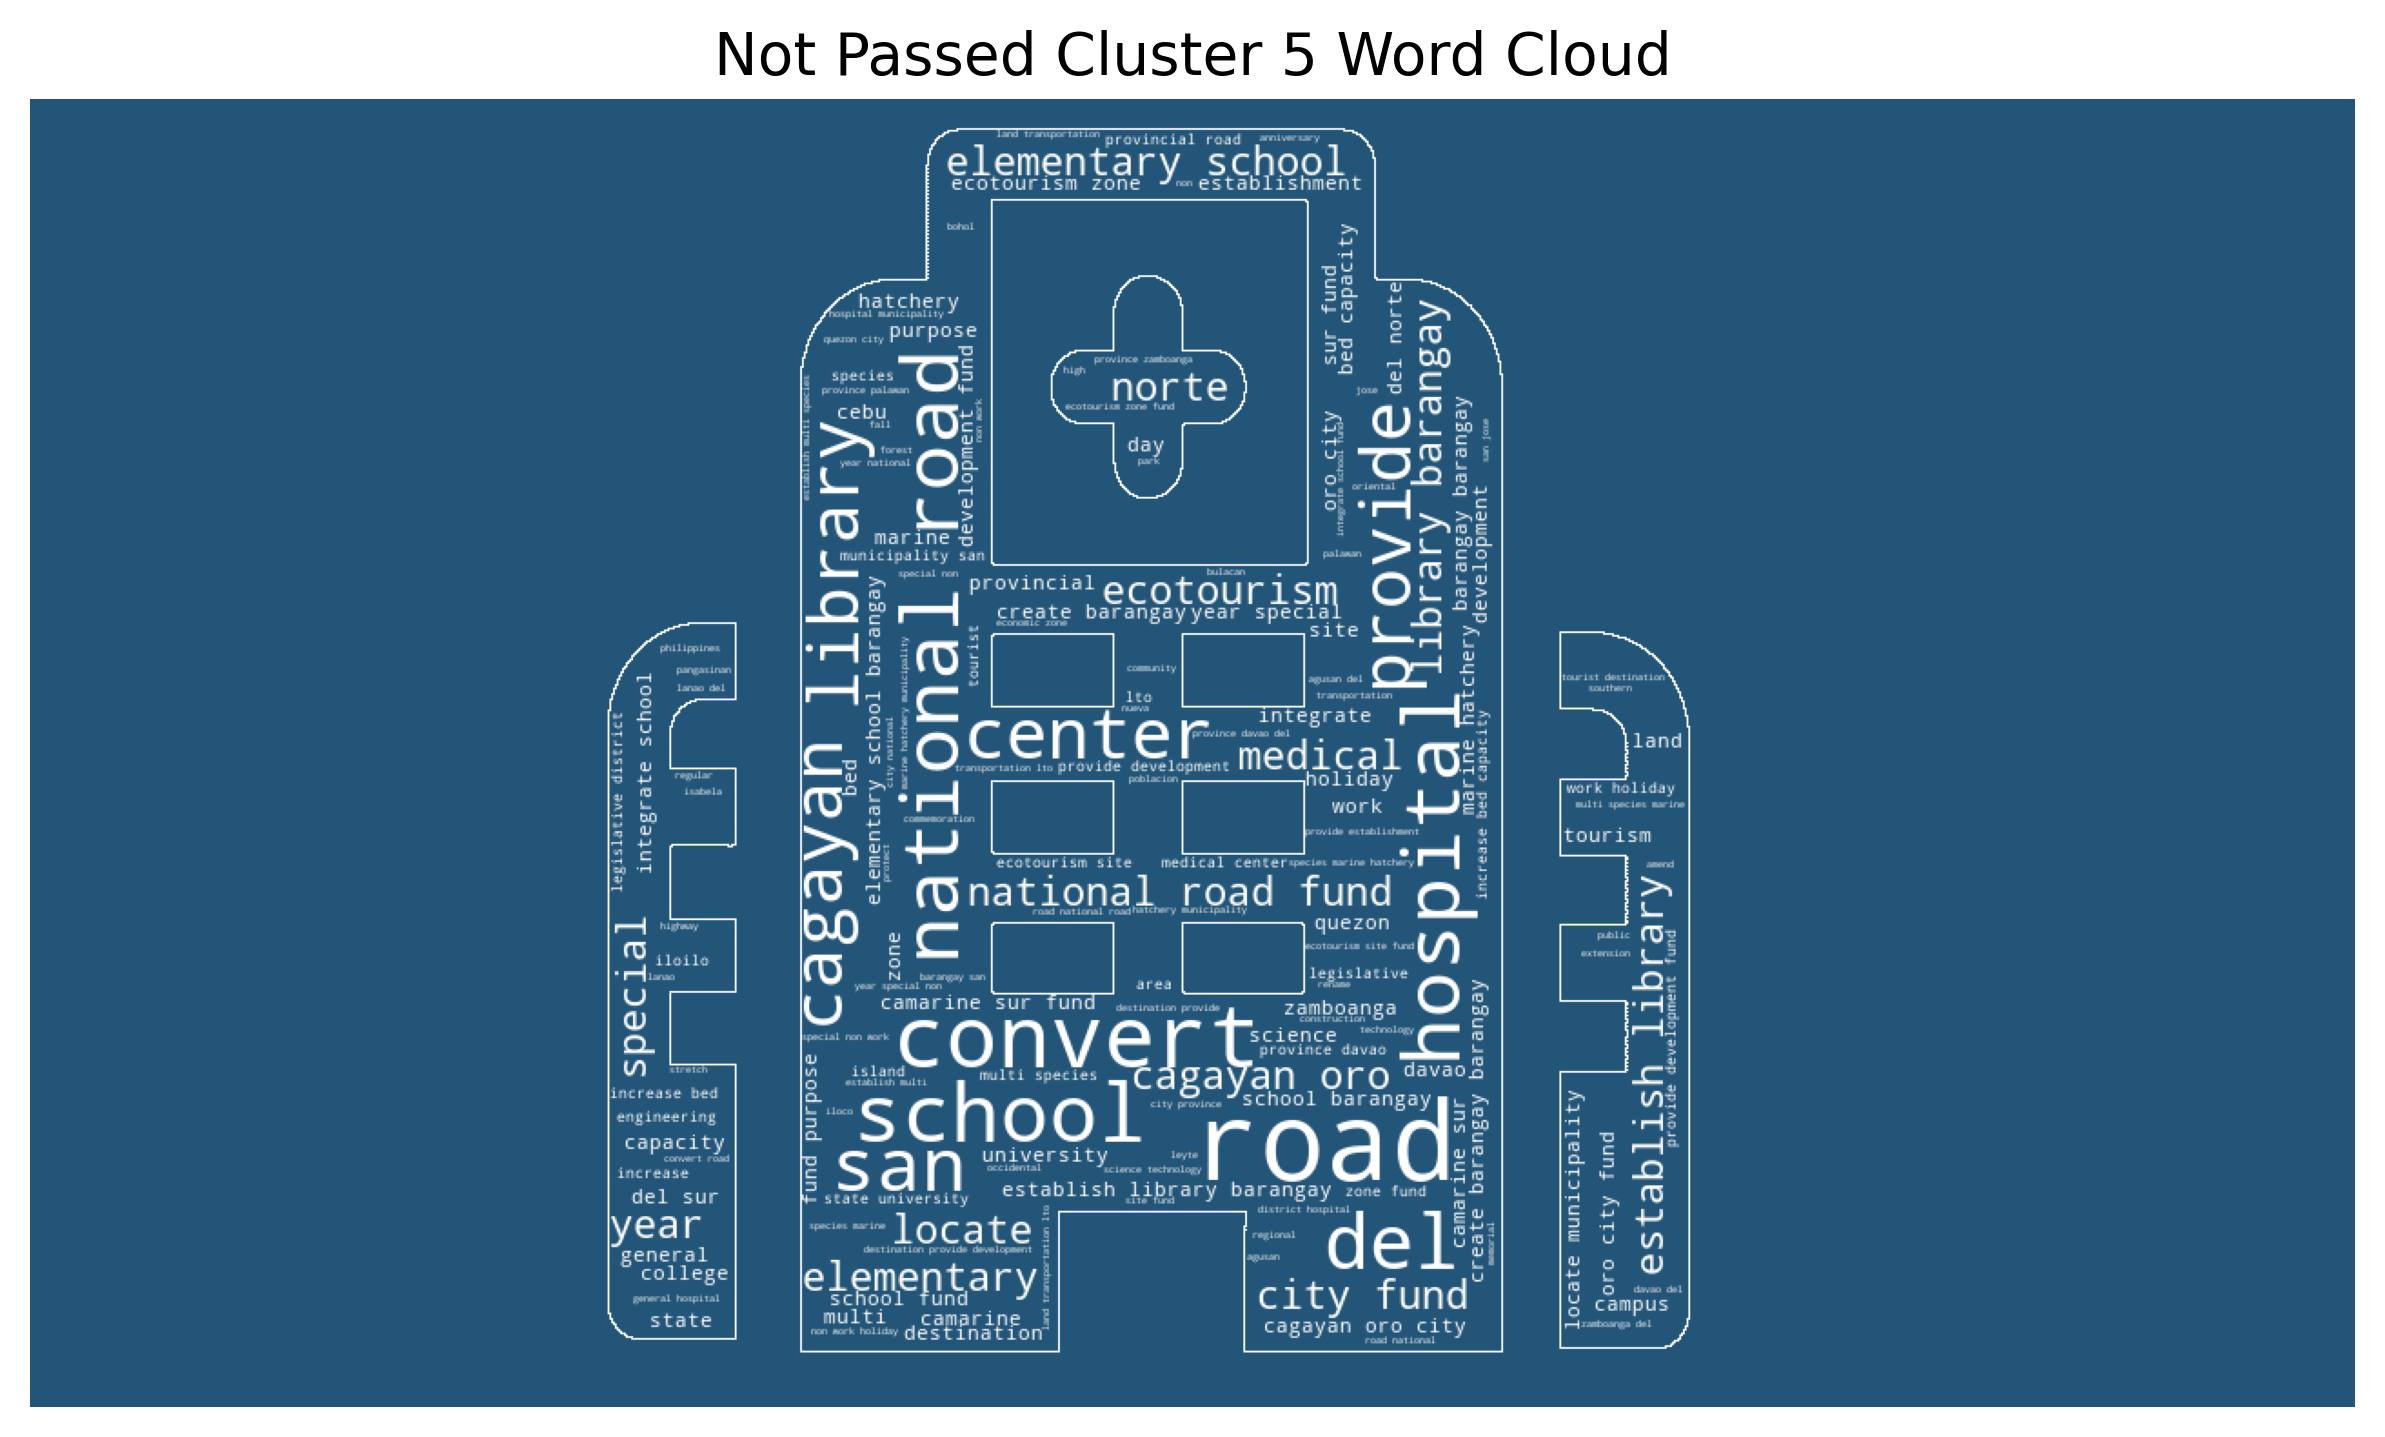

In [119]:
drop_c5 = ['municipality', 'oro', 'sur', 'fund',
           'province', 'barangay', 'city', 'district', 'declare',
           'national', 'establish', 'create', 'road fund']
ser_c5 = (pd.DataFrame(bow_cong_np.todense(),
                       columns=cols_np,
                       index=df_not_passed.index)
          .loc[idx_c5,:]
          .sum(axis=0).sort_values(ascending=False).drop(drop_c5, axis=0))

mask_build = Image.open('build.png')
mask_build = np.array(mask_build.convert('1'))
transformed_mask = np.ndarray((mask_build.shape[0], mask_build.shape[1]),
                              np.int32)

for i in range(len(mask_build)):
    transformed_mask[i] = list(map(transform_format, mask_build[i]))

wordcloud_plotting(ser_c5, 
                   ListedColormap(['white']), 
                   'Not Passed Cluster 5 Word Cloud', mask=transformed_mask)

In [120]:
cleaned_titles_np.loc[idx_c5,:]['stemmed_text'].tolist()

['provide construction skyway overpasse tunnel underpass congested road section district city cebu fund',
 'rename mactan cebu international airport lapu lapu cebu international airport mactan cebu international airport lapu lapu cebu international airport',
 'provide establishment construction second runway mactan cebu international airport mcia concomitant access taxiway rapid exit taxiway ret runway lighting system navigational landing equipment fund',
 'provide construction bridge cebu city municipality cordova province cebu coastal road expressway mactan – cebu international airport lapu lapu city bridge municipality consolacion province cebu mactan – cebu international airport lapu lapu city fund',
 'establish rise natural park province isabela protect area nipas r provide management purpose',
 'provide construction coastal road traverse city bacolod silay talisay victorias municipality enrique b magalona province negros occidental',
 'establish veteran memorial medical center lu

# Appendix

## Further Clustering of Cluster 4
Since the topics for cluster 4 are not apparent, we further cluster it. This is because most bills are in this cluster, we expect cluster 4 to contain different subclusters. 

In [61]:
c4_bills = df_passed.reset_index()[df_passed.reset_index().cluster_label==4].index
c4_bills

Int64Index([  0,   1,   2,   4,   5,   6,   8,   9,  10,  11,
            ...
            405, 406, 407, 413, 414, 415, 416, 419, 420, 421],
           dtype='int64', length=319)

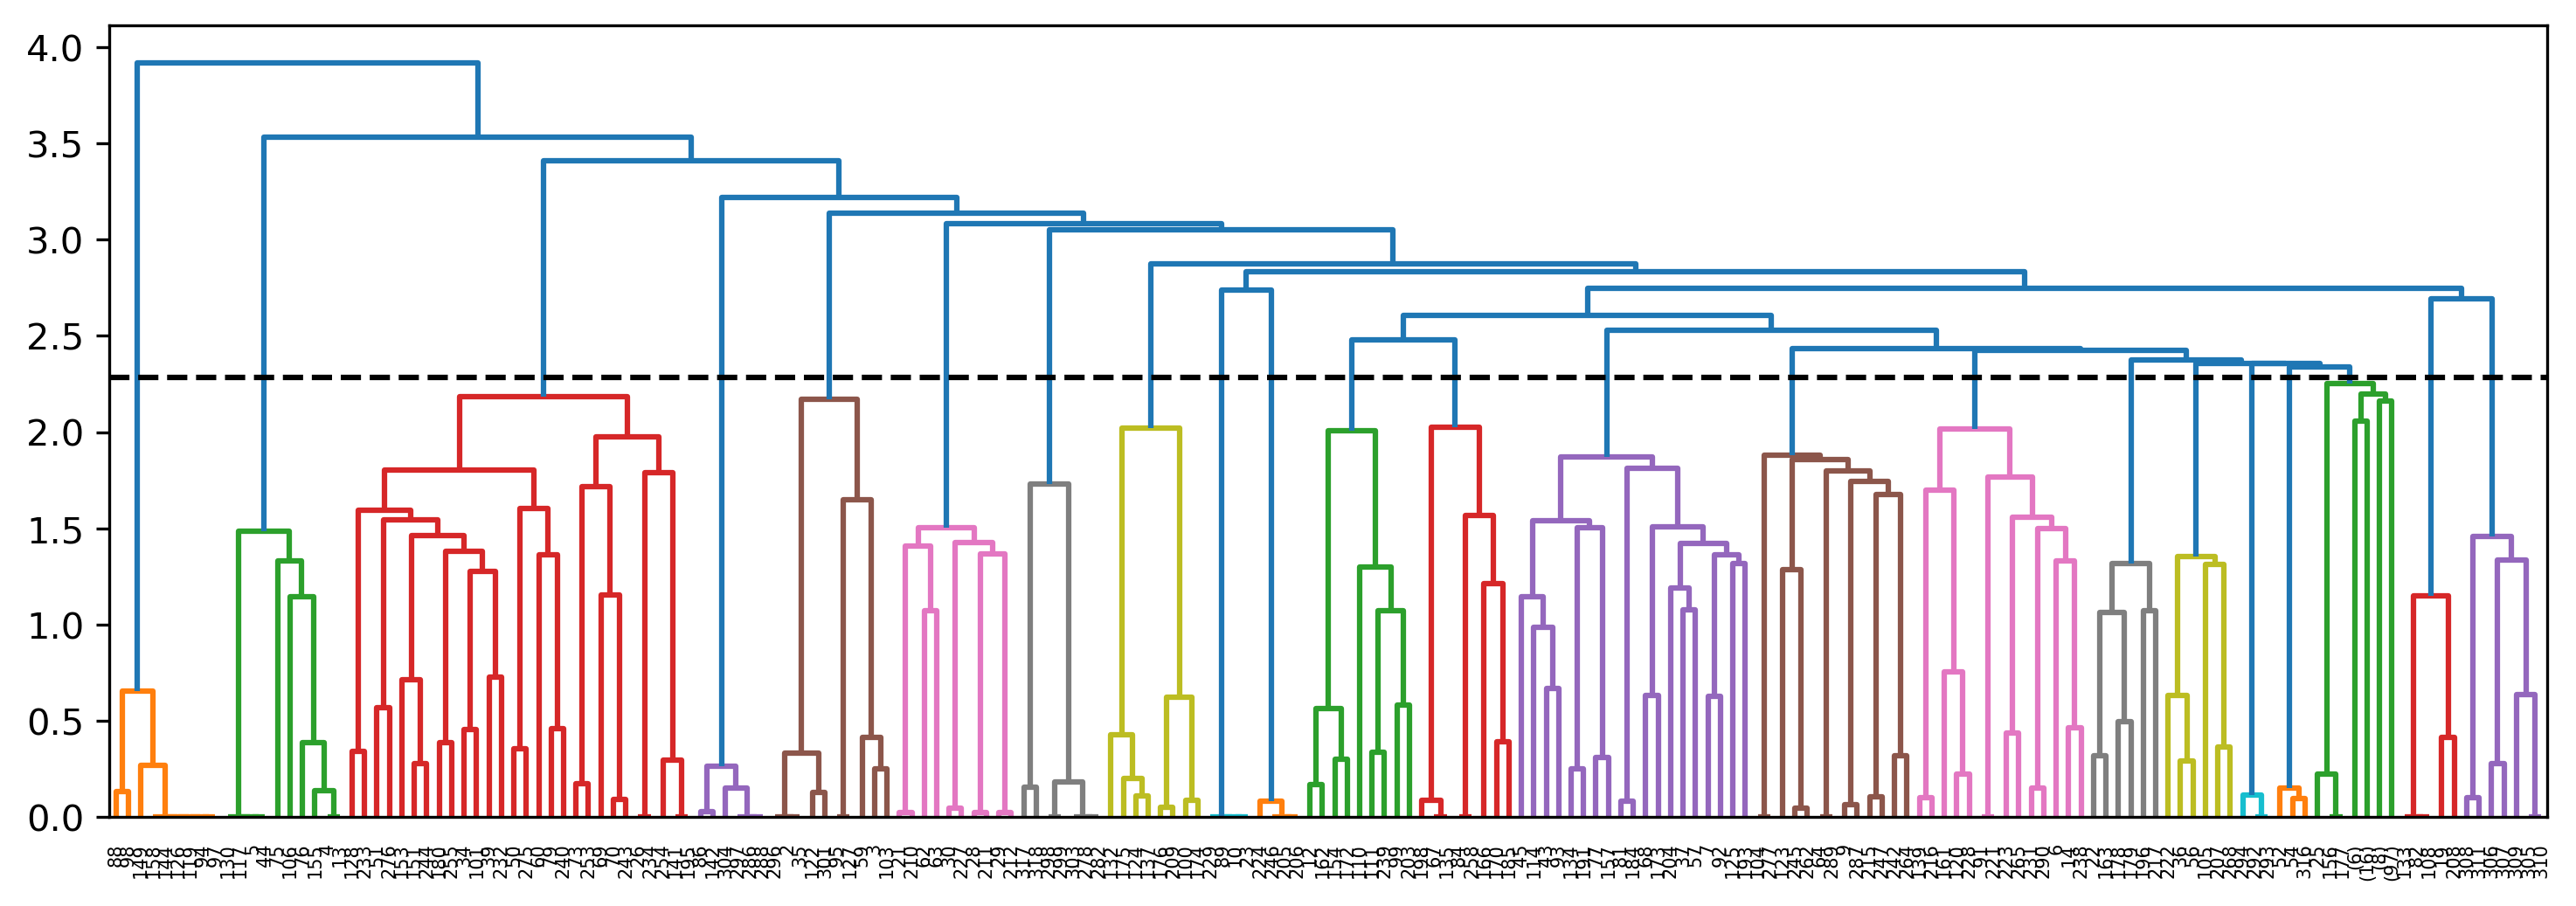

2.2848086958398706

In [62]:
X_c4 = X_cong_p_new[c4_bills,:]
X_c4

plot_dendrogram(X_c4, p=20, method='ward', tr_mode='level', show=True)

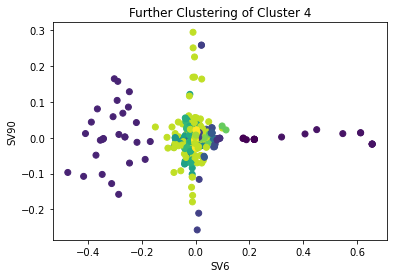

array([20, 20,  5,  5,  2,  2, 15, 13, 20, 14,  9, 20, 11,  2, 15, 20, 20,
       20, 20, 21, 20,  6, 16,  9, 20, 20,  3, 20,  6,  6,  6, 20, 20, 20,
        3,  5, 17, 13, 20,  3, 20, 20, 20, 13,  2, 13, 20, 20, 20, 20,  3,
        3, 19, 20, 19, 20, 17, 13, 20,  5,  3, 20,  6,  6, 14, 20, 20, 12,
       13,  3,  3, 20, 20,  3, 20,  2,  2, 13, 20,  3, 20, 13, 21, 20, 12,
       20,  4, 20,  1,  9, 20, 15, 13, 13,  1,  5, 20,  1,  1, 11,  8,  3,
       20,  5, 14, 17,  2, 20, 21, 20, 11, 11, 20, 20, 13, 20, 20,  2, 20,
        1, 15, 20,  5, 14,  8, 13,  1,  5,  3, 20,  2, 20,  8, 21, 13, 12,
       20,  8, 20, 15, 20,  3,  4, 20,  1, 20, 20, 20, 20,  1, 20,  3, 20,
        3, 11,  2, 20, 13,  1, 20, 20, 15, 11, 16, 20, 20, 12, 20, 20, 20,
       12, 20, 11, 13,  8,  8,  8, 20, 16, 16,  3, 20, 20, 20, 13, 12, 20,
       20, 20, 20, 20, 13, 20, 13, 20,  3, 16, 20, 12, 20, 20, 20, 20, 11,
       13, 10, 10, 17, 21,  8,  6,  6,  6, 20, 20, 14, 15, 16, 20, 20, 20,
       15, 17, 15, 10, 20

In [63]:
plot_fcluster(X_c4, plot_dendrogram(X_c4, p=10, show=False), 5, 89, 'Further Clustering of Cluster 4')

In [64]:
pd.Series(plot_fcluster(X_c4, plot_dendrogram(X_c4, p=10, show=False), 5, 89,'Further Clustering of Cluster 4', show=False)).value_counts()


20    130
3      28
13     19
15     14
14     13
2      10
6      10
5      10
11      9
1       9
12      8
8       8
7       7
22      7
4       6
16      6
17      6
21      5
10      4
9       4
19      3
18      3
dtype: int64

In [65]:
df_c4 = df_passed[df_passed.cluster_label == 4].copy()
df_c4['c4_subcluster_label'] = plot_fcluster(X_c4, plot_dendrogram(X_c4, p=10, show=False), 5, 89, 'Further Clustering of Cluster 4', show=False)
df_c4


house_bill_number                                              title  \
0              HB00001  AN ACT INSTITUTIONALIZING A NATIONAL VALUES, E...   
5              HB00006  AN ACT PROVIDING FOR ADDITIONAL SUPPORT AND CO...   
9              HB00010  AN ACT DECLARING THE COCONUT LEVY ASSETS AS A ...   
165            HB00166  AN ACT ESTABLISHING THE COCONUT FARMERS AND IN...   
175            HB00176  AN ACT AMENDING SECTIONS 4, 5, 20, 22, 27, 28,...   
...                ...                                                ...   
8635           HB08648  AN ACT EXPEDITING THE PURCHASE AND ADMINISTRAT...   
8636           HB08649  AN ACT EXPEDITING THE PURCHASE AND ADMINISTRAT...   
8915           HB08928  AN ACT\r\nESTABLISHING THE PHILIPPINE ENERGY R...   
9298           HB09312  AN ACT REMOVING THE EXPIRATION PERIOD OF THE J...   
9473           HB09487  AN ACT \r\nENHANCING THE POWERS AND FUNCTIONS ...   

     significance  date_filed  \
0        NATIONAL  2019-07-01   
5        NATIONAL  2019-07-01   
9        NATIONAL  2019-07-01   
165      NATIONAL  2019-07-01   
175      NATIONAL  2019-07-01   
...           ...         ...   
8635     NATIONAL  2021-02-08   
8636     NATIONAL  2021-02-08   
8915     NATIONAL  2021-03-08   
9298     NATIONAL  2021-05-09   
9473     NATIONAL  2021-05-26   

                                      principal_authors   date_read  \
0     CAYETANO, ALAN PETER "COMPAÑERO" S.; MADRONA. ...  2019-07-23   
5                   CAYETANO, ALAN PETER "COMPAÑERO" S.  2019-07-23   
9                   CAYETANO, ALAN PETER "COMPAÑERO" S.  2019-07-23   
165                     TAN, ANGELINA "HELEN" D.L. M.D.  2019-07-23   
175   SUANSING, HORACIO JR. P.; SUANSING, ESTRELLITA...  2019-07-23   
...                                                 ...         ...   
8635  VELASCO, LORD ALLAN JAY Q.; ROMUALDEZ, FERDINA...  2021-02-08   
8636                                      CUA, JUNIE E.  2021-02-08   
8915  VELASCO, LORD ALLAN JAY Q.; VIOLAGO, MICAELA S...  2021-03-08   
9298                      MACAPAGAL ARROYO, JUAN MIGUEL  2021-05-18   
9473  MACAPAGAL ARROYO, JUAN MIGUEL; DE JESUS, PRESL...  2021-05-26   

                 primary_referral                          mother_bill_status  \
0     BASIC EDUCATION AND CULTURE  Republic Act RA11476 enacted on 2020-06-25   
5                  APPROPRIATIONS  Republic Act RA11466 enacted on 2020-01-08   
9            AGRICULTURE AND FOOD  Republic Act RA11524 enacted on 2021-02-26   
165          AGRICULTURE AND FOOD  Republic Act RA11524 enacted on 2021-02-26   
175                WAYS AND MEANS  Republic Act RA11534 enacted on 2021-03-26   
...                           ...                                         ...   
8635               APPROPRIATIONS                                         NaN   
8636               APPROPRIATIONS  Republic Act RA11525 enacted on 2021-02-26   
8915                       ENERGY                                         NaN   
9298                       ENERGY  Republic Act RA11571 enacted on 2021-07-06   
9473                       ENERGY                                         NaN   

                                          status pass_or_not  cluster_label  \
0                         Substituted by HB05829      passed              4   
5                      Consolidated into HB05712      passed              4   
9                         Substituted by HB08136      passed              4   
165                       Substituted by HB08136      passed              4   
175                       Substituted by HB04157      passed              4   
...                                          ...         ...            ...   
8635  Republic Act RA11525 enacted on 2021-02-26      passed              4   
8636                   Consolidated into HB08648      passed              4   
8915  Republic Act RA11572 enacted on 2021-07-30      passed              4   
9298                      Substituted by HB09487      passed       

### Subcluster 4.1

In [66]:
df_c4[df_c4['c4_subcluster_label'] == 1].index

Int64Index([2302, 2504, 2533, 2536, 3106, 3265, 3645, 3939, 4183], dtype='int64')

In [67]:
cleaned_titles_p.loc[df_c4[df_c4['c4_subcluster_label'] == 1].index,:]['stemmed_text'].tolist()

['create malasakit center complement implementation ꞌuniversal health care actꞌ require philhealth operate maintain malasakit center doh lgu suc dnd hospital country provide fund purpose',
 'institutionalize malasakit center complement implementation universal health care require philhealth operate maintain malasakit center doh lgu suc dnd hospital country provide fund purpose',
 'institutionalize malasakit center complement implementation universal health care require philhealth operate maintain malasakit center doh lgu suc dnd hospital country provide fund purpose',
 'institutionalize malasakit center complement implementation ꞌuniversal health care actꞌ require philhealth operate maintain malasakit center doh lgu suc dnd hospital country provide fund purpose',
 'institutionalize malasakit center complement implementation universal health care require philhealth operate maintain malasakit center doh lgu suc dnd hospital country provide fund purpose',
 'institutionalize malasakit cent

### Subcluster 4.2

In [68]:
cleaned_titles_p.loc[df_c4[df_c4['c4_subcluster_label'] == 2].index,:]['stemmed_text'].tolist()

['amend section add section b national internal revenue code purpose',
 'amend section national internal revenue code',
 'amend section add section b national internal revenue code purpose',
 'amend section national internal revenue code',
 'increase excise tax alcohol product heat tobacco product vapor product amend section b c national internal revenue code purpose',
 'amend section add section new title xiii national internal revenue code purpose',
 'amend section addite section chapter ii iii iv v vi national internal revenue code purpose',
 'amend section national internal revenue code',
 'amend section national internal revenue code',
 'amend section add new section national internal revenue code purpose']

### Subcluster 4.3

In [69]:
cleaned_titles_p.loc[df_c4[df_c4['c4_subcluster_label'] == 3].index,:]['stemmed_text'].tolist()

['increase bed capacity cagayan valley medical center cvmc tuguegarao city province cagayan thousand bed fund',
 'increase bed capacity bicol medical center bed thousand bed upgrade service facility professional health care service authorize increase medical workforce complement amend fund',
 'increase bed capacity western visayas medical center manduriao iloilo city seven authorizing increase medical personnel upgrading service facility professional health care fund',
 'convert schistosomiasis control research hospital palo leyte general hospital governor benjamin romualdez general hospital increase bed capacity upgrading service facility professional health care authorize increase medical personnel fund',
 'increase bed capacity eastern visayas regional medical center tacloban city thousand authorizing increase medical personnel upgrading service facility professional health care service fund rename eastern visayas medical center',
 'upgrade caraga regional hospital barangay washingt

### Subcluster 4.4

In [70]:
cleaned_titles_p.loc[df_c4[df_c4['c4_subcluster_label'] == 4].index,:]['stemmed_text'].tolist()

['repeal minimum height requirement applicant national police pnp bureau fire protection bfp bureau jail management penology bjmp',
 'repeal minimum height requirement applicant national police pnp bureau fire protection bfp bureau jail management penology',
 'lower minimum height requirement applicant national police pnp bureau fire protection bfp bureau jail management penology bjmp bureau correction bucor amend purpose',
 'lower minimum height requirement applicant national police pnp bureau fire protection bfp bureau jail management penology bjmp bureau correction bucor amend purpose',
 'lower minimum height requirement applicant national police pnp bureau fire protection bfp bureau jail management penology bjmp bureau correction bucor amend purpose',
 'lower minimum height requirement remove height waiver applicant national police pnp bureau fire protection bfp bureau jail management penology bjmp bureau correction bucor amend']

### Subcluster 4.5

In [71]:
cleaned_titles_p.loc[df_c4[df_c4['c4_subcluster_label'] == 5].index,:]['stemmed_text'].tolist()

['declare coconut levy asset trust provide management utilization authorize privatization management dispose coconut levy asset purpose',
 'establish coconut farmer industry development trust provide management utilization',
 'declare coconut levy asset trust provide management utilization authorize privatization management dispose coconut levy asset purpose',
 'establish coconut farmer industry trust provide management utilization',
 'create coconut industry trust provide management purpose',
 'establish coconut farmer industry development trust fund provide management utilization prioritize limit coconut farmer cooperative organization',
 'declare coconut levy asset coconut farmer industry trust provide management utilization authorize privatization management dispose coconut levy asset purpose',
 'create coconut industry trust provide management purpose',
 'declare coconut levy asset trust provide management utilization authorize privatization management dispose coconut levy asset p

### Subcluster 4.6

In [72]:
cleaned_titles_p.loc[df_c4[df_c4['c4_subcluster_label'] == 6].index,:]['stemmed_text'].tolist()

['separate tabuk city national high school – bantay extension barangay bantay city tabuk province kalinga tabuk city national high school convert independent national high school bantay national high school fund',
 'separate guinzadan national high school – mayag extension barangay mayag municipality bauko province mountain province guinzadan national high school convert independent national high school mayag national high school fund',
 'separate lubon national high school – mabalite extension barangay mabalite municipality tadian province mountain province lubon national high school convert independent national high school mabalite national high school fund',
 'separate guina ang national high school – mainit extension barangay mainit municipality bontoc province mountain province guina ang national high school convert independent national high school mainit national high school fund',
 'change pag asa national high school barangay rawis city legazpi province albay legazpi city natio

### Subcluster 4.7

In [73]:
cleaned_titles_p.loc[df_c4[df_c4['c4_subcluster_label'] == 7].index,:]['stemmed_text'].tolist()

['extend implementation lifeline rate amend electric power industry reform',
 'extend implementation lifeline rate amend electric power industry reform',
 'extend enhance implementation lifeline rate amend electric power industry reform',
 'extend enhance implementation lifeline rate amend electric power industry reform',
 'extend implementation lifeline rate amend electric power industry reform',
 'remove expiration period joint congressional energy commission amend electric power industry reform',
 'enhance power function joint congressional energy commission amend " electric power industry reform "']

### Subcluster 4.8

In [74]:
cleaned_titles_p.loc[df_c4[df_c4['c4_subcluster_label'] == 8].index,:]['stemmed_text'].tolist()

['modifying salary schedule civilian government personnel',
 'adjust salary schedule civilian personnel government purpose',
 'adjust salary civilian personnel government purpose',
 'adjust salary schedule civilian personnel government',
 'modifying salary schedule civilian government personnel purpose',
 'increase salary schedule civilian personnel government purpose',
 'modifying salary schedule civilian government personnel authorize grant additional benefit',
 'modifying salary schedule civilian government personnel authorize grant additional benefit purpose']

### Subcluster 4.9

In [75]:
cleaned_titles_p.loc[df_c4[df_c4['c4_subcluster_label'] == 9].index,:]['stemmed_text'].tolist()

["make position cooperative officer mandatory municipal city provincial level amend ' local government code '",
 'make position cooperative officer mandatory municipal city provincial level amend local government code',
 'make position cooperative officer mandatory municipal city provincial level amend local government code',
 'make position cooperative officer mandatory municipal city provincial level amend local government code']

### Subcluster 4.10

In [76]:
cleaned_titles_p.loc[df_c4[df_c4['c4_subcluster_label'] == 10].index,:]['stemmed_text'].tolist()

['expand jurisdiction metropolitan trial court municipal trial court citie municipal trial court municipal circuit trial court amend bata pambansa blg judiciary reorganization',
 'expand jurisdiction metropolitan trial court municipal trial court citie municipal trial court municipal circuit trial court amend bata pambansa blg judiciary reorganization',
 'expand jurisdiction regional trial court metropolitan trial court municipal trial court municipal circuit trial court amend bata pambansa blg judiciary reorganization',
 'expand jurisdiction metropolitan trial court municipal trial court citie municipal trial court municipal circuit trial court amend bata pambansa blg judiciary reorganization']

### Subcluster 4.11

In [77]:
cleaned_titles_p.loc[df_c4[df_c4['c4_subcluster_label'] == 11].index,:]['stemmed_text'].tolist()

['establish high school sport fund',
 'create establish national academy sport provide fund',
 'create national academy sport development high school student fund purpose',
 'create establish national academy sport fund',
 'create establish high school sport',
 'establish high school sport region fund',
 'create establish high school sport phss system provide fund',
 'create establish academy sport provide fund',
 'establish national academy sport system fund']

### Subcluster 4.12

In [78]:
cleaned_titles_p.loc[df_c4[df_c4['c4_subcluster_label'] == 12].index,:]['stemmed_text'].tolist()

['provide medical scholarship qualified student municipality establish town doctor scholarship program fund purpose',
 'establish medical scholarship return service program deserve student fund',
 'provide medical scholarship qualified student municipality establish town doctor scholarship program fund purpose',
 'create medical academy establish medical scholarship program fund',
 'establish medical education scholarship service program fund',
 'establish medical scholarship service program fund thereof',
 'provide medical scholarship qualified student municipality establish town doctor scholarship program fund',
 'establish medical scholarship return service program deserve student fund']

### Subcluster 4.13

In [79]:
cleaned_titles_p.loc[df_c4[df_c4['c4_subcluster_label'] == 13].index,:]['stemmed_text'].tolist()

['increase minimum salary public school teacher government employee augment personnel economic relief allowance',
 'increase minimum salary teacher non teach personnel public school grant additional incentive',
 'increase basic salary public school teacher thirty thousand pesos p',
 'provide thousand peso php board increase basic salary public school teacher kindergarten elementary secondary senior high school fund',
 'grant public school teacher non teach personnel department education depe board increase thousand pesos p month fund',
 'grant special hardship allowance public school teacher school head administrator hardship post',
 'provide board increase thousand peso php basic salary elementary secondary public school teacher fund',
 'increase salary head teacher proportion function relation payscale teacher provide law',
 'increase minimum salary public school teacher fund',
 'increase basic salary public school teacher provide fund thereof',
 'increase basic salary government nur

### Subcluster 4.14

In [80]:
cleaned_titles_p.loc[df_c4[df_c4['c4_subcluster_label'] == 14].index,:]['stemmed_text'].tolist()

['convert occidental mindoro state college province occidental mindoro state university occidental mindoro state university omsu fund',
 'convert basilan state college bassc city isabela province basilan state university basilan state university bassu fund',
 'convert abra state sciences technology municipality lagangilang bangue province abra state university university abra fund',
 'convert agusan del sur state college agriculture technology asscat municipality bunawan province agusan del sur state university integrate therewith satellite campus municipality trento province agusan del sur agusan del sur state university adssu fund',
 'rename compostela valley state college davao de oro state college',
 'convert bicol state college apply science technology state university university science technology fund',
 'convert surigao del sur state university sdssu province surigao del sur north eastern mindanao state university nemsu fund',
 'rename compostela valley state college municipali

### Subcluster 4.15

In [81]:
cleaned_titles_p.loc[df_c4[df_c4['c4_subcluster_label'] == 15].index,:]['stemmed_text'].tolist()

['provide reapportionment province bataan legislative district',
 'redistricte second district rizal legislative district',
 'create district engineering seventh legislative district province cebu fund',
 'establish district engineering province cotabato fund',
 'amend establish sorsogon second district engineering province sorsogon fund',
 'establish district engineering municipality matalam province north cotabato fund',
 'transfer location sorsogon second district engineering offfice bulan sorsogon gubat sorsogon amend entitle establish sorsogon second district engineering province sorsogon fund',
 'create district engineering seventh legislative district province cebu fund',
 'reapportion province bulacan seven regular district',
 "establish district engineering municipality m'lang province cotabato fund",
 'reapportion legislative district city caloocan',
 'reapportion second legislative district province rizal legislative district',
 'reapportion province bulacan legislative dist

### Subcluster 4.16

In [82]:
cleaned_titles_p.loc[df_c4[df_c4['c4_subcluster_label'] == 16].index,:]['stemmed_text'].tolist()

['institutionalize good manner right conduct character education basic education curriculum',
 'institutionalize good manner right conduct character education curriculum elementary secondary level',
 'revive good manner right conduct gmrc separate subject basic education curriculum',
 'institutionalize good manner right conduct gmrc k curriculum',
 'institute value education k curriculum enhance edukasyon sa pagpapakatao program incorporate teach good manner right conduct include character building activity',
 'institutionalize value education curriculum incorporate good manner right conduct subject kindergarten grade level']

### Subcluster 4.17

In [83]:
cleaned_titles_p.loc[df_c4[df_c4['c4_subcluster_label'] == 17].index,:]['stemmed_text'].tolist()

['amend certain section ra organic agriculture',
 'strengthen sustainable agriculture enhance support small organic farmer amend certain section organic agriculture',
 'strengthen implementation national organic agriculture program enhance regulatory capacity establish coordinate office augment human resource complement repealing fund',
 'amend organic agriculture',
 'strengthen implementation national organic agriculture program amend certain section ra organic agriculture',
 'strengthen impementation national organic agriculture program amend organic agriculture']

### Subcluster 4.18

In [84]:
cleaned_titles_p.loc[df_c4[df_c4['c4_subcluster_label'] == 18].index,:]['stemmed_text'].tolist()

['authorize president expedite processing issuance national local permit license certification',
 'authorize president expedite processing issuance national local permit license certification',
 'authorize president expedite processing issuance national local permit license certification times national emergency']

### Subcluster 4.19

In [85]:
cleaned_titles_p.loc[df_c4[df_c4['c4_subcluster_label'] == 19].index,:]['stemmed_text'].tolist()

['establish energy research policy define objective power function fund',
 'establish energy research policy define objective power function provide fund purpose',
 'establish energy research policy define objective power function provide fund']

### Subcluster 4.20

In [86]:
cleaned_titles_p.loc[df_c4[df_c4['c4_subcluster_label'] == 20].index,:]['stemmed_text'].tolist()

['institutionalize national value etiquette moral uprightness program',
 'provide additional support compensation educator basic education',
 'establish national minimum monthly salary government provide fund',
 'convert guimba – talugtug – umingan provincial road municipalitie guimba talugtug province nueva ecija municipality umingan province pangasinan national road fund',
 'convert road network connect barangay grijalvo municipality san fernando municipality bula national road',
 'convert albay diversion road minalabac bula nabua national road',
 'grant exemption medical doctor coverage salary standardization law authorize appropriation fund',
 'create department education plantilla position guidance counselor elementary school additional plantilla position guidance counselor high school increase salary guidance counselor guidance relate position fund',
 'establish hospital city bacolod province negros occidental bacolod city district hospital fund',
 'provide increase automatic adj